In [1]:
import collections

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi
import os
import pybedtools
import h5sparse
import datetime
import logging

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys
%matplotlib inline

# Define Paths for this user

In [2]:
########################## PATHS ###########################
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

deepsea_path = "/data/jwhughes/deepsea_train/"
# dnase_preprocessed_path = "/data/akmorrow/epitome_data/processed_dnase/"
# feature_path = "/home/eecs/akmorrow/epitome/data/feature_name"

# _DEEPSEA_GENOME_REGIONS_FILENAME = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"

# DNase filepath dictionary
# prefix_ =  "/data/akmorrow/encode_data/"

 # get TF logger
log = logging.getLogger('tensorflow')
tf_log = "/home/eecs/jwhughes/epitome/dnase/tensorflow_combination.log"
fh = logging.FileHandler(tf_log)
fh.setLevel(logging.INFO)
log.addHandler(fh)

In [3]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())

# Load Data

### Load DeepSEA data

In [4]:
train_data, valid_data, test_data = load_deepsea_data(deepsea_path)

print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(408000, 4, 1000) (4000000, 4, 1000) (455024, 4, 1000)
(919, 408000) (919, 4000000) (919, 455024)


# Choose cell types

['K562', 'GM12878', 'H1-hESC', 'HepG2', 'HeLa-S3', 'A549', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116'] ['DNase', 'CTCF', 'Pol2', 'YY1', 'p300', 'TAF1', 'Pol2-4H8', 'c-Myc', 'Rad21', 'Max', 'NRSF', 'GABP', 'EZH2', 'CEBPB', 'c-Jun', 'ZBTB33', 'USF2', 'USF-1', 'TBP', 'RFX5']


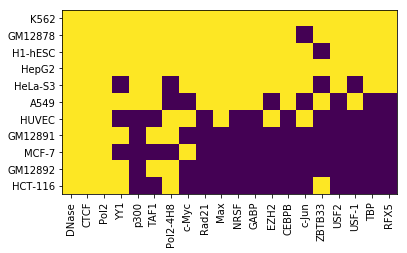

In [5]:
# matrix is cell types by factors, contains indices in feature vector
matrix, cellmap, assaymap = get_assays_from_feature_file()

inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys())[:11], list(assaymap.keys())[:20])

# Select train, valid and test cell types

- test on A549
- train/validate on K562 and HepG2
- use remaining cell types as feature input 

In [6]:
# A549 is for test. 12 available features
test_celltypes = ["A549"]

valid_y_indices = np.copy(matrix[cellmap['A549']])
valid_holdout_indices = np.where(valid_y_indices == -1)[0]
# TODO: need the vectors to be the same length, but you should not evaluate on these
# Currently, set -1's to 0 these will all be evaluated on the DNase
valid_y_indices[matrix[cellmap['A549']] ==-1]=0

# K562, HepG2 indices is for train/valid. 19 available features
evaluation_celltypes = ["K562", "HepG2"] 
y_indices = [matrix[cellmap['K562']][matrix[cellmap['K562']]!=-1], 
             matrix[cellmap['HepG2']][matrix[cellmap['HepG2']]!=-1]]

# indices_mat is used to pull the remaining indices from cell types not used for prediction.
# delete evaluation cell types from the matrix (A549, HepG2 and K562)
indices_mat = np.delete(matrix, [0,3,5], axis=0)

# get all feature locations for DNase for remaining cell types (just the first column in matrix)
dnase_indices = indices_mat[:,0] # for all of the cell types (including the cell type we are evaluating)
indices = indices_mat[indices_mat!=-1]

# cell types not used in validation
train_celltypes = ['GM12878', 'H1-hESC', 'HeLa-S3', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116']


# Data Generators

## Generator with just processed DNase

In [9]:

### Distance functions
def gen(data, DATA_LABEL, radii=[1,3]):
    def g():
        
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            y_index_vector = [valid_y_indices]
        else:
            y_index_vector = y_indices
            
        if (len(radii) > 0):
            range_ = range(max(radii), data["y"].shape[-1]-max(radii))
        else: 
            range_ = range(0, data["y"].shape[-1])
 
        for i in range_: # for all records
            for y_index in y_index_vector:
                dnases = [] 
                for radius in radii:
                    # within the radius, fraction of places where they are both 1
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    
                    # within the radius, fraction of places where they are both equal (0 or 1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnases.extend(dnase_double_positive)
                    dnases.extend(dnase_agreement)
                    
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])
                yield np.concatenate([data["y"][indices,i],dnases]), data["y"][y_index_no_dnase,i], data["x"][i]
    return g

def make_dataset(data,
                 which_dataset,
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):

    generator = gen(data, which_dataset, radii)
    
    for x, y, seq in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2+(tf.int32,),
        output_shapes=(x.shape, y.shape, seq.shape)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()


# Check how DeepSea does

In [10]:
model = kipoi.get_model('DeepSEA/predict')
batch_size = 100
preds = []
for i in np.arange(0, len(valid_data["x"]), batch_size):
    batch = valid_data["x"][i:i+batch_size]
    batch = np.expand_dims(batch, 2)
    batch = batch[:,[0,2,1,3]]
    preds.append(model.predict_on_batch(batch.astype(np.float32)))
preds = np.concatenate(preds, axis=0)

ImportError: No module named 'kipoiseq'

### Direct performance of DeepSea

In [ ]:
# for i in range(20):
print(valid_data["y"][y_indices[0]].shape)
print(preds.T[y_indices[0]].shape)
sklearn.metrics.roc_auc_score(valid_data["y"][y_indices[0]].T, preds.T[y_indices[0]].T, average="macro")

### Performance of DeepSea through averaging

In [12]:
weights = np.tile((indices_mat!=-1).reshape(indices_mat.shape + (1,)), (1, 1, valid_data["y"].shape[-1]))

average_preds = np.average(preds.T[indices_mat], axis=0, weights=weights)
average_preds = np.concatenate([average_preds,average_preds],axis=1)

truth = np.concatenate([valid_data["y"][y_indices[0]],valid_data["y"][y_indices[1]]],axis=1)

print("Macro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='macro'))
print("Micro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='micro'))
for i in range(len(truth)):
    print(i, sklearn.metrics.roc_auc_score(truth[i].T, average_preds[i].T, average='macro'))

NameError: name 'preds' is not defined

# Model definition

In [11]:
class Model():
    def __init__(self,
                 train_data,
                 valid_data,
                 test_data,
                 batch_size=64,
                 shuffle_size=10000,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 radii=[1,3]):
        
        self.graph = tf.Graph()

        with self.graph.as_default() as graph:
            tf.logging.set_verbosity(tf.logging.INFO)

            #### Weston uncomment to run original method
            output_shape, train_iter = make_dataset(train_data,  Dataset.TRAIN, batch_size, shuffle_size, prefetch_size, radii)
            _,            valid_iter = make_dataset(valid_data, Dataset.VALID, batch_size, 1           , prefetch_size, radii)
            _,            test_iter = make_dataset(test_data, Dataset.TEST, batch_size, 1           , prefetch_size, radii)

            self.train_handle = train_iter.string_handle()
            self.valid_handle = valid_iter.string_handle()
            self.test_handle = test_iter.string_handle()
            
            self.handle = tf.placeholder(tf.string, shape=[])
            iterator = tf.data.Iterator.from_string_handle(
                self.handle, train_iter.output_types, train_iter.output_shapes)
            self.x, self.y, self.seq = iterator.get_next()
            self.seq = tf.cast(self.seq,tf.float32)
            
            self.sess = tf.InteractiveSession(graph=graph)

            self.num_outputs = output_shape[0]
            self.l1, self.l2 = l1, l2
            self.default_lr = lr
            self.lr = tf.placeholder(tf.float32)
            self.batch_size = batch_size
            self.prefetch_size = prefetch_size

            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.logits = self.body_fn()
            self.predictions = tf.sigmoid(self.logits)
            self.loss = self.loss_fn()
            self.min = self.minimizer_fn()
            
            self.closed = False
                
    def body_fn(self):
        raise NotImplementedError()
    
    def loss_fn(self):
        return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.y, self.logits, 50))
    
    def minimizer_fn(self):
        self.opt = tf.train.AdamOptimizer(self.lr)
        return self.opt.minimize(self.loss, self.global_step)
    
    def close():
        if not self.closed:
            self.sess.close()
        self.closed = True
        
    def train(self, num_steps, lr=None):
        assert not self.closed
        with self.graph.as_default():
            if lr == None:
                lr = self.default_lr
            try:
                self.sess.run(self.global_step)
            except:
                tf.logging.info("Initializing variables")
                self.sess.run(tf.global_variables_initializer())
                self.train_handle = self.sess.run(self.train_handle)
                self.valid_handle = self.sess.run(self.valid_handle)
                self.test_handle = self.sess.run(self.test_handle)

            max_steps = self.sess.run(self.global_step) + num_steps

            tf.logging.info("Starting Training")

            while self.sess.run(self.global_step) < max_steps:
                _, loss = self.sess.run([self.min, self.loss], {self.handle: self.train_handle, self.lr: lr})
                step = self.sess.run(self.global_step)
                if step % 1000 == 0:
                    tf.logging.info(str(step) + " " + str(loss))
                    tf.logging.info("On validation")
                    _, _, _, _, stop = self.test(40000, log=False)
                    if stop: break
                    tf.logging.info("")
                    

                
    def test(self, num_samples, mode = Dataset.VALID, log=False, iterator_handle=None):
        if (mode == Dataset.VALID):
            handle = self.valid_handle
            validation_holdout_indices = np.array([]) 
        elif (mode == Dataset.TEST):
            handle = self.test_handle
            # indices of assays not available for A549, -1 because first DNAse col was removed
            validation_holdout_indices = valid_holdout_indices - 1 
        else:
            raise
            
        assert not self.closed
        with self.graph.as_default():
            vals = []
            for i in range(int(num_samples / self.batch_size)):
                vals.append(
                    self.sess.run([self.predictions, self.x, self.y],
                             {self.handle: iterator_handle if iterator_handle else handle})
                )
            preds = np.concatenate([v[0] for v in vals])
            truth = np.concatenate([v[2] for v in vals])

            # remove missing indices for computing macro/micro AUC
            preds_r = np.delete(preds, validation_holdout_indices, axis=1)
            truth_r = np.delete(truth, validation_holdout_indices, axis=1)
            
            macroAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='macro')
            microAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='micro')
            tf.logging.info("Our macro AUC:     " + str(macroAUC))
            tf.logging.info("Our micro AUC:     " + str(microAUC))
            if True: # if log:
                j=0
                
                for i in range(matrix.shape[1]): # eval on all assays except DNase and assays that are missing in A549
                    assay = inv_assaymap[i]

                    if (i not in validation_holdout_indices+1 and i != 0):
                        str_ = "%s: %i, %s, %f" % (str(datetime.datetime.now()), i, assay, sklearn.metrics.roc_auc_score(truth_r[:,j], preds_r[:,j], average='macro'))
                        j = j + 1
                    else:
                        str_ = "%s: %i, %s, NaN" % (str(datetime.datetime.now()), i, assay)
                        
                    tf.logging.info(str_)
  
                
            return preds, truth, microAUC, macroAUC, False

class MLP(Model):
    def __init__(self,
             layers,
             num_units,
             activation,
             *args,
             **kwargs):

        self.layers = layers
        self.num_units = num_units
        self.activation = activation
        
        Model.__init__(self, *args, **kwargs)
            
    def body_fn(self):
        model = self.x
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
            
        for i in range(self.layers):
            model = tf.layers.dense(model, self.num_units[i], self.activation)#, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))
        
        return tf.layers.dense(model, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))


class MLP_with_sequence_CNN(Model):
    def __init__(self,
             layers,
             num_units,
             activation,
             *args,
             **kwargs):

        self.layers = layers
        self.num_units = num_units
        self.activation = activation
        
        Model.__init__(self, *args, **kwargs)
            
    def body_fn(self):
        model = self.seq
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
        
        for filters, kernel_size, strides, keep_prob in [(64, 8, 4, .8), (128, 8, 4, .8), (256, 8, 4, .8)]:
            model = tf.layers.conv1d(model,
                         filters=filters,
                         kernel_size=kernel_size,
                         strides=strides,
                         padding='same')
            model = tf.layers.batch_normalization(model, training=True) # Always true!
            model = self.activation(model)
            model = tf.nn.dropout(model, keep_prob)
        
        model = tf.contrib.layers.flatten(model)
        model = tf.layers.dense(model, self.num_units[0], self.activation)
        model = tf.layers.dense(model, self.num_units[1], self.activation)
        model = tf.concat([model, self.x], axis=1)
            
        for i in range(2, self.layers):
            model = tf.layers.dense(model, self.num_units[i], self.activation)
        
        return tf.layers.dense(model, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))


# Run with DNase

In [18]:
simple_model = MLP_with_sequence_CNN(6, [1000, 100, 100, 100, 100, 50], tf.tanh, train_data, valid_data, test_data, shuffle_size=2, radii=[1, 3, 10, 30])
simple_model.train(100000)
simple_model.train(40000, lr = 1e-4)

/data/jwhughes/tf_env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 1.0001311
INFO:tensorflow:On validation


/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8407414350138543
INFO:tensorflow:Our micro AUC:     0.8596742372892441
INFO:tensorflow:2018-11-13 01:33:40.434822: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:33:40.435888: 1, CTCF, 0.919631
INFO:tensorflow:2018-11-13 01:33:40.450938: 2, Pol2, 0.820992
INFO:tensorflow:2018-11-13 01:33:40.465813: 3, YY1, 0.903660
INFO:tensorflow:2018-11-13 01:33:40.480306: 4, p300, 0.821201
INFO:tensorflow:2018-11-13 01:33:40.494825: 5, TAF1, 0.905863
INFO:tensorflow:2018-11-13 01:33:40.509879: 6, Pol2-4H8, 0.811804
INFO:tensorflow:2018-11-13 01:33:40.524909: 7, c-Myc, 0.941153
INFO:tensorflow:2018-11-13 01:33:40.539624: 8, Rad21, 0.964706
INFO:tensorflow:2018-11-13 01:33:40.554924: 9, Max, 0.861864
INFO:tensorflow:2018-11-13 01:33:40.569615: 10, NRSF, 0.894560
INFO:tensorflow:2018-11-13 01:33:40.594679: 11, GABP, 0.889692
INFO:tensorflow:2018-11-13 01:33:40.609188: 12, EZH2, 0.560126
INFO:tensorflow:2018-11-13 01:33:40.623709: 13, CEBPB, 0.697072
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8746011745831068
INFO:tensorflow:Our micro AUC:     0.9068402451291006
INFO:tensorflow:2018-11-13 01:35:04.267950: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:35:04.269045: 1, CTCF, 0.965523
INFO:tensorflow:2018-11-13 01:35:04.283141: 2, Pol2, 0.895106
INFO:tensorflow:2018-11-13 01:35:04.296811: 3, YY1, 0.924782
INFO:tensorflow:2018-11-13 01:35:04.310243: 4, p300, 0.858195
INFO:tensorflow:2018-11-13 01:35:04.323882: 5, TAF1, 0.951028
INFO:tensorflow:2018-11-13 01:35:04.338431: 6, Pol2-4H8, 0.875929
INFO:tensorflow:2018-11-13 01:35:04.352132: 7, c-Myc, 0.940281
INFO:tensorflow:2018-11-13 01:35:04.365597: 8, Rad21, 0.980335
INFO:tensorflow:2018-11-13 01:35:04.379214: 9, Max, 0.895882
INFO:tensorflow:2018-11-13 01:35:04.393141: 10, NRSF, 0.902218
INFO:tensorflow:2018-11-13 01:35:04.407285: 11, GABP, 0.903115
INFO:tensorflow:2018-11-13 01:35:04.421093: 12, EZH2, 0.532904
INFO:tensorflow:2018-11-13 01:35:04.434812: 13, CEBPB, 0.744193
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8848577441982761
INFO:tensorflow:Our micro AUC:     0.9122574770065977
INFO:tensorflow:2018-11-13 01:36:28.466575: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:36:28.467976: 1, CTCF, 0.967122
INFO:tensorflow:2018-11-13 01:36:28.482835: 2, Pol2, 0.898075
INFO:tensorflow:2018-11-13 01:36:28.496680: 3, YY1, 0.952702
INFO:tensorflow:2018-11-13 01:36:28.510680: 4, p300, 0.843224
INFO:tensorflow:2018-11-13 01:36:28.524776: 5, TAF1, 0.960232
INFO:tensorflow:2018-11-13 01:36:28.538863: 6, Pol2-4H8, 0.875219
INFO:tensorflow:2018-11-13 01:36:28.552706: 7, c-Myc, 0.942262
INFO:tensorflow:2018-11-13 01:36:28.566486: 8, Rad21, 0.983328
INFO:tensorflow:2018-11-13 01:36:28.580514: 9, Max, 0.899045
INFO:tensorflow:2018-11-13 01:36:28.594553: 10, NRSF, 0.916546
INFO:tensorflow:2018-11-13 01:36:28.608518: 11, GABP, 0.937990
INFO:tensorflow:2018-11-13 01:36:28.622471: 12, EZH2, 0.686434
INFO:tensorflow:2018-11-13 01:36:28.636384: 13, CEBPB, 0.711229
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8731612965156513
INFO:tensorflow:Our micro AUC:     0.9072195443285063
INFO:tensorflow:2018-11-13 01:37:52.169268: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:37:52.170411: 1, CTCF, 0.962222
INFO:tensorflow:2018-11-13 01:37:52.184429: 2, Pol2, 0.887673
INFO:tensorflow:2018-11-13 01:37:52.198572: 3, YY1, 0.901169
INFO:tensorflow:2018-11-13 01:37:52.212534: 4, p300, 0.797769
INFO:tensorflow:2018-11-13 01:37:52.226697: 5, TAF1, 0.965432
INFO:tensorflow:2018-11-13 01:37:52.240845: 6, Pol2-4H8, 0.879230
INFO:tensorflow:2018-11-13 01:37:52.255089: 7, c-Myc, 0.936143
INFO:tensorflow:2018-11-13 01:37:52.268917: 8, Rad21, 0.960804
INFO:tensorflow:2018-11-13 01:37:52.282890: 9, Max, 0.896032
INFO:tensorflow:2018-11-13 01:37:52.296876: 10, NRSF, 0.897098
INFO:tensorflow:2018-11-13 01:37:52.310840: 11, GABP, 0.920323
INFO:tensorflow:2018-11-13 01:37:52.324696: 12, EZH2, 0.681425
INFO:tensorflow:2018-11-13 01:37:52.338555: 13, CEBPB, 0.706505
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9019379005520896
INFO:tensorflow:Our micro AUC:     0.9409401587088556
INFO:tensorflow:2018-11-13 01:39:14.335180: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:39:14.336390: 1, CTCF, 0.973487
INFO:tensorflow:2018-11-13 01:39:14.350870: 2, Pol2, 0.938871
INFO:tensorflow:2018-11-13 01:39:14.364653: 3, YY1, 0.954222
INFO:tensorflow:2018-11-13 01:39:14.378647: 4, p300, 0.863837
INFO:tensorflow:2018-11-13 01:39:14.392294: 5, TAF1, 0.985144
INFO:tensorflow:2018-11-13 01:39:14.406181: 6, Pol2-4H8, 0.941289
INFO:tensorflow:2018-11-13 01:39:14.419815: 7, c-Myc, 0.946342
INFO:tensorflow:2018-11-13 01:39:14.433329: 8, Rad21, 0.982340
INFO:tensorflow:2018-11-13 01:39:14.447063: 9, Max, 0.923830
INFO:tensorflow:2018-11-13 01:39:14.460705: 10, NRSF, 0.938187
INFO:tensorflow:2018-11-13 01:39:14.474243: 11, GABP, 0.958172
INFO:tensorflow:2018-11-13 01:39:14.487865: 12, EZH2, 0.754216
INFO:tensorflow:2018-11-13 01:39:14.501348: 13, CEBPB, 0.717937
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9083710626579313
INFO:tensorflow:Our micro AUC:     0.9361918957005498
INFO:tensorflow:2018-11-13 01:40:37.111387: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:40:37.112779: 1, CTCF, 0.965727
INFO:tensorflow:2018-11-13 01:40:37.127747: 2, Pol2, 0.946995
INFO:tensorflow:2018-11-13 01:40:37.142098: 3, YY1, 0.951242
INFO:tensorflow:2018-11-13 01:40:37.156421: 4, p300, 0.871195
INFO:tensorflow:2018-11-13 01:40:37.171086: 5, TAF1, 0.976262
INFO:tensorflow:2018-11-13 01:40:37.185383: 6, Pol2-4H8, 0.922501
INFO:tensorflow:2018-11-13 01:40:37.199861: 7, c-Myc, 0.964607
INFO:tensorflow:2018-11-13 01:40:37.214267: 8, Rad21, 0.975807
INFO:tensorflow:2018-11-13 01:40:37.228883: 9, Max, 0.920059
INFO:tensorflow:2018-11-13 01:40:37.243191: 10, NRSF, 0.953669
INFO:tensorflow:2018-11-13 01:40:37.257569: 11, GABP, 0.964298
INFO:tensorflow:2018-11-13 01:40:37.271626: 12, EZH2, 0.703496
INFO:tensorflow:2018-11-13 01:40:37.285457: 13, CEBPB, 0.740707
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8958588075761589
INFO:tensorflow:Our micro AUC:     0.9269885231519494
INFO:tensorflow:2018-11-13 01:41:58.695549: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:41:58.696668: 1, CTCF, 0.978870
INFO:tensorflow:2018-11-13 01:41:58.710481: 2, Pol2, 0.944371
INFO:tensorflow:2018-11-13 01:41:58.723947: 3, YY1, 0.952562
INFO:tensorflow:2018-11-13 01:41:58.737424: 4, p300, 0.843001
INFO:tensorflow:2018-11-13 01:41:58.750997: 5, TAF1, 0.956740
INFO:tensorflow:2018-11-13 01:41:58.764500: 6, Pol2-4H8, 0.916454
INFO:tensorflow:2018-11-13 01:41:58.778178: 7, c-Myc, 0.958452
INFO:tensorflow:2018-11-13 01:41:58.791614: 8, Rad21, 0.981479
INFO:tensorflow:2018-11-13 01:41:58.805228: 9, Max, 0.916087
INFO:tensorflow:2018-11-13 01:41:58.818826: 10, NRSF, 0.925021
INFO:tensorflow:2018-11-13 01:41:58.832299: 11, GABP, 0.939677
INFO:tensorflow:2018-11-13 01:41:58.845906: 12, EZH2, 0.711708
INFO:tensorflow:2018-11-13 01:41:58.859438: 13, CEBPB, 0.741129
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9078061688613258
INFO:tensorflow:Our micro AUC:     0.9377368999573931
INFO:tensorflow:2018-11-13 01:43:20.800803: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:43:20.801943: 1, CTCF, 0.986256
INFO:tensorflow:2018-11-13 01:43:20.816485: 2, Pol2, 0.904773
INFO:tensorflow:2018-11-13 01:43:20.830407: 3, YY1, 0.946718
INFO:tensorflow:2018-11-13 01:43:20.844219: 4, p300, 0.868950
INFO:tensorflow:2018-11-13 01:43:20.858228: 5, TAF1, 0.969470
INFO:tensorflow:2018-11-13 01:43:20.872218: 6, Pol2-4H8, 0.913197
INFO:tensorflow:2018-11-13 01:43:20.886169: 7, c-Myc, 0.956635
INFO:tensorflow:2018-11-13 01:43:20.900064: 8, Rad21, 0.990566
INFO:tensorflow:2018-11-13 01:43:20.914097: 9, Max, 0.929387
INFO:tensorflow:2018-11-13 01:43:20.928278: 10, NRSF, 0.927061
INFO:tensorflow:2018-11-13 01:43:20.942203: 11, GABP, 0.933472
INFO:tensorflow:2018-11-13 01:43:20.956047: 12, EZH2, 0.783218
INFO:tensorflow:2018-11-13 01:43:20.969921: 13, CEBPB, 0.774793
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.906123694803719
INFO:tensorflow:Our micro AUC:     0.9363131902034412
INFO:tensorflow:2018-11-13 01:44:43.169913: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:44:43.171009: 1, CTCF, 0.974966
INFO:tensorflow:2018-11-13 01:44:43.184965: 2, Pol2, 0.953030
INFO:tensorflow:2018-11-13 01:44:43.198531: 3, YY1, 0.937196
INFO:tensorflow:2018-11-13 01:44:43.212023: 4, p300, 0.872461
INFO:tensorflow:2018-11-13 01:44:43.225851: 5, TAF1, 0.967701
INFO:tensorflow:2018-11-13 01:44:43.239414: 6, Pol2-4H8, 0.908711
INFO:tensorflow:2018-11-13 01:44:43.253180: 7, c-Myc, 0.943062
INFO:tensorflow:2018-11-13 01:44:43.266691: 8, Rad21, 0.986096
INFO:tensorflow:2018-11-13 01:44:43.280300: 9, Max, 0.923552
INFO:tensorflow:2018-11-13 01:44:43.294176: 10, NRSF, 0.923940
INFO:tensorflow:2018-11-13 01:44:43.307843: 11, GABP, 0.920335
INFO:tensorflow:2018-11-13 01:44:43.321586: 12, EZH2, 0.823120
INFO:tensorflow:2018-11-13 01:44:43.335306: 13, CEBPB, 0.755001
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9027392869311299
INFO:tensorflow:Our micro AUC:     0.9296538732002553
INFO:tensorflow:2018-11-13 01:46:09.021411: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:46:09.022722: 1, CTCF, 0.975351
INFO:tensorflow:2018-11-13 01:46:09.037378: 2, Pol2, 0.940211
INFO:tensorflow:2018-11-13 01:46:09.051124: 3, YY1, 0.955439
INFO:tensorflow:2018-11-13 01:46:09.064796: 4, p300, 0.873347
INFO:tensorflow:2018-11-13 01:46:09.078593: 5, TAF1, 0.953778
INFO:tensorflow:2018-11-13 01:46:09.092441: 6, Pol2-4H8, 0.894720
INFO:tensorflow:2018-11-13 01:46:09.106226: 7, c-Myc, 0.943173
INFO:tensorflow:2018-11-13 01:46:09.120155: 8, Rad21, 0.984284
INFO:tensorflow:2018-11-13 01:46:09.133899: 9, Max, 0.907166
INFO:tensorflow:2018-11-13 01:46:09.147648: 10, NRSF, 0.915525
INFO:tensorflow:2018-11-13 01:46:09.161297: 11, GABP, 0.921826
INFO:tensorflow:2018-11-13 01:46:09.174957: 12, EZH2, 0.770591
INFO:tensorflow:2018-11-13 01:46:09.188644: 13, CEBPB, 0.782195
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8721980285854635
INFO:tensorflow:Our micro AUC:     0.9027771081619309
INFO:tensorflow:2018-11-13 01:47:34.235067: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:47:34.236400: 1, CTCF, 0.967493
INFO:tensorflow:2018-11-13 01:47:34.250316: 2, Pol2, 0.869294
INFO:tensorflow:2018-11-13 01:47:34.264093: 3, YY1, 0.924946
INFO:tensorflow:2018-11-13 01:47:34.277966: 4, p300, 0.864239
INFO:tensorflow:2018-11-13 01:47:34.292060: 5, TAF1, 0.945451
INFO:tensorflow:2018-11-13 01:47:34.305878: 6, Pol2-4H8, 0.860291
INFO:tensorflow:2018-11-13 01:47:34.319719: 7, c-Myc, 0.934287
INFO:tensorflow:2018-11-13 01:47:34.333464: 8, Rad21, 0.961333
INFO:tensorflow:2018-11-13 01:47:34.347181: 9, Max, 0.893479
INFO:tensorflow:2018-11-13 01:47:34.361116: 10, NRSF, 0.916993
INFO:tensorflow:2018-11-13 01:47:34.374863: 11, GABP, 0.912414
INFO:tensorflow:2018-11-13 01:47:34.388681: 12, EZH2, 0.683248
INFO:tensorflow:2018-11-13 01:47:34.402466: 13, CEBPB, 0.747622
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8922294124957794
INFO:tensorflow:Our micro AUC:     0.9202075853756482
INFO:tensorflow:2018-11-13 01:48:59.720017: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:48:59.721128: 1, CTCF, 0.972767
INFO:tensorflow:2018-11-13 01:48:59.735311: 2, Pol2, 0.928513
INFO:tensorflow:2018-11-13 01:48:59.748826: 3, YY1, 0.923622
INFO:tensorflow:2018-11-13 01:48:59.762486: 4, p300, 0.868926
INFO:tensorflow:2018-11-13 01:48:59.776374: 5, TAF1, 0.960106
INFO:tensorflow:2018-11-13 01:48:59.790184: 6, Pol2-4H8, 0.859468
INFO:tensorflow:2018-11-13 01:48:59.803955: 7, c-Myc, 0.931942
INFO:tensorflow:2018-11-13 01:48:59.818360: 8, Rad21, 0.977320
INFO:tensorflow:2018-11-13 01:48:59.832142: 9, Max, 0.914287
INFO:tensorflow:2018-11-13 01:48:59.845847: 10, NRSF, 0.906610
INFO:tensorflow:2018-11-13 01:48:59.859568: 11, GABP, 0.921421
INFO:tensorflow:2018-11-13 01:48:59.873091: 12, EZH2, 0.772852
INFO:tensorflow:2018-11-13 01:48:59.886674: 13, CEBPB, 0.709094
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.888827997862753
INFO:tensorflow:Our micro AUC:     0.916533102190145
INFO:tensorflow:2018-11-13 01:50:25.445850: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:50:25.446971: 1, CTCF, 0.965249
INFO:tensorflow:2018-11-13 01:50:25.461359: 2, Pol2, 0.854486
INFO:tensorflow:2018-11-13 01:50:25.475424: 3, YY1, 0.923929
INFO:tensorflow:2018-11-13 01:50:25.489303: 4, p300, 0.876929
INFO:tensorflow:2018-11-13 01:50:25.503389: 5, TAF1, 0.958436
INFO:tensorflow:2018-11-13 01:50:25.517323: 6, Pol2-4H8, 0.893983
INFO:tensorflow:2018-11-13 01:50:25.531453: 7, c-Myc, 0.940768
INFO:tensorflow:2018-11-13 01:50:25.545398: 8, Rad21, 0.981000
INFO:tensorflow:2018-11-13 01:50:25.559421: 9, Max, 0.906786
INFO:tensorflow:2018-11-13 01:50:25.573505: 10, NRSF, 0.916865
INFO:tensorflow:2018-11-13 01:50:25.587403: 11, GABP, 0.948504
INFO:tensorflow:2018-11-13 01:50:25.601297: 12, EZH2, 0.665302
INFO:tensorflow:2018-11-13 01:50:25.615106: 13, CEBPB, 0.735325
INFO:tensorflow:2018-

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8952706123747359
INFO:tensorflow:Our micro AUC:     0.9262582601831012
INFO:tensorflow:2018-11-13 01:51:50.840517: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:51:50.841757: 1, CTCF, 0.961588
INFO:tensorflow:2018-11-13 01:51:50.856250: 2, Pol2, 0.864419
INFO:tensorflow:2018-11-13 01:51:50.869967: 3, YY1, 0.935953
INFO:tensorflow:2018-11-13 01:51:50.883949: 4, p300, 0.878605
INFO:tensorflow:2018-11-13 01:51:50.897919: 5, TAF1, 0.969853
INFO:tensorflow:2018-11-13 01:51:50.912046: 6, Pol2-4H8, 0.894009
INFO:tensorflow:2018-11-13 01:51:50.925844: 7, c-Myc, 0.965143
INFO:tensorflow:2018-11-13 01:51:50.939534: 8, Rad21, 0.968506
INFO:tensorflow:2018-11-13 01:51:50.953507: 9, Max, 0.919041
INFO:tensorflow:2018-11-13 01:51:50.967503: 10, NRSF, 0.926128
INFO:tensorflow:2018-11-13 01:51:50.981177: 11, GABP, 0.946427
INFO:tensorflow:2018-11-13 01:51:50.995012: 12, EZH2, 0.772390
INFO:tensorflow:2018-11-13 01:51:51.008840: 13, CEBPB, 0.709938
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9015094235718866
INFO:tensorflow:Our micro AUC:     0.9378894106183542
INFO:tensorflow:2018-11-13 01:53:15.651616: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:53:15.652794: 1, CTCF, 0.987770
INFO:tensorflow:2018-11-13 01:53:15.666867: 2, Pol2, 0.942891
INFO:tensorflow:2018-11-13 01:53:15.680419: 3, YY1, 0.951214
INFO:tensorflow:2018-11-13 01:53:15.694053: 4, p300, 0.850033
INFO:tensorflow:2018-11-13 01:53:15.707912: 5, TAF1, 0.972872
INFO:tensorflow:2018-11-13 01:53:15.721510: 6, Pol2-4H8, 0.933598
INFO:tensorflow:2018-11-13 01:53:15.735229: 7, c-Myc, 0.970173
INFO:tensorflow:2018-11-13 01:53:15.749035: 8, Rad21, 0.981409
INFO:tensorflow:2018-11-13 01:53:15.762823: 9, Max, 0.932143
INFO:tensorflow:2018-11-13 01:53:15.776543: 10, NRSF, 0.935754
INFO:tensorflow:2018-11-13 01:53:15.790151: 11, GABP, 0.931280
INFO:tensorflow:2018-11-13 01:53:15.803697: 12, EZH2, 0.938921
INFO:tensorflow:2018-11-13 01:53:15.817250: 13, CEBPB, 0.711650
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9051225796547913
INFO:tensorflow:Our micro AUC:     0.9313759493019715
INFO:tensorflow:2018-11-13 01:54:41.081335: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:54:41.082457: 1, CTCF, 0.978689
INFO:tensorflow:2018-11-13 01:54:41.096833: 2, Pol2, 0.923448
INFO:tensorflow:2018-11-13 01:54:41.110685: 3, YY1, 0.935632
INFO:tensorflow:2018-11-13 01:54:41.124513: 4, p300, 0.861683
INFO:tensorflow:2018-11-13 01:54:41.138827: 5, TAF1, 0.984332
INFO:tensorflow:2018-11-13 01:54:41.152436: 6, Pol2-4H8, 0.926811
INFO:tensorflow:2018-11-13 01:54:41.165987: 7, c-Myc, 0.949033
INFO:tensorflow:2018-11-13 01:54:41.179912: 8, Rad21, 0.980166
INFO:tensorflow:2018-11-13 01:54:41.193728: 9, Max, 0.937816
INFO:tensorflow:2018-11-13 01:54:41.207689: 10, NRSF, 0.942454
INFO:tensorflow:2018-11-13 01:54:41.221410: 11, GABP, 0.945212
INFO:tensorflow:2018-11-13 01:54:41.235269: 12, EZH2, 0.810349
INFO:tensorflow:2018-11-13 01:54:41.248900: 13, CEBPB, 0.719155
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8699062725845451
INFO:tensorflow:Our micro AUC:     0.9136329323267975
INFO:tensorflow:2018-11-13 01:56:06.786956: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:56:06.787927: 1, CTCF, 0.981358
INFO:tensorflow:2018-11-13 01:56:06.802074: 2, Pol2, 0.886670
INFO:tensorflow:2018-11-13 01:56:06.816397: 3, YY1, 0.929061
INFO:tensorflow:2018-11-13 01:56:06.830016: 4, p300, 0.828991
INFO:tensorflow:2018-11-13 01:56:06.843612: 5, TAF1, 0.954070
INFO:tensorflow:2018-11-13 01:56:06.857110: 6, Pol2-4H8, 0.874785
INFO:tensorflow:2018-11-13 01:56:06.870658: 7, c-Myc, 0.901344
INFO:tensorflow:2018-11-13 01:56:06.884080: 8, Rad21, 0.973568
INFO:tensorflow:2018-11-13 01:56:06.897645: 9, Max, 0.875279
INFO:tensorflow:2018-11-13 01:56:06.911166: 10, NRSF, 0.888932
INFO:tensorflow:2018-11-13 01:56:06.924551: 11, GABP, 0.923788
INFO:tensorflow:2018-11-13 01:56:06.938031: 12, EZH2, 0.841566
INFO:tensorflow:2018-11-13 01:56:06.951541: 13, CEBPB, 0.692498
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8717155998426329
INFO:tensorflow:Our micro AUC:     0.9087559749300766
INFO:tensorflow:2018-11-13 01:57:31.532489: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:57:31.533667: 1, CTCF, 0.972523
INFO:tensorflow:2018-11-13 01:57:31.547816: 2, Pol2, 0.877690
INFO:tensorflow:2018-11-13 01:57:31.561701: 3, YY1, 0.940911
INFO:tensorflow:2018-11-13 01:57:31.575490: 4, p300, 0.826068
INFO:tensorflow:2018-11-13 01:57:31.589460: 5, TAF1, 0.960531
INFO:tensorflow:2018-11-13 01:57:31.603536: 6, Pol2-4H8, 0.855927
INFO:tensorflow:2018-11-13 01:57:31.617472: 7, c-Myc, 0.934268
INFO:tensorflow:2018-11-13 01:57:31.631383: 8, Rad21, 0.975866
INFO:tensorflow:2018-11-13 01:57:31.645302: 9, Max, 0.879468
INFO:tensorflow:2018-11-13 01:57:31.659219: 10, NRSF, 0.895099
INFO:tensorflow:2018-11-13 01:57:31.673094: 11, GABP, 0.926146
INFO:tensorflow:2018-11-13 01:57:31.686967: 12, EZH2, 0.766138
INFO:tensorflow:2018-11-13 01:57:31.700780: 13, CEBPB, 0.696006
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8676729467955144
INFO:tensorflow:Our micro AUC:     0.8974237734851236
INFO:tensorflow:2018-11-13 01:58:57.332782: 0, DNase, NaN
INFO:tensorflow:2018-11-13 01:58:57.334336: 1, CTCF, 0.965995
INFO:tensorflow:2018-11-13 01:58:57.348883: 2, Pol2, 0.916312
INFO:tensorflow:2018-11-13 01:58:57.362898: 3, YY1, 0.909995
INFO:tensorflow:2018-11-13 01:58:57.377100: 4, p300, 0.876882
INFO:tensorflow:2018-11-13 01:58:57.391318: 5, TAF1, 0.932663
INFO:tensorflow:2018-11-13 01:58:57.405368: 6, Pol2-4H8, 0.913593
INFO:tensorflow:2018-11-13 01:58:57.419403: 7, c-Myc, 0.936128
INFO:tensorflow:2018-11-13 01:58:57.433340: 8, Rad21, 0.972299
INFO:tensorflow:2018-11-13 01:58:57.447449: 9, Max, 0.888417
INFO:tensorflow:2018-11-13 01:58:57.461783: 10, NRSF, 0.935972
INFO:tensorflow:2018-11-13 01:58:57.475821: 11, GABP, 0.898381
INFO:tensorflow:2018-11-13 01:58:57.489816: 12, EZH2, 0.588837
INFO:tensorflow:2018-11-13 01:58:57.503957: 13, CEBPB, 0.728390
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8893825739447166
INFO:tensorflow:Our micro AUC:     0.9190398402975323
INFO:tensorflow:2018-11-13 02:00:22.319154: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:00:22.320300: 1, CTCF, 0.977142
INFO:tensorflow:2018-11-13 02:00:22.334172: 2, Pol2, 0.911824
INFO:tensorflow:2018-11-13 02:00:22.347835: 3, YY1, 0.938203
INFO:tensorflow:2018-11-13 02:00:22.361238: 4, p300, 0.831461
INFO:tensorflow:2018-11-13 02:00:22.374629: 5, TAF1, 0.955500
INFO:tensorflow:2018-11-13 02:00:22.387939: 6, Pol2-4H8, 0.886088
INFO:tensorflow:2018-11-13 02:00:22.401562: 7, c-Myc, 0.954183
INFO:tensorflow:2018-11-13 02:00:22.415256: 8, Rad21, 0.978277
INFO:tensorflow:2018-11-13 02:00:22.428757: 9, Max, 0.909886
INFO:tensorflow:2018-11-13 02:00:22.442213: 10, NRSF, 0.870160
INFO:tensorflow:2018-11-13 02:00:22.455675: 11, GABP, 0.908705
INFO:tensorflow:2018-11-13 02:00:22.468980: 12, EZH2, 0.802600
INFO:tensorflow:2018-11-13 02:00:22.482353: 13, CEBPB, 0.751928
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8870253870452307
INFO:tensorflow:Our micro AUC:     0.9163863478257801
INFO:tensorflow:2018-11-13 02:01:47.071565: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:01:47.072810: 1, CTCF, 0.963579
INFO:tensorflow:2018-11-13 02:01:47.087223: 2, Pol2, 0.888433
INFO:tensorflow:2018-11-13 02:01:47.101098: 3, YY1, 0.925117
INFO:tensorflow:2018-11-13 02:01:47.114764: 4, p300, 0.878857
INFO:tensorflow:2018-11-13 02:01:47.128511: 5, TAF1, 0.946144
INFO:tensorflow:2018-11-13 02:01:47.142487: 6, Pol2-4H8, 0.876208
INFO:tensorflow:2018-11-13 02:01:47.156327: 7, c-Myc, 0.964374
INFO:tensorflow:2018-11-13 02:01:47.170026: 8, Rad21, 0.977892
INFO:tensorflow:2018-11-13 02:01:47.183805: 9, Max, 0.914175
INFO:tensorflow:2018-11-13 02:01:47.197651: 10, NRSF, 0.943322
INFO:tensorflow:2018-11-13 02:01:47.211285: 11, GABP, 0.915984
INFO:tensorflow:2018-11-13 02:01:47.225044: 12, EZH2, 0.630613
INFO:tensorflow:2018-11-13 02:01:47.238704: 13, CEBPB, 0.774686
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8792976405099149
INFO:tensorflow:Our micro AUC:     0.8933465335368922
INFO:tensorflow:2018-11-13 02:03:11.902491: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:03:11.903818: 1, CTCF, 0.964367
INFO:tensorflow:2018-11-13 02:03:11.917969: 2, Pol2, 0.884545
INFO:tensorflow:2018-11-13 02:03:11.931821: 3, YY1, 0.918395
INFO:tensorflow:2018-11-13 02:03:11.945380: 4, p300, 0.850997
INFO:tensorflow:2018-11-13 02:03:11.959190: 5, TAF1, 0.941968
INFO:tensorflow:2018-11-13 02:03:11.972929: 6, Pol2-4H8, 0.868821
INFO:tensorflow:2018-11-13 02:03:11.986779: 7, c-Myc, 0.932148
INFO:tensorflow:2018-11-13 02:03:12.000375: 8, Rad21, 0.985474
INFO:tensorflow:2018-11-13 02:03:12.014095: 9, Max, 0.883532
INFO:tensorflow:2018-11-13 02:03:12.027866: 10, NRSF, 0.887174
INFO:tensorflow:2018-11-13 02:03:12.041499: 11, GABP, 0.895511
INFO:tensorflow:2018-11-13 02:03:12.055217: 12, EZH2, 0.691995
INFO:tensorflow:2018-11-13 02:03:12.069004: 13, CEBPB, 0.736385
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8966295299767066
INFO:tensorflow:Our micro AUC:     0.9246979632310484
INFO:tensorflow:2018-11-13 02:04:36.732590: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:04:36.733974: 1, CTCF, 0.970501
INFO:tensorflow:2018-11-13 02:04:36.748048: 2, Pol2, 0.920115
INFO:tensorflow:2018-11-13 02:04:36.761830: 3, YY1, 0.942870
INFO:tensorflow:2018-11-13 02:04:36.775428: 4, p300, 0.871028
INFO:tensorflow:2018-11-13 02:04:36.789229: 5, TAF1, 0.960470
INFO:tensorflow:2018-11-13 02:04:36.802860: 6, Pol2-4H8, 0.876056
INFO:tensorflow:2018-11-13 02:04:36.816975: 7, c-Myc, 0.952893
INFO:tensorflow:2018-11-13 02:04:36.830586: 8, Rad21, 0.985707
INFO:tensorflow:2018-11-13 02:04:36.844266: 9, Max, 0.902573
INFO:tensorflow:2018-11-13 02:04:36.858215: 10, NRSF, 0.923715
INFO:tensorflow:2018-11-13 02:04:36.871950: 11, GABP, 0.929141
INFO:tensorflow:2018-11-13 02:04:36.885599: 12, EZH2, 0.629883
INFO:tensorflow:2018-11-13 02:04:36.899219: 13, CEBPB, 0.743218
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9005647153856773
INFO:tensorflow:Our micro AUC:     0.9258379257909859
INFO:tensorflow:2018-11-13 02:06:01.683763: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:06:01.684925: 1, CTCF, 0.962396
INFO:tensorflow:2018-11-13 02:06:01.699089: 2, Pol2, 0.896110
INFO:tensorflow:2018-11-13 02:06:01.713049: 3, YY1, 0.949280
INFO:tensorflow:2018-11-13 02:06:01.726871: 4, p300, 0.846590
INFO:tensorflow:2018-11-13 02:06:01.740728: 5, TAF1, 0.965529
INFO:tensorflow:2018-11-13 02:06:01.754623: 6, Pol2-4H8, 0.895627
INFO:tensorflow:2018-11-13 02:06:01.768595: 7, c-Myc, 0.950007
INFO:tensorflow:2018-11-13 02:06:01.782241: 8, Rad21, 0.982825
INFO:tensorflow:2018-11-13 02:06:01.796069: 9, Max, 0.919097
INFO:tensorflow:2018-11-13 02:06:01.810040: 10, NRSF, 0.940833
INFO:tensorflow:2018-11-13 02:06:01.823937: 11, GABP, 0.933441
INFO:tensorflow:2018-11-13 02:06:01.837707: 12, EZH2, 0.727742
INFO:tensorflow:2018-11-13 02:06:01.851390: 13, CEBPB, 0.744177
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9073870199351356
INFO:tensorflow:Our micro AUC:     0.9358735004732337
INFO:tensorflow:2018-11-13 02:07:26.200102: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:07:26.201273: 1, CTCF, 0.977912
INFO:tensorflow:2018-11-13 02:07:26.215409: 2, Pol2, 0.903651
INFO:tensorflow:2018-11-13 02:07:26.228985: 3, YY1, 0.921782
INFO:tensorflow:2018-11-13 02:07:26.242550: 4, p300, 0.869718
INFO:tensorflow:2018-11-13 02:07:26.256302: 5, TAF1, 0.980292
INFO:tensorflow:2018-11-13 02:07:26.269915: 6, Pol2-4H8, 0.914286
INFO:tensorflow:2018-11-13 02:07:26.283502: 7, c-Myc, 0.938890
INFO:tensorflow:2018-11-13 02:07:26.296968: 8, Rad21, 0.974892
INFO:tensorflow:2018-11-13 02:07:26.310453: 9, Max, 0.904257
INFO:tensorflow:2018-11-13 02:07:26.324015: 10, NRSF, 0.934420
INFO:tensorflow:2018-11-13 02:07:26.337513: 11, GABP, 0.953592
INFO:tensorflow:2018-11-13 02:07:26.351040: 12, EZH2, 0.831856
INFO:tensorflow:2018-11-13 02:07:26.364397: 13, CEBPB, 0.759616
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9169146267879965
INFO:tensorflow:Our micro AUC:     0.9477841647697969
INFO:tensorflow:2018-11-13 02:08:51.251500: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:08:51.252635: 1, CTCF, 0.972163
INFO:tensorflow:2018-11-13 02:08:51.267070: 2, Pol2, 0.962396
INFO:tensorflow:2018-11-13 02:08:51.281023: 3, YY1, 0.963188
INFO:tensorflow:2018-11-13 02:08:51.294933: 4, p300, 0.862284
INFO:tensorflow:2018-11-13 02:08:51.308988: 5, TAF1, 0.984754
INFO:tensorflow:2018-11-13 02:08:51.322977: 6, Pol2-4H8, 0.943404
INFO:tensorflow:2018-11-13 02:08:51.337037: 7, c-Myc, 0.972897
INFO:tensorflow:2018-11-13 02:08:51.351043: 8, Rad21, 0.971055
INFO:tensorflow:2018-11-13 02:08:51.365069: 9, Max, 0.918862
INFO:tensorflow:2018-11-13 02:08:51.379095: 10, NRSF, 0.941056
INFO:tensorflow:2018-11-13 02:08:51.393177: 11, GABP, 0.964356
INFO:tensorflow:2018-11-13 02:08:51.407202: 12, EZH2, 0.845740
INFO:tensorflow:2018-11-13 02:08:51.421219: 13, CEBPB, 0.775253
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8996035502658358
INFO:tensorflow:Our micro AUC:     0.9332871373897692
INFO:tensorflow:2018-11-13 02:10:15.868478: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:10:15.869722: 1, CTCF, 0.970978
INFO:tensorflow:2018-11-13 02:10:15.883935: 2, Pol2, 0.953239
INFO:tensorflow:2018-11-13 02:10:15.897708: 3, YY1, 0.953370
INFO:tensorflow:2018-11-13 02:10:15.911288: 4, p300, 0.855313
INFO:tensorflow:2018-11-13 02:10:15.925097: 5, TAF1, 0.962608
INFO:tensorflow:2018-11-13 02:10:15.939049: 6, Pol2-4H8, 0.911390
INFO:tensorflow:2018-11-13 02:10:15.954205: 7, c-Myc, 0.959455
INFO:tensorflow:2018-11-13 02:10:15.967817: 8, Rad21, 0.988699
INFO:tensorflow:2018-11-13 02:10:15.982648: 9, Max, 0.925376
INFO:tensorflow:2018-11-13 02:10:15.996251: 10, NRSF, 0.930704
INFO:tensorflow:2018-11-13 02:10:16.009737: 11, GABP, 0.933541
INFO:tensorflow:2018-11-13 02:10:16.023491: 12, EZH2, 0.707842
INFO:tensorflow:2018-11-13 02:10:16.036897: 13, CEBPB, 0.764313
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9211855482034823
INFO:tensorflow:Our micro AUC:     0.943183930769942
INFO:tensorflow:2018-11-13 02:11:41.332717: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:11:41.333894: 1, CTCF, 0.984876
INFO:tensorflow:2018-11-13 02:11:41.347931: 2, Pol2, 0.902428
INFO:tensorflow:2018-11-13 02:11:41.361859: 3, YY1, 0.942248
INFO:tensorflow:2018-11-13 02:11:41.375553: 4, p300, 0.878555
INFO:tensorflow:2018-11-13 02:11:41.389396: 5, TAF1, 0.966316
INFO:tensorflow:2018-11-13 02:11:41.403208: 6, Pol2-4H8, 0.911453
INFO:tensorflow:2018-11-13 02:11:41.417120: 7, c-Myc, 0.958322
INFO:tensorflow:2018-11-13 02:11:41.430784: 8, Rad21, 0.983736
INFO:tensorflow:2018-11-13 02:11:41.444613: 9, Max, 0.927667
INFO:tensorflow:2018-11-13 02:11:41.458546: 10, NRSF, 0.932637
INFO:tensorflow:2018-11-13 02:11:41.472223: 11, GABP, 0.944168
INFO:tensorflow:2018-11-13 02:11:41.485966: 12, EZH2, 0.809819
INFO:tensorflow:2018-11-13 02:11:41.499628: 13, CEBPB, 0.800734
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9066015082229035
INFO:tensorflow:Our micro AUC:     0.9294638888096232
INFO:tensorflow:2018-11-13 02:13:06.771421: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:13:06.772658: 1, CTCF, 0.983240
INFO:tensorflow:2018-11-13 02:13:06.786800: 2, Pol2, 0.952104
INFO:tensorflow:2018-11-13 02:13:06.800366: 3, YY1, 0.955186
INFO:tensorflow:2018-11-13 02:13:06.814006: 4, p300, 0.885711
INFO:tensorflow:2018-11-13 02:13:06.827976: 5, TAF1, 0.969070
INFO:tensorflow:2018-11-13 02:13:06.841530: 6, Pol2-4H8, 0.909831
INFO:tensorflow:2018-11-13 02:13:06.855304: 7, c-Myc, 0.961171
INFO:tensorflow:2018-11-13 02:13:06.869003: 8, Rad21, 0.987918
INFO:tensorflow:2018-11-13 02:13:06.882587: 9, Max, 0.916755
INFO:tensorflow:2018-11-13 02:13:06.896146: 10, NRSF, 0.930034
INFO:tensorflow:2018-11-13 02:13:06.909666: 11, GABP, 0.934200
INFO:tensorflow:2018-11-13 02:13:06.923060: 12, EZH2, 0.655231
INFO:tensorflow:2018-11-13 02:13:06.936395: 13, CEBPB, 0.793895
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9093759908265674
INFO:tensorflow:Our micro AUC:     0.9355069511199835
INFO:tensorflow:2018-11-13 02:14:32.320518: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:14:32.321760: 1, CTCF, 0.978535
INFO:tensorflow:2018-11-13 02:14:32.336224: 2, Pol2, 0.955222
INFO:tensorflow:2018-11-13 02:14:32.350185: 3, YY1, 0.953595
INFO:tensorflow:2018-11-13 02:14:32.364172: 4, p300, 0.881231
INFO:tensorflow:2018-11-13 02:14:32.378371: 5, TAF1, 0.959197
INFO:tensorflow:2018-11-13 02:14:32.392450: 6, Pol2-4H8, 0.913529
INFO:tensorflow:2018-11-13 02:14:32.406468: 7, c-Myc, 0.944061
INFO:tensorflow:2018-11-13 02:14:32.420398: 8, Rad21, 0.989095
INFO:tensorflow:2018-11-13 02:14:32.434590: 9, Max, 0.910661
INFO:tensorflow:2018-11-13 02:14:32.448721: 10, NRSF, 0.919533
INFO:tensorflow:2018-11-13 02:14:32.462710: 11, GABP, 0.936100
INFO:tensorflow:2018-11-13 02:14:32.476594: 12, EZH2, 0.767459
INFO:tensorflow:2018-11-13 02:14:32.490584: 13, CEBPB, 0.759298
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8843078229151555
INFO:tensorflow:Our micro AUC:     0.9173475133151581
INFO:tensorflow:2018-11-13 02:15:57.715620: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:15:57.716816: 1, CTCF, 0.969622
INFO:tensorflow:2018-11-13 02:15:57.731027: 2, Pol2, 0.901981
INFO:tensorflow:2018-11-13 02:15:57.744865: 3, YY1, 0.940930
INFO:tensorflow:2018-11-13 02:15:57.758684: 4, p300, 0.868419
INFO:tensorflow:2018-11-13 02:15:57.772680: 5, TAF1, 0.951356
INFO:tensorflow:2018-11-13 02:15:57.786668: 6, Pol2-4H8, 0.894959
INFO:tensorflow:2018-11-13 02:15:57.800626: 7, c-Myc, 0.930902
INFO:tensorflow:2018-11-13 02:15:57.814481: 8, Rad21, 0.975999
INFO:tensorflow:2018-11-13 02:15:57.828362: 9, Max, 0.903117
INFO:tensorflow:2018-11-13 02:15:57.842368: 10, NRSF, 0.899662
INFO:tensorflow:2018-11-13 02:15:57.856260: 11, GABP, 0.913582
INFO:tensorflow:2018-11-13 02:15:57.870120: 12, EZH2, 0.715573
INFO:tensorflow:2018-11-13 02:15:57.883943: 13, CEBPB, 0.777145
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8791922347885773
INFO:tensorflow:Our micro AUC:     0.9071601847402371
INFO:tensorflow:2018-11-13 02:17:22.246667: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:17:22.248064: 1, CTCF, 0.975703
INFO:tensorflow:2018-11-13 02:17:22.262541: 2, Pol2, 0.875616
INFO:tensorflow:2018-11-13 02:17:22.276438: 3, YY1, 0.922142
INFO:tensorflow:2018-11-13 02:17:22.290078: 4, p300, 0.859005
INFO:tensorflow:2018-11-13 02:17:22.303950: 5, TAF1, 0.948630
INFO:tensorflow:2018-11-13 02:17:22.317582: 6, Pol2-4H8, 0.833084
INFO:tensorflow:2018-11-13 02:17:22.331222: 7, c-Myc, 0.937553
INFO:tensorflow:2018-11-13 02:17:22.344781: 8, Rad21, 0.974520
INFO:tensorflow:2018-11-13 02:17:22.358444: 9, Max, 0.884648
INFO:tensorflow:2018-11-13 02:17:22.372503: 10, NRSF, 0.905692
INFO:tensorflow:2018-11-13 02:17:22.386247: 11, GABP, 0.917745
INFO:tensorflow:2018-11-13 02:17:22.399889: 12, EZH2, 0.740655
INFO:tensorflow:2018-11-13 02:17:22.413757: 13, CEBPB, 0.731001
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9021189362812121
INFO:tensorflow:Our micro AUC:     0.9202195455624684
INFO:tensorflow:2018-11-13 02:18:44.044189: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:18:44.045426: 1, CTCF, 0.969484
INFO:tensorflow:2018-11-13 02:18:44.059622: 2, Pol2, 0.882121
INFO:tensorflow:2018-11-13 02:18:44.073787: 3, YY1, 0.933437
INFO:tensorflow:2018-11-13 02:18:44.087774: 4, p300, 0.901919
INFO:tensorflow:2018-11-13 02:18:44.101877: 5, TAF1, 0.960821
INFO:tensorflow:2018-11-13 02:18:44.116110: 6, Pol2-4H8, 0.874538
INFO:tensorflow:2018-11-13 02:18:44.130254: 7, c-Myc, 0.958107
INFO:tensorflow:2018-11-13 02:18:44.144015: 8, Rad21, 0.984304
INFO:tensorflow:2018-11-13 02:18:44.157938: 9, Max, 0.923079
INFO:tensorflow:2018-11-13 02:18:44.172291: 10, NRSF, 0.927603
INFO:tensorflow:2018-11-13 02:18:44.186226: 11, GABP, 0.946454
INFO:tensorflow:2018-11-13 02:18:44.200131: 12, EZH2, 0.693409
INFO:tensorflow:2018-11-13 02:18:44.213895: 13, CEBPB, 0.747873
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8878079903342425
INFO:tensorflow:Our micro AUC:     0.914146723039958
INFO:tensorflow:2018-11-13 02:20:06.538446: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:20:06.539694: 1, CTCF, 0.962052
INFO:tensorflow:2018-11-13 02:20:06.553888: 2, Pol2, 0.842597
INFO:tensorflow:2018-11-13 02:20:06.567941: 3, YY1, 0.925925
INFO:tensorflow:2018-11-13 02:20:06.581847: 4, p300, 0.878051
INFO:tensorflow:2018-11-13 02:20:06.595864: 5, TAF1, 0.956867
INFO:tensorflow:2018-11-13 02:20:06.609685: 6, Pol2-4H8, 0.885161
INFO:tensorflow:2018-11-13 02:20:06.623798: 7, c-Myc, 0.950886
INFO:tensorflow:2018-11-13 02:20:06.637601: 8, Rad21, 0.975510
INFO:tensorflow:2018-11-13 02:20:06.651446: 9, Max, 0.907803
INFO:tensorflow:2018-11-13 02:20:06.665504: 10, NRSF, 0.927527
INFO:tensorflow:2018-11-13 02:20:06.679459: 11, GABP, 0.940357
INFO:tensorflow:2018-11-13 02:20:06.693395: 12, EZH2, 0.728649
INFO:tensorflow:2018-11-13 02:20:06.707181: 13, CEBPB, 0.737641
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8956897963061388
INFO:tensorflow:Our micro AUC:     0.9405489585035843
INFO:tensorflow:2018-11-13 02:21:28.916771: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:21:28.917802: 1, CTCF, 0.980202
INFO:tensorflow:2018-11-13 02:21:28.932393: 2, Pol2, 0.931496
INFO:tensorflow:2018-11-13 02:21:28.946634: 3, YY1, 0.934140
INFO:tensorflow:2018-11-13 02:21:28.960936: 4, p300, 0.885789
INFO:tensorflow:2018-11-13 02:21:28.975284: 5, TAF1, 0.977916
INFO:tensorflow:2018-11-13 02:21:28.989383: 6, Pol2-4H8, 0.922406
INFO:tensorflow:2018-11-13 02:21:29.003627: 7, c-Myc, 0.956218
INFO:tensorflow:2018-11-13 02:21:29.017763: 8, Rad21, 0.977480
INFO:tensorflow:2018-11-13 02:21:29.032051: 9, Max, 0.941765
INFO:tensorflow:2018-11-13 02:21:29.046219: 10, NRSF, 0.921204
INFO:tensorflow:2018-11-13 02:21:29.060299: 11, GABP, 0.958825
INFO:tensorflow:2018-11-13 02:21:29.074234: 12, EZH2, 0.678677
INFO:tensorflow:2018-11-13 02:21:29.088046: 13, CEBPB, 0.734565
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9133989999041447
INFO:tensorflow:Our micro AUC:     0.9448797685041829
INFO:tensorflow:2018-11-13 02:22:52.350208: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:22:52.351363: 1, CTCF, 0.984748
INFO:tensorflow:2018-11-13 02:22:52.365547: 2, Pol2, 0.950124
INFO:tensorflow:2018-11-13 02:22:52.379337: 3, YY1, 0.948553
INFO:tensorflow:2018-11-13 02:22:52.393064: 4, p300, 0.842135
INFO:tensorflow:2018-11-13 02:22:52.407007: 5, TAF1, 0.983302
INFO:tensorflow:2018-11-13 02:22:52.420797: 6, Pol2-4H8, 0.944028
INFO:tensorflow:2018-11-13 02:22:52.434565: 7, c-Myc, 0.966403
INFO:tensorflow:2018-11-13 02:22:52.448150: 8, Rad21, 0.982781
INFO:tensorflow:2018-11-13 02:22:52.462158: 9, Max, 0.927626
INFO:tensorflow:2018-11-13 02:22:52.475963: 10, NRSF, 0.954669
INFO:tensorflow:2018-11-13 02:22:52.489778: 11, GABP, 0.944320
INFO:tensorflow:2018-11-13 02:22:52.503616: 12, EZH2, 0.834253
INFO:tensorflow:2018-11-13 02:22:52.517331: 13, CEBPB, 0.734847
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8904520895431703
INFO:tensorflow:Our micro AUC:     0.9317514885431225
INFO:tensorflow:2018-11-13 02:24:14.805674: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:24:14.806863: 1, CTCF, 0.981683
INFO:tensorflow:2018-11-13 02:24:14.821220: 2, Pol2, 0.883225
INFO:tensorflow:2018-11-13 02:24:14.835649: 3, YY1, 0.952287
INFO:tensorflow:2018-11-13 02:24:14.850201: 4, p300, 0.846098
INFO:tensorflow:2018-11-13 02:24:14.865040: 5, TAF1, 0.970736
INFO:tensorflow:2018-11-13 02:24:14.879057: 6, Pol2-4H8, 0.900074
INFO:tensorflow:2018-11-13 02:24:14.892802: 7, c-Myc, 0.903513
INFO:tensorflow:2018-11-13 02:24:14.906455: 8, Rad21, 0.979664
INFO:tensorflow:2018-11-13 02:24:14.920586: 9, Max, 0.913088
INFO:tensorflow:2018-11-13 02:24:14.935276: 10, NRSF, 0.911208
INFO:tensorflow:2018-11-13 02:24:14.949816: 11, GABP, 0.947598
INFO:tensorflow:2018-11-13 02:24:14.964811: 12, EZH2, 0.794305
INFO:tensorflow:2018-11-13 02:24:14.978782: 13, CEBPB, 0.730917
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8665238790183676
INFO:tensorflow:Our micro AUC:     0.902885765152156
INFO:tensorflow:2018-11-13 02:25:39.223428: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:25:39.224715: 1, CTCF, 0.976289
INFO:tensorflow:2018-11-13 02:25:39.239131: 2, Pol2, 0.899730
INFO:tensorflow:2018-11-13 02:25:39.253106: 3, YY1, 0.924420
INFO:tensorflow:2018-11-13 02:25:39.266982: 4, p300, 0.822568
INFO:tensorflow:2018-11-13 02:25:39.281088: 5, TAF1, 0.955598
INFO:tensorflow:2018-11-13 02:25:39.295017: 6, Pol2-4H8, 0.868885
INFO:tensorflow:2018-11-13 02:25:39.309039: 7, c-Myc, 0.940679
INFO:tensorflow:2018-11-13 02:25:39.322848: 8, Rad21, 0.969764
INFO:tensorflow:2018-11-13 02:25:39.336799: 9, Max, 0.889748
INFO:tensorflow:2018-11-13 02:25:39.350687: 10, NRSF, 0.893507
INFO:tensorflow:2018-11-13 02:25:39.364591: 11, GABP, 0.935781
INFO:tensorflow:2018-11-13 02:25:39.378535: 12, EZH2, 0.755642
INFO:tensorflow:2018-11-13 02:25:39.392429: 13, CEBPB, 0.695170
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8603992979777464
INFO:tensorflow:Our micro AUC:     0.8960261217181003
INFO:tensorflow:2018-11-13 02:27:03.026842: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:27:03.028007: 1, CTCF, 0.959784
INFO:tensorflow:2018-11-13 02:27:03.042269: 2, Pol2, 0.875261
INFO:tensorflow:2018-11-13 02:27:03.056101: 3, YY1, 0.933850
INFO:tensorflow:2018-11-13 02:27:03.069914: 4, p300, 0.855241
INFO:tensorflow:2018-11-13 02:27:03.083829: 5, TAF1, 0.939833
INFO:tensorflow:2018-11-13 02:27:03.097632: 6, Pol2-4H8, 0.887783
INFO:tensorflow:2018-11-13 02:27:03.111549: 7, c-Myc, 0.924687
INFO:tensorflow:2018-11-13 02:27:03.125370: 8, Rad21, 0.963351
INFO:tensorflow:2018-11-13 02:27:03.139220: 9, Max, 0.874618
INFO:tensorflow:2018-11-13 02:27:03.154508: 10, NRSF, 0.905187
INFO:tensorflow:2018-11-13 02:27:03.168324: 11, GABP, 0.890853
INFO:tensorflow:2018-11-13 02:27:03.182151: 12, EZH2, 0.620218
INFO:tensorflow:2018-11-13 02:27:03.196124: 13, CEBPB, 0.709011
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.903104107372141
INFO:tensorflow:Our micro AUC:     0.9337573279731052
INFO:tensorflow:2018-11-13 02:28:26.768180: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:28:26.769367: 1, CTCF, 0.984375
INFO:tensorflow:2018-11-13 02:28:26.784454: 2, Pol2, 0.934955
INFO:tensorflow:2018-11-13 02:28:26.799240: 3, YY1, 0.940665
INFO:tensorflow:2018-11-13 02:28:26.813876: 4, p300, 0.849749
INFO:tensorflow:2018-11-13 02:28:26.828605: 5, TAF1, 0.956457
INFO:tensorflow:2018-11-13 02:28:26.843117: 6, Pol2-4H8, 0.912969
INFO:tensorflow:2018-11-13 02:28:26.857871: 7, c-Myc, 0.969494
INFO:tensorflow:2018-11-13 02:28:26.872388: 8, Rad21, 0.985688
INFO:tensorflow:2018-11-13 02:28:26.887074: 9, Max, 0.925265
INFO:tensorflow:2018-11-13 02:28:26.901951: 10, NRSF, 0.925562
INFO:tensorflow:2018-11-13 02:28:26.915843: 11, GABP, 0.941834
INFO:tensorflow:2018-11-13 02:28:26.929625: 12, EZH2, 0.764847
INFO:tensorflow:2018-11-13 02:28:26.943370: 13, CEBPB, 0.755223
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9025016481495299
INFO:tensorflow:Our micro AUC:     0.9352955109309552
INFO:tensorflow:2018-11-13 02:29:49.254676: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:29:49.255885: 1, CTCF, 0.971811
INFO:tensorflow:2018-11-13 02:29:49.270245: 2, Pol2, 0.919702
INFO:tensorflow:2018-11-13 02:29:49.284563: 3, YY1, 0.948349
INFO:tensorflow:2018-11-13 02:29:49.298694: 4, p300, 0.887565
INFO:tensorflow:2018-11-13 02:29:49.313004: 5, TAF1, 0.960619
INFO:tensorflow:2018-11-13 02:29:49.327450: 6, Pol2-4H8, 0.924397
INFO:tensorflow:2018-11-13 02:29:49.341653: 7, c-Myc, 0.970531
INFO:tensorflow:2018-11-13 02:29:49.355917: 8, Rad21, 0.982583
INFO:tensorflow:2018-11-13 02:29:49.374620: 9, Max, 0.922624
INFO:tensorflow:2018-11-13 02:29:49.388484: 10, NRSF, 0.954843
INFO:tensorflow:2018-11-13 02:29:49.402378: 11, GABP, 0.957094
INFO:tensorflow:2018-11-13 02:29:49.416414: 12, EZH2, 0.707097
INFO:tensorflow:2018-11-13 02:29:49.430164: 13, CEBPB, 0.779722
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8844719006261383
INFO:tensorflow:Our micro AUC:     0.9115556105746047
INFO:tensorflow:2018-11-13 02:31:12.581550: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:31:12.584945: 1, CTCF, 0.956350
INFO:tensorflow:2018-11-13 02:31:12.601093: 2, Pol2, 0.858478
INFO:tensorflow:2018-11-13 02:31:12.617666: 3, YY1, 0.924162
INFO:tensorflow:2018-11-13 02:31:12.632850: 4, p300, 0.888261
INFO:tensorflow:2018-11-13 02:31:12.648461: 5, TAF1, 0.928881
INFO:tensorflow:2018-11-13 02:31:12.663246: 6, Pol2-4H8, 0.871022
INFO:tensorflow:2018-11-13 02:31:12.677253: 7, c-Myc, 0.943905
INFO:tensorflow:2018-11-13 02:31:12.692696: 8, Rad21, 0.985282
INFO:tensorflow:2018-11-13 02:31:12.706964: 9, Max, 0.892693
INFO:tensorflow:2018-11-13 02:31:12.721303: 10, NRSF, 0.916280
INFO:tensorflow:2018-11-13 02:31:12.735496: 11, GABP, 0.892068
INFO:tensorflow:2018-11-13 02:31:12.749734: 12, EZH2, 0.641467
INFO:tensorflow:2018-11-13 02:31:12.763644: 13, CEBPB, 0.778313
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8987489243645986
INFO:tensorflow:Our micro AUC:     0.9257774873549615
INFO:tensorflow:2018-11-13 02:32:36.955216: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:32:36.956931: 1, CTCF, 0.972524
INFO:tensorflow:2018-11-13 02:32:36.972003: 2, Pol2, 0.916218
INFO:tensorflow:2018-11-13 02:32:36.988085: 3, YY1, 0.948190
INFO:tensorflow:2018-11-13 02:32:37.002711: 4, p300, 0.859455
INFO:tensorflow:2018-11-13 02:32:37.017015: 5, TAF1, 0.961115
INFO:tensorflow:2018-11-13 02:32:37.031615: 6, Pol2-4H8, 0.896649
INFO:tensorflow:2018-11-13 02:32:37.046710: 7, c-Myc, 0.940066
INFO:tensorflow:2018-11-13 02:32:37.062954: 8, Rad21, 0.983102
INFO:tensorflow:2018-11-13 02:32:37.077880: 9, Max, 0.897254
INFO:tensorflow:2018-11-13 02:32:37.093092: 10, NRSF, 0.923139
INFO:tensorflow:2018-11-13 02:32:37.108570: 11, GABP, 0.922213
INFO:tensorflow:2018-11-13 02:32:37.122690: 12, EZH2, 0.713344
INFO:tensorflow:2018-11-13 02:32:37.136644: 13, CEBPB, 0.750160
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.904580246788114
INFO:tensorflow:Our micro AUC:     0.9239700056706548
INFO:tensorflow:2018-11-13 02:34:00.546167: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:34:00.547568: 1, CTCF, 0.963160
INFO:tensorflow:2018-11-13 02:34:00.562446: 2, Pol2, 0.902750
INFO:tensorflow:2018-11-13 02:34:00.576605: 3, YY1, 0.941043
INFO:tensorflow:2018-11-13 02:34:00.592314: 4, p300, 0.862147
INFO:tensorflow:2018-11-13 02:34:00.609054: 5, TAF1, 0.965590
INFO:tensorflow:2018-11-13 02:34:00.625663: 6, Pol2-4H8, 0.894495
INFO:tensorflow:2018-11-13 02:34:00.642215: 7, c-Myc, 0.957021
INFO:tensorflow:2018-11-13 02:34:00.659115: 8, Rad21, 0.987462
INFO:tensorflow:2018-11-13 02:34:00.674715: 9, Max, 0.922499
INFO:tensorflow:2018-11-13 02:34:00.690415: 10, NRSF, 0.938140
INFO:tensorflow:2018-11-13 02:34:00.705773: 11, GABP, 0.943966
INFO:tensorflow:2018-11-13 02:34:00.722166: 12, EZH2, 0.706445
INFO:tensorflow:2018-11-13 02:34:00.736468: 13, CEBPB, 0.751651
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.903633384475972
INFO:tensorflow:Our micro AUC:     0.9287350213687598
INFO:tensorflow:2018-11-13 02:35:22.170134: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:35:22.171827: 1, CTCF, 0.974704
INFO:tensorflow:2018-11-13 02:35:22.188518: 2, Pol2, 0.922982
INFO:tensorflow:2018-11-13 02:35:22.203097: 3, YY1, 0.943206
INFO:tensorflow:2018-11-13 02:35:22.217188: 4, p300, 0.861464
INFO:tensorflow:2018-11-13 02:35:22.231985: 5, TAF1, 0.978138
INFO:tensorflow:2018-11-13 02:35:22.246261: 6, Pol2-4H8, 0.897122
INFO:tensorflow:2018-11-13 02:35:22.260722: 7, c-Myc, 0.954048
INFO:tensorflow:2018-11-13 02:35:22.274677: 8, Rad21, 0.979069
INFO:tensorflow:2018-11-13 02:35:22.289271: 9, Max, 0.908047
INFO:tensorflow:2018-11-13 02:35:22.303221: 10, NRSF, 0.934674
INFO:tensorflow:2018-11-13 02:35:22.317571: 11, GABP, 0.929096
INFO:tensorflow:2018-11-13 02:35:22.331975: 12, EZH2, 0.782797
INFO:tensorflow:2018-11-13 02:35:22.346204: 13, CEBPB, 0.749181
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9069938990072306
INFO:tensorflow:Our micro AUC:     0.9327955811926202
INFO:tensorflow:2018-11-13 02:36:43.867208: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:36:43.868798: 1, CTCF, 0.966203
INFO:tensorflow:2018-11-13 02:36:43.883965: 2, Pol2, 0.940397
INFO:tensorflow:2018-11-13 02:36:43.898603: 3, YY1, 0.956612
INFO:tensorflow:2018-11-13 02:36:43.914027: 4, p300, 0.875154
INFO:tensorflow:2018-11-13 02:36:43.928528: 5, TAF1, 0.981506
INFO:tensorflow:2018-11-13 02:36:43.942864: 6, Pol2-4H8, 0.934619
INFO:tensorflow:2018-11-13 02:36:43.957445: 7, c-Myc, 0.973515
INFO:tensorflow:2018-11-13 02:36:43.971672: 8, Rad21, 0.974570
INFO:tensorflow:2018-11-13 02:36:43.985959: 9, Max, 0.935150
INFO:tensorflow:2018-11-13 02:36:44.000546: 10, NRSF, 0.940991
INFO:tensorflow:2018-11-13 02:36:44.014508: 11, GABP, 0.954728
INFO:tensorflow:2018-11-13 02:36:44.028936: 12, EZH2, 0.783987
INFO:tensorflow:2018-11-13 02:36:44.042908: 13, CEBPB, 0.750570
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9177470733658734
INFO:tensorflow:Our micro AUC:     0.9411134819467386
INFO:tensorflow:2018-11-13 02:38:06.121486: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:38:06.122703: 1, CTCF, 0.971389
INFO:tensorflow:2018-11-13 02:38:06.137380: 2, Pol2, 0.957118
INFO:tensorflow:2018-11-13 02:38:06.152223: 3, YY1, 0.959643
INFO:tensorflow:2018-11-13 02:38:06.166108: 4, p300, 0.862179
INFO:tensorflow:2018-11-13 02:38:06.179982: 5, TAF1, 0.973492
INFO:tensorflow:2018-11-13 02:38:06.193843: 6, Pol2-4H8, 0.931047
INFO:tensorflow:2018-11-13 02:38:06.207680: 7, c-Myc, 0.957532
INFO:tensorflow:2018-11-13 02:38:06.221359: 8, Rad21, 0.985605
INFO:tensorflow:2018-11-13 02:38:06.235072: 9, Max, 0.914034
INFO:tensorflow:2018-11-13 02:38:06.248929: 10, NRSF, 0.956809
INFO:tensorflow:2018-11-13 02:38:06.262924: 11, GABP, 0.949712
INFO:tensorflow:2018-11-13 02:38:06.276666: 12, EZH2, 0.812638
INFO:tensorflow:2018-11-13 02:38:06.290492: 13, CEBPB, 0.775584
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9118050474435315
INFO:tensorflow:Our micro AUC:     0.9368628512319753
INFO:tensorflow:2018-11-13 02:39:28.373809: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:39:28.375077: 1, CTCF, 0.979497
INFO:tensorflow:2018-11-13 02:39:28.389471: 2, Pol2, 0.910869
INFO:tensorflow:2018-11-13 02:39:28.404020: 3, YY1, 0.940591
INFO:tensorflow:2018-11-13 02:39:28.417993: 4, p300, 0.860062
INFO:tensorflow:2018-11-13 02:39:28.432111: 5, TAF1, 0.961252
INFO:tensorflow:2018-11-13 02:39:28.445930: 6, Pol2-4H8, 0.914446
INFO:tensorflow:2018-11-13 02:39:28.459944: 7, c-Myc, 0.960816
INFO:tensorflow:2018-11-13 02:39:28.474992: 8, Rad21, 0.984321
INFO:tensorflow:2018-11-13 02:39:28.489083: 9, Max, 0.925841
INFO:tensorflow:2018-11-13 02:39:28.502947: 10, NRSF, 0.928906
INFO:tensorflow:2018-11-13 02:39:28.517087: 11, GABP, 0.943317
INFO:tensorflow:2018-11-13 02:39:28.530848: 12, EZH2, 0.765980
INFO:tensorflow:2018-11-13 02:39:28.544495: 13, CEBPB, 0.774342
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9200532734263515
INFO:tensorflow:Our micro AUC:     0.9429620113490534
INFO:tensorflow:2018-11-13 02:40:50.154273: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:40:50.155402: 1, CTCF, 0.987477
INFO:tensorflow:2018-11-13 02:40:50.170008: 2, Pol2, 0.943412
INFO:tensorflow:2018-11-13 02:40:50.183838: 3, YY1, 0.955252
INFO:tensorflow:2018-11-13 02:40:50.197528: 4, p300, 0.890706
INFO:tensorflow:2018-11-13 02:40:50.211487: 5, TAF1, 0.967745
INFO:tensorflow:2018-11-13 02:40:50.225729: 6, Pol2-4H8, 0.927440
INFO:tensorflow:2018-11-13 02:40:50.240041: 7, c-Myc, 0.965123
INFO:tensorflow:2018-11-13 02:40:50.253899: 8, Rad21, 0.988687
INFO:tensorflow:2018-11-13 02:40:50.268237: 9, Max, 0.925585
INFO:tensorflow:2018-11-13 02:40:50.282276: 10, NRSF, 0.929687
INFO:tensorflow:2018-11-13 02:40:50.296810: 11, GABP, 0.951563
INFO:tensorflow:2018-11-13 02:40:50.310795: 12, EZH2, 0.854511
INFO:tensorflow:2018-11-13 02:40:50.324592: 13, CEBPB, 0.788224
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8839082346861385
INFO:tensorflow:Our micro AUC:     0.9179124645624029
INFO:tensorflow:2018-11-13 02:42:12.420962: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:42:12.422428: 1, CTCF, 0.984815
INFO:tensorflow:2018-11-13 02:42:12.437106: 2, Pol2, 0.897207
INFO:tensorflow:2018-11-13 02:42:12.451513: 3, YY1, 0.924951
INFO:tensorflow:2018-11-13 02:42:12.465604: 4, p300, 0.853862
INFO:tensorflow:2018-11-13 02:42:12.480698: 5, TAF1, 0.941207
INFO:tensorflow:2018-11-13 02:42:12.494960: 6, Pol2-4H8, 0.863270
INFO:tensorflow:2018-11-13 02:42:12.510366: 7, c-Myc, 0.931505
INFO:tensorflow:2018-11-13 02:42:12.525049: 8, Rad21, 0.989161
INFO:tensorflow:2018-11-13 02:42:12.541600: 9, Max, 0.883847
INFO:tensorflow:2018-11-13 02:42:12.555993: 10, NRSF, 0.903075
INFO:tensorflow:2018-11-13 02:42:12.573069: 11, GABP, 0.904296
INFO:tensorflow:2018-11-13 02:42:12.588821: 12, EZH2, 0.814510
INFO:tensorflow:2018-11-13 02:42:12.603453: 13, CEBPB, 0.748195
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8908332496952316
INFO:tensorflow:Our micro AUC:     0.9209331135333176
INFO:tensorflow:2018-11-13 02:43:35.711860: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:43:35.713114: 1, CTCF, 0.973332
INFO:tensorflow:2018-11-13 02:43:35.728080: 2, Pol2, 0.910810
INFO:tensorflow:2018-11-13 02:43:35.742318: 3, YY1, 0.956617
INFO:tensorflow:2018-11-13 02:43:35.756405: 4, p300, 0.873750
INFO:tensorflow:2018-11-13 02:43:35.770672: 5, TAF1, 0.950072
INFO:tensorflow:2018-11-13 02:43:35.784792: 6, Pol2-4H8, 0.876638
INFO:tensorflow:2018-11-13 02:43:35.799017: 7, c-Myc, 0.940925
INFO:tensorflow:2018-11-13 02:43:35.812603: 8, Rad21, 0.986653
INFO:tensorflow:2018-11-13 02:43:35.826656: 9, Max, 0.902572
INFO:tensorflow:2018-11-13 02:43:35.840891: 10, NRSF, 0.900389
INFO:tensorflow:2018-11-13 02:43:35.855518: 11, GABP, 0.902569
INFO:tensorflow:2018-11-13 02:43:35.869786: 12, EZH2, 0.699974
INFO:tensorflow:2018-11-13 02:43:35.884645: 13, CEBPB, 0.778453
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8137542930776371
INFO:tensorflow:Our micro AUC:     0.8488396910814013
INFO:tensorflow:2018-11-13 02:44:58.938897: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:44:58.940426: 1, CTCF, 0.963829
INFO:tensorflow:2018-11-13 02:44:58.955087: 2, Pol2, 0.834959
INFO:tensorflow:2018-11-13 02:44:58.969778: 3, YY1, 0.862123
INFO:tensorflow:2018-11-13 02:44:58.984148: 4, p300, 0.696753
INFO:tensorflow:2018-11-13 02:44:58.999694: 5, TAF1, 0.901588
INFO:tensorflow:2018-11-13 02:44:59.014321: 6, Pol2-4H8, 0.752903
INFO:tensorflow:2018-11-13 02:44:59.029495: 7, c-Myc, 0.854844
INFO:tensorflow:2018-11-13 02:44:59.043851: 8, Rad21, 0.934376
INFO:tensorflow:2018-11-13 02:44:59.059517: 9, Max, 0.829056
INFO:tensorflow:2018-11-13 02:44:59.074708: 10, NRSF, 0.846081
INFO:tensorflow:2018-11-13 02:44:59.089756: 11, GABP, 0.865385
INFO:tensorflow:2018-11-13 02:44:59.104504: 12, EZH2, 0.709911
INFO:tensorflow:2018-11-13 02:44:59.118728: 13, CEBPB, 0.705676
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8777174899682836
INFO:tensorflow:Our micro AUC:     0.9111820350501243
INFO:tensorflow:2018-11-13 02:46:21.346993: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:46:21.348324: 1, CTCF, 0.969980
INFO:tensorflow:2018-11-13 02:46:21.362738: 2, Pol2, 0.899379
INFO:tensorflow:2018-11-13 02:46:21.376755: 3, YY1, 0.927063
INFO:tensorflow:2018-11-13 02:46:21.390798: 4, p300, 0.865529
INFO:tensorflow:2018-11-13 02:46:21.405603: 5, TAF1, 0.953360
INFO:tensorflow:2018-11-13 02:46:21.419920: 6, Pol2-4H8, 0.864406
INFO:tensorflow:2018-11-13 02:46:21.435285: 7, c-Myc, 0.909657
INFO:tensorflow:2018-11-13 02:46:21.448984: 8, Rad21, 0.979974
INFO:tensorflow:2018-11-13 02:46:21.462518: 9, Max, 0.900009
INFO:tensorflow:2018-11-13 02:46:21.476174: 10, NRSF, 0.907575
INFO:tensorflow:2018-11-13 02:46:21.490276: 11, GABP, 0.927744
INFO:tensorflow:2018-11-13 02:46:21.504317: 12, EZH2, 0.725265
INFO:tensorflow:2018-11-13 02:46:21.517981: 13, CEBPB, 0.702763
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8913573709285215
INFO:tensorflow:Our micro AUC:     0.9205570080472183
INFO:tensorflow:2018-11-13 02:47:43.670946: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:47:43.672248: 1, CTCF, 0.966608
INFO:tensorflow:2018-11-13 02:47:43.686997: 2, Pol2, 0.839718
INFO:tensorflow:2018-11-13 02:47:43.701298: 3, YY1, 0.930730
INFO:tensorflow:2018-11-13 02:47:43.715282: 4, p300, 0.883168
INFO:tensorflow:2018-11-13 02:47:43.729531: 5, TAF1, 0.959255
INFO:tensorflow:2018-11-13 02:47:43.743721: 6, Pol2-4H8, 0.894770
INFO:tensorflow:2018-11-13 02:47:43.757882: 7, c-Myc, 0.951451
INFO:tensorflow:2018-11-13 02:47:43.771815: 8, Rad21, 0.980731
INFO:tensorflow:2018-11-13 02:47:43.785818: 9, Max, 0.910466
INFO:tensorflow:2018-11-13 02:47:43.800104: 10, NRSF, 0.924128
INFO:tensorflow:2018-11-13 02:47:43.814152: 11, GABP, 0.942741
INFO:tensorflow:2018-11-13 02:47:43.828219: 12, EZH2, 0.643508
INFO:tensorflow:2018-11-13 02:47:43.842116: 13, CEBPB, 0.737938
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8870557128781973
INFO:tensorflow:Our micro AUC:     0.9200690293601583
INFO:tensorflow:2018-11-13 02:49:06.156785: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:49:06.158162: 1, CTCF, 0.966186
INFO:tensorflow:2018-11-13 02:49:06.172509: 2, Pol2, 0.896345
INFO:tensorflow:2018-11-13 02:49:06.186262: 3, YY1, 0.935049
INFO:tensorflow:2018-11-13 02:49:06.200096: 4, p300, 0.895855
INFO:tensorflow:2018-11-13 02:49:06.214441: 5, TAF1, 0.949365
INFO:tensorflow:2018-11-13 02:49:06.228564: 6, Pol2-4H8, 0.873660
INFO:tensorflow:2018-11-13 02:49:06.243842: 7, c-Myc, 0.964683
INFO:tensorflow:2018-11-13 02:49:06.257776: 8, Rad21, 0.962732
INFO:tensorflow:2018-11-13 02:49:06.273072: 9, Max, 0.924008
INFO:tensorflow:2018-11-13 02:49:06.287486: 10, NRSF, 0.922899
INFO:tensorflow:2018-11-13 02:49:06.301738: 11, GABP, 0.926547
INFO:tensorflow:2018-11-13 02:49:06.315919: 12, EZH2, 0.738073
INFO:tensorflow:2018-11-13 02:49:06.329988: 13, CEBPB, 0.688079
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.913729257664538
INFO:tensorflow:Our micro AUC:     0.9505812773687369
INFO:tensorflow:2018-11-13 02:50:28.214312: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:50:28.215482: 1, CTCF, 0.987890
INFO:tensorflow:2018-11-13 02:50:28.229951: 2, Pol2, 0.957415
INFO:tensorflow:2018-11-13 02:50:28.243812: 3, YY1, 0.943425
INFO:tensorflow:2018-11-13 02:50:28.257750: 4, p300, 0.826607
INFO:tensorflow:2018-11-13 02:50:28.271736: 5, TAF1, 0.985668
INFO:tensorflow:2018-11-13 02:50:28.286315: 6, Pol2-4H8, 0.958853
INFO:tensorflow:2018-11-13 02:50:28.300429: 7, c-Myc, 0.977962
INFO:tensorflow:2018-11-13 02:50:28.314273: 8, Rad21, 0.982589
INFO:tensorflow:2018-11-13 02:50:28.328468: 9, Max, 0.937311
INFO:tensorflow:2018-11-13 02:50:28.342409: 10, NRSF, 0.957066
INFO:tensorflow:2018-11-13 02:50:28.356550: 11, GABP, 0.955590
INFO:tensorflow:2018-11-13 02:50:28.370774: 12, EZH2, 0.900155
INFO:tensorflow:2018-11-13 02:50:28.384616: 13, CEBPB, 0.717883
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9006835370618458
INFO:tensorflow:Our micro AUC:     0.9331621590914935
INFO:tensorflow:2018-11-13 02:51:49.499227: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:51:49.500342: 1, CTCF, 0.976849
INFO:tensorflow:2018-11-13 02:51:49.514387: 2, Pol2, 0.914127
INFO:tensorflow:2018-11-13 02:51:49.528218: 3, YY1, 0.946723
INFO:tensorflow:2018-11-13 02:51:49.543481: 4, p300, 0.862868
INFO:tensorflow:2018-11-13 02:51:49.557061: 5, TAF1, 0.974149
INFO:tensorflow:2018-11-13 02:51:49.570888: 6, Pol2-4H8, 0.895612
INFO:tensorflow:2018-11-13 02:51:49.584787: 7, c-Myc, 0.915200
INFO:tensorflow:2018-11-13 02:51:49.599321: 8, Rad21, 0.970552
INFO:tensorflow:2018-11-13 02:51:49.614257: 9, Max, 0.913526
INFO:tensorflow:2018-11-13 02:51:49.628284: 10, NRSF, 0.909721
INFO:tensorflow:2018-11-13 02:51:49.642143: 11, GABP, 0.933393
INFO:tensorflow:2018-11-13 02:51:49.657079: 12, EZH2, 0.879635
INFO:tensorflow:2018-11-13 02:51:49.670924: 13, CEBPB, 0.729662
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8712564496836999
INFO:tensorflow:Our micro AUC:     0.9032397357161085
INFO:tensorflow:2018-11-13 02:53:11.687195: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:53:11.688938: 1, CTCF, 0.977060
INFO:tensorflow:2018-11-13 02:53:11.704414: 2, Pol2, 0.889350
INFO:tensorflow:2018-11-13 02:53:11.718769: 3, YY1, 0.921375
INFO:tensorflow:2018-11-13 02:53:11.732874: 4, p300, 0.839257
INFO:tensorflow:2018-11-13 02:53:11.747201: 5, TAF1, 0.952083
INFO:tensorflow:2018-11-13 02:53:11.761641: 6, Pol2-4H8, 0.865075
INFO:tensorflow:2018-11-13 02:53:11.776264: 7, c-Myc, 0.964564
INFO:tensorflow:2018-11-13 02:53:11.791996: 8, Rad21, 0.973472
INFO:tensorflow:2018-11-13 02:53:11.806649: 9, Max, 0.886157
INFO:tensorflow:2018-11-13 02:53:11.820996: 10, NRSF, 0.903711
INFO:tensorflow:2018-11-13 02:53:11.835514: 11, GABP, 0.929377
INFO:tensorflow:2018-11-13 02:53:11.849461: 12, EZH2, 0.622108
INFO:tensorflow:2018-11-13 02:53:11.864627: 13, CEBPB, 0.708821
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8683134023214847
INFO:tensorflow:Our micro AUC:     0.9047228246130768
INFO:tensorflow:2018-11-13 02:54:33.281431: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:54:33.282905: 1, CTCF, 0.965958
INFO:tensorflow:2018-11-13 02:54:33.297108: 2, Pol2, 0.867773
INFO:tensorflow:2018-11-13 02:54:33.311269: 3, YY1, 0.951199
INFO:tensorflow:2018-11-13 02:54:33.325159: 4, p300, 0.850503
INFO:tensorflow:2018-11-13 02:54:33.339162: 5, TAF1, 0.954583
INFO:tensorflow:2018-11-13 02:54:33.353219: 6, Pol2-4H8, 0.879567
INFO:tensorflow:2018-11-13 02:54:33.367559: 7, c-Myc, 0.932081
INFO:tensorflow:2018-11-13 02:54:33.381576: 8, Rad21, 0.970701
INFO:tensorflow:2018-11-13 02:54:33.395434: 9, Max, 0.879950
INFO:tensorflow:2018-11-13 02:54:33.409333: 10, NRSF, 0.914651
INFO:tensorflow:2018-11-13 02:54:33.423963: 11, GABP, 0.907573
INFO:tensorflow:2018-11-13 02:54:33.438095: 12, EZH2, 0.743534
INFO:tensorflow:2018-11-13 02:54:33.452044: 13, CEBPB, 0.682915
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8637677069332547
INFO:tensorflow:Our micro AUC:     0.8973663973311204
INFO:tensorflow:2018-11-13 02:55:55.310513: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:55:55.312057: 1, CTCF, 0.969255
INFO:tensorflow:2018-11-13 02:55:55.326364: 2, Pol2, 0.907359
INFO:tensorflow:2018-11-13 02:55:55.340277: 3, YY1, 0.912203
INFO:tensorflow:2018-11-13 02:55:55.354895: 4, p300, 0.847641
INFO:tensorflow:2018-11-13 02:55:55.368509: 5, TAF1, 0.930184
INFO:tensorflow:2018-11-13 02:55:55.382493: 6, Pol2-4H8, 0.901999
INFO:tensorflow:2018-11-13 02:55:55.397571: 7, c-Myc, 0.920117
INFO:tensorflow:2018-11-13 02:55:55.411789: 8, Rad21, 0.972286
INFO:tensorflow:2018-11-13 02:55:55.425642: 9, Max, 0.890388
INFO:tensorflow:2018-11-13 02:55:55.439820: 10, NRSF, 0.932010
INFO:tensorflow:2018-11-13 02:55:55.454039: 11, GABP, 0.903807
INFO:tensorflow:2018-11-13 02:55:55.468051: 12, EZH2, 0.588093
INFO:tensorflow:2018-11-13 02:55:55.482204: 13, CEBPB, 0.744277
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.913726313924505
INFO:tensorflow:Our micro AUC:     0.9452468641251046
INFO:tensorflow:2018-11-13 02:57:17.042705: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:57:17.043887: 1, CTCF, 0.983009
INFO:tensorflow:2018-11-13 02:57:17.058011: 2, Pol2, 0.939943
INFO:tensorflow:2018-11-13 02:57:17.071796: 3, YY1, 0.952311
INFO:tensorflow:2018-11-13 02:57:17.085335: 4, p300, 0.875307
INFO:tensorflow:2018-11-13 02:57:17.099354: 5, TAF1, 0.973253
INFO:tensorflow:2018-11-13 02:57:17.113394: 6, Pol2-4H8, 0.921960
INFO:tensorflow:2018-11-13 02:57:17.127272: 7, c-Myc, 0.974370
INFO:tensorflow:2018-11-13 02:57:17.140998: 8, Rad21, 0.986223
INFO:tensorflow:2018-11-13 02:57:17.154965: 9, Max, 0.925732
INFO:tensorflow:2018-11-13 02:57:17.169167: 10, NRSF, 0.927846
INFO:tensorflow:2018-11-13 02:57:17.183115: 11, GABP, 0.928588
INFO:tensorflow:2018-11-13 02:57:17.197243: 12, EZH2, 0.878808
INFO:tensorflow:2018-11-13 02:57:17.211570: 13, CEBPB, 0.782200
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8849220882083791
INFO:tensorflow:Our micro AUC:     0.908276042606322
INFO:tensorflow:2018-11-13 02:58:39.514611: 0, DNase, NaN
INFO:tensorflow:2018-11-13 02:58:39.516042: 1, CTCF, 0.951713
INFO:tensorflow:2018-11-13 02:58:39.530536: 2, Pol2, 0.877068
INFO:tensorflow:2018-11-13 02:58:39.544765: 3, YY1, 0.926039
INFO:tensorflow:2018-11-13 02:58:39.558404: 4, p300, 0.884797
INFO:tensorflow:2018-11-13 02:58:39.572177: 5, TAF1, 0.943317
INFO:tensorflow:2018-11-13 02:58:39.586179: 6, Pol2-4H8, 0.888421
INFO:tensorflow:2018-11-13 02:58:39.600018: 7, c-Myc, 0.961717
INFO:tensorflow:2018-11-13 02:58:39.613625: 8, Rad21, 0.975033
INFO:tensorflow:2018-11-13 02:58:39.627711: 9, Max, 0.906686
INFO:tensorflow:2018-11-13 02:58:39.641675: 10, NRSF, 0.951298
INFO:tensorflow:2018-11-13 02:58:39.656152: 11, GABP, 0.911306
INFO:tensorflow:2018-11-13 02:58:39.669935: 12, EZH2, 0.611999
INFO:tensorflow:2018-11-13 02:58:39.683935: 13, CEBPB, 0.755478
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8827467066653408
INFO:tensorflow:Our micro AUC:     0.9106595959115759
INFO:tensorflow:2018-11-13 03:00:03.045798: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:00:03.047172: 1, CTCF, 0.969091
INFO:tensorflow:2018-11-13 03:00:03.061757: 2, Pol2, 0.887898
INFO:tensorflow:2018-11-13 03:00:03.076660: 3, YY1, 0.931129
INFO:tensorflow:2018-11-13 03:00:03.090917: 4, p300, 0.869801
INFO:tensorflow:2018-11-13 03:00:03.105792: 5, TAF1, 0.934397
INFO:tensorflow:2018-11-13 03:00:03.120932: 6, Pol2-4H8, 0.882297
INFO:tensorflow:2018-11-13 03:00:03.135688: 7, c-Myc, 0.939461
INFO:tensorflow:2018-11-13 03:00:03.150768: 8, Rad21, 0.985683
INFO:tensorflow:2018-11-13 03:00:03.165284: 9, Max, 0.887762
INFO:tensorflow:2018-11-13 03:00:03.179583: 10, NRSF, 0.897250
INFO:tensorflow:2018-11-13 03:00:03.193962: 11, GABP, 0.900211
INFO:tensorflow:2018-11-13 03:00:03.208883: 12, EZH2, 0.715222
INFO:tensorflow:2018-11-13 03:00:03.223819: 13, CEBPB, 0.724458
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8966227843235751
INFO:tensorflow:Our micro AUC:     0.9220217421637873
INFO:tensorflow:2018-11-13 03:01:27.025745: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:01:27.027146: 1, CTCF, 0.965458
INFO:tensorflow:2018-11-13 03:01:27.042561: 2, Pol2, 0.897558
INFO:tensorflow:2018-11-13 03:01:27.057507: 3, YY1, 0.946098
INFO:tensorflow:2018-11-13 03:01:27.072108: 4, p300, 0.868426
INFO:tensorflow:2018-11-13 03:01:27.086950: 5, TAF1, 0.964168
INFO:tensorflow:2018-11-13 03:01:27.101519: 6, Pol2-4H8, 0.858972
INFO:tensorflow:2018-11-13 03:01:27.115957: 7, c-Myc, 0.946356
INFO:tensorflow:2018-11-13 03:01:27.129716: 8, Rad21, 0.981993
INFO:tensorflow:2018-11-13 03:01:27.143790: 9, Max, 0.910462
INFO:tensorflow:2018-11-13 03:01:27.157849: 10, NRSF, 0.925330
INFO:tensorflow:2018-11-13 03:01:27.171839: 11, GABP, 0.940362
INFO:tensorflow:2018-11-13 03:01:27.185914: 12, EZH2, 0.714538
INFO:tensorflow:2018-11-13 03:01:27.199965: 13, CEBPB, 0.716075
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9016633504807489
INFO:tensorflow:Our micro AUC:     0.9283683904994434
INFO:tensorflow:2018-11-13 03:02:49.343780: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:02:49.344992: 1, CTCF, 0.969267
INFO:tensorflow:2018-11-13 03:02:49.359710: 2, Pol2, 0.886721
INFO:tensorflow:2018-11-13 03:02:49.374052: 3, YY1, 0.943430
INFO:tensorflow:2018-11-13 03:02:49.388327: 4, p300, 0.849131
INFO:tensorflow:2018-11-13 03:02:49.402984: 5, TAF1, 0.969504
INFO:tensorflow:2018-11-13 03:02:49.416939: 6, Pol2-4H8, 0.903955
INFO:tensorflow:2018-11-13 03:02:49.431344: 7, c-Myc, 0.954357
INFO:tensorflow:2018-11-13 03:02:49.445506: 8, Rad21, 0.973778
INFO:tensorflow:2018-11-13 03:02:49.460019: 9, Max, 0.911435
INFO:tensorflow:2018-11-13 03:02:49.474519: 10, NRSF, 0.940382
INFO:tensorflow:2018-11-13 03:02:49.488751: 11, GABP, 0.939989
INFO:tensorflow:2018-11-13 03:02:49.503098: 12, EZH2, 0.707107
INFO:tensorflow:2018-11-13 03:02:49.517340: 13, CEBPB, 0.771042
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9228054317424551
INFO:tensorflow:Our micro AUC:     0.9507175317582935
INFO:tensorflow:2018-11-13 03:04:10.931583: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:04:10.933496: 1, CTCF, 0.979290
INFO:tensorflow:2018-11-13 03:04:10.948292: 2, Pol2, 0.958279
INFO:tensorflow:2018-11-13 03:04:10.962920: 3, YY1, 0.945442
INFO:tensorflow:2018-11-13 03:04:10.977032: 4, p300, 0.887286
INFO:tensorflow:2018-11-13 03:04:10.991376: 5, TAF1, 0.981820
INFO:tensorflow:2018-11-13 03:04:11.005573: 6, Pol2-4H8, 0.948160
INFO:tensorflow:2018-11-13 03:04:11.019857: 7, c-Myc, 0.954059
INFO:tensorflow:2018-11-13 03:04:11.034858: 8, Rad21, 0.988879
INFO:tensorflow:2018-11-13 03:04:11.049267: 9, Max, 0.934452
INFO:tensorflow:2018-11-13 03:04:11.063610: 10, NRSF, 0.955802
INFO:tensorflow:2018-11-13 03:04:11.078287: 11, GABP, 0.953411
INFO:tensorflow:2018-11-13 03:04:11.092654: 12, EZH2, 0.861667
INFO:tensorflow:2018-11-13 03:04:11.107533: 13, CEBPB, 0.783329
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8961834096899116
INFO:tensorflow:Our micro AUC:     0.9315587771436317
INFO:tensorflow:2018-11-13 03:05:31.795274: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:05:31.796549: 1, CTCF, 0.968936
INFO:tensorflow:2018-11-13 03:05:31.810511: 2, Pol2, 0.952896
INFO:tensorflow:2018-11-13 03:05:31.825001: 3, YY1, 0.954680
INFO:tensorflow:2018-11-13 03:05:31.838557: 4, p300, 0.780070
INFO:tensorflow:2018-11-13 03:05:31.852565: 5, TAF1, 0.984592
INFO:tensorflow:2018-11-13 03:05:31.866214: 6, Pol2-4H8, 0.901731
INFO:tensorflow:2018-11-13 03:05:31.880222: 7, c-Myc, 0.948279
INFO:tensorflow:2018-11-13 03:05:31.893814: 8, Rad21, 0.974313
INFO:tensorflow:2018-11-13 03:05:31.907619: 9, Max, 0.901383
INFO:tensorflow:2018-11-13 03:05:31.921134: 10, NRSF, 0.942171
INFO:tensorflow:2018-11-13 03:05:31.935159: 11, GABP, 0.954825
INFO:tensorflow:2018-11-13 03:05:31.948841: 12, EZH2, 0.807471
INFO:tensorflow:2018-11-13 03:05:31.962445: 13, CEBPB, 0.725922
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8981156918822598
INFO:tensorflow:Our micro AUC:     0.9282846596161048
INFO:tensorflow:2018-11-13 03:06:53.123308: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:06:53.124442: 1, CTCF, 0.974920
INFO:tensorflow:2018-11-13 03:06:53.138933: 2, Pol2, 0.943082
INFO:tensorflow:2018-11-13 03:06:53.152930: 3, YY1, 0.942790
INFO:tensorflow:2018-11-13 03:06:53.166821: 4, p300, 0.847713
INFO:tensorflow:2018-11-13 03:06:53.180619: 5, TAF1, 0.961134
INFO:tensorflow:2018-11-13 03:06:53.194128: 6, Pol2-4H8, 0.903704
INFO:tensorflow:2018-11-13 03:06:53.207860: 7, c-Myc, 0.946624
INFO:tensorflow:2018-11-13 03:06:53.221268: 8, Rad21, 0.983183
INFO:tensorflow:2018-11-13 03:06:53.234968: 9, Max, 0.906324
INFO:tensorflow:2018-11-13 03:06:53.248698: 10, NRSF, 0.917562
INFO:tensorflow:2018-11-13 03:06:53.262277: 11, GABP, 0.932208
INFO:tensorflow:2018-11-13 03:06:53.275732: 12, EZH2, 0.714736
INFO:tensorflow:2018-11-13 03:06:53.289182: 13, CEBPB, 0.769675
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9204354520809765
INFO:tensorflow:Our micro AUC:     0.9434865169139972
INFO:tensorflow:2018-11-13 03:08:14.003165: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:08:14.004310: 1, CTCF, 0.986576
INFO:tensorflow:2018-11-13 03:08:14.018681: 2, Pol2, 0.914686
INFO:tensorflow:2018-11-13 03:08:14.032210: 3, YY1, 0.949945
INFO:tensorflow:2018-11-13 03:08:14.045716: 4, p300, 0.874322
INFO:tensorflow:2018-11-13 03:08:14.059444: 5, TAF1, 0.967246
INFO:tensorflow:2018-11-13 03:08:14.073301: 6, Pol2-4H8, 0.919421
INFO:tensorflow:2018-11-13 03:08:14.087071: 7, c-Myc, 0.956442
INFO:tensorflow:2018-11-13 03:08:14.100754: 8, Rad21, 0.986937
INFO:tensorflow:2018-11-13 03:08:14.117607: 9, Max, 0.931609
INFO:tensorflow:2018-11-13 03:08:14.131554: 10, NRSF, 0.938613
INFO:tensorflow:2018-11-13 03:08:14.145171: 11, GABP, 0.937687
INFO:tensorflow:2018-11-13 03:08:14.158838: 12, EZH2, 0.836168
INFO:tensorflow:2018-11-13 03:08:14.172345: 13, CEBPB, 0.780581
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9175371584916886
INFO:tensorflow:Our micro AUC:     0.9489922517622641
INFO:tensorflow:2018-11-13 03:09:35.315285: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:09:35.316409: 1, CTCF, 0.987637
INFO:tensorflow:2018-11-13 03:09:35.330412: 2, Pol2, 0.960149
INFO:tensorflow:2018-11-13 03:09:35.344202: 3, YY1, 0.958333
INFO:tensorflow:2018-11-13 03:09:35.357941: 4, p300, 0.888027
INFO:tensorflow:2018-11-13 03:09:35.371876: 5, TAF1, 0.976377
INFO:tensorflow:2018-11-13 03:09:35.385683: 6, Pol2-4H8, 0.927698
INFO:tensorflow:2018-11-13 03:09:35.399400: 7, c-Myc, 0.963122
INFO:tensorflow:2018-11-13 03:09:35.412968: 8, Rad21, 0.988298
INFO:tensorflow:2018-11-13 03:09:35.426716: 9, Max, 0.937826
INFO:tensorflow:2018-11-13 03:09:35.440439: 10, NRSF, 0.940463
INFO:tensorflow:2018-11-13 03:09:35.454176: 11, GABP, 0.954999
INFO:tensorflow:2018-11-13 03:09:35.467854: 12, EZH2, 0.736544
INFO:tensorflow:2018-11-13 03:09:35.481567: 13, CEBPB, 0.776399
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9068850884634732
INFO:tensorflow:Our micro AUC:     0.9367134061758976
INFO:tensorflow:2018-11-13 03:10:56.850843: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:10:56.852101: 1, CTCF, 0.981805
INFO:tensorflow:2018-11-13 03:10:56.866221: 2, Pol2, 0.946341
INFO:tensorflow:2018-11-13 03:10:56.880005: 3, YY1, 0.946869
INFO:tensorflow:2018-11-13 03:10:56.893652: 4, p300, 0.886482
INFO:tensorflow:2018-11-13 03:10:56.908215: 5, TAF1, 0.959187
INFO:tensorflow:2018-11-13 03:10:56.922055: 6, Pol2-4H8, 0.898429
INFO:tensorflow:2018-11-13 03:10:56.935722: 7, c-Myc, 0.945968
INFO:tensorflow:2018-11-13 03:10:56.949218: 8, Rad21, 0.989212
INFO:tensorflow:2018-11-13 03:10:56.963007: 9, Max, 0.918914
INFO:tensorflow:2018-11-13 03:10:56.976820: 10, NRSF, 0.906202
INFO:tensorflow:2018-11-13 03:10:56.990394: 11, GABP, 0.929501
INFO:tensorflow:2018-11-13 03:10:57.003969: 12, EZH2, 0.786037
INFO:tensorflow:2018-11-13 03:10:57.017451: 13, CEBPB, 0.775294
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.883715838054703
INFO:tensorflow:Our micro AUC:     0.915929780474196
INFO:tensorflow:2018-11-13 03:12:18.668205: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:12:18.669319: 1, CTCF, 0.966787
INFO:tensorflow:2018-11-13 03:12:18.683546: 2, Pol2, 0.910313
INFO:tensorflow:2018-11-13 03:12:18.697057: 3, YY1, 0.932881
INFO:tensorflow:2018-11-13 03:12:18.710549: 4, p300, 0.872014
INFO:tensorflow:2018-11-13 03:12:18.724126: 5, TAF1, 0.945793
INFO:tensorflow:2018-11-13 03:12:18.737593: 6, Pol2-4H8, 0.891861
INFO:tensorflow:2018-11-13 03:12:18.751315: 7, c-Myc, 0.940165
INFO:tensorflow:2018-11-13 03:12:18.764844: 8, Rad21, 0.963991
INFO:tensorflow:2018-11-13 03:12:18.778565: 9, Max, 0.898903
INFO:tensorflow:2018-11-13 03:12:18.792160: 10, NRSF, 0.912158
INFO:tensorflow:2018-11-13 03:12:18.805740: 11, GABP, 0.912129
INFO:tensorflow:2018-11-13 03:12:18.819219: 12, EZH2, 0.735029
INFO:tensorflow:2018-11-13 03:12:18.832672: 13, CEBPB, 0.783286
INFO:tensorflow:2018-

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8676957583922598
INFO:tensorflow:Our micro AUC:     0.906163445551355
INFO:tensorflow:2018-11-13 03:13:39.755971: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:13:39.757028: 1, CTCF, 0.975675
INFO:tensorflow:2018-11-13 03:13:39.771291: 2, Pol2, 0.854250
INFO:tensorflow:2018-11-13 03:13:39.785243: 3, YY1, 0.921724
INFO:tensorflow:2018-11-13 03:13:39.799285: 4, p300, 0.872377
INFO:tensorflow:2018-11-13 03:13:39.814599: 5, TAF1, 0.942418
INFO:tensorflow:2018-11-13 03:13:39.828701: 6, Pol2-4H8, 0.824649
INFO:tensorflow:2018-11-13 03:13:39.842647: 7, c-Myc, 0.916556
INFO:tensorflow:2018-11-13 03:13:39.856542: 8, Rad21, 0.977051
INFO:tensorflow:2018-11-13 03:13:39.870538: 9, Max, 0.905880
INFO:tensorflow:2018-11-13 03:13:39.884435: 10, NRSF, 0.908246
INFO:tensorflow:2018-11-13 03:13:39.898183: 11, GABP, 0.914213
INFO:tensorflow:2018-11-13 03:13:39.912101: 12, EZH2, 0.700812
INFO:tensorflow:2018-11-13 03:13:39.926006: 13, CEBPB, 0.701586
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8805174866022373
INFO:tensorflow:Our micro AUC:     0.9097001085924442
INFO:tensorflow:2018-11-13 03:15:01.121893: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:15:01.123087: 1, CTCF, 0.960364
INFO:tensorflow:2018-11-13 03:15:01.137333: 2, Pol2, 0.858322
INFO:tensorflow:2018-11-13 03:15:01.151673: 3, YY1, 0.920861
INFO:tensorflow:2018-11-13 03:15:01.165689: 4, p300, 0.868715
INFO:tensorflow:2018-11-13 03:15:01.179732: 5, TAF1, 0.950363
INFO:tensorflow:2018-11-13 03:15:01.193737: 6, Pol2-4H8, 0.863038
INFO:tensorflow:2018-11-13 03:15:01.208013: 7, c-Myc, 0.936832
INFO:tensorflow:2018-11-13 03:15:01.222332: 8, Rad21, 0.979351
INFO:tensorflow:2018-11-13 03:15:01.236242: 9, Max, 0.909035
INFO:tensorflow:2018-11-13 03:15:01.250357: 10, NRSF, 0.911727
INFO:tensorflow:2018-11-13 03:15:01.264300: 11, GABP, 0.939520
INFO:tensorflow:2018-11-13 03:15:01.278104: 12, EZH2, 0.575190
INFO:tensorflow:2018-11-13 03:15:01.291803: 13, CEBPB, 0.745214
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9016314710591061
INFO:tensorflow:Our micro AUC:     0.9266000603297345
INFO:tensorflow:2018-11-13 03:16:22.467583: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:16:22.468889: 1, CTCF, 0.966223
INFO:tensorflow:2018-11-13 03:16:22.483443: 2, Pol2, 0.859242
INFO:tensorflow:2018-11-13 03:16:22.497434: 3, YY1, 0.931906
INFO:tensorflow:2018-11-13 03:16:22.511211: 4, p300, 0.896953
INFO:tensorflow:2018-11-13 03:16:22.525171: 5, TAF1, 0.963012
INFO:tensorflow:2018-11-13 03:16:22.539227: 6, Pol2-4H8, 0.894759
INFO:tensorflow:2018-11-13 03:16:22.553442: 7, c-Myc, 0.971451
INFO:tensorflow:2018-11-13 03:16:22.567329: 8, Rad21, 0.971628
INFO:tensorflow:2018-11-13 03:16:22.581260: 9, Max, 0.918144
INFO:tensorflow:2018-11-13 03:16:22.595529: 10, NRSF, 0.940216
INFO:tensorflow:2018-11-13 03:16:22.609322: 11, GABP, 0.943874
INFO:tensorflow:2018-11-13 03:16:22.623277: 12, EZH2, 0.783932
INFO:tensorflow:2018-11-13 03:16:22.637003: 13, CEBPB, 0.735354
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9110455138344004
INFO:tensorflow:Our micro AUC:     0.9461085941510438
INFO:tensorflow:2018-11-13 03:17:43.917746: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:17:43.918806: 1, CTCF, 0.986205
INFO:tensorflow:2018-11-13 03:17:43.932932: 2, Pol2, 0.941875
INFO:tensorflow:2018-11-13 03:17:43.946598: 3, YY1, 0.966941
INFO:tensorflow:2018-11-13 03:17:43.960409: 4, p300, 0.884655
INFO:tensorflow:2018-11-13 03:17:43.974378: 5, TAF1, 0.982651
INFO:tensorflow:2018-11-13 03:17:43.988019: 6, Pol2-4H8, 0.940776
INFO:tensorflow:2018-11-13 03:17:44.001583: 7, c-Myc, 0.978357
INFO:tensorflow:2018-11-13 03:17:44.015308: 8, Rad21, 0.974947
INFO:tensorflow:2018-11-13 03:17:44.029031: 9, Max, 0.940404
INFO:tensorflow:2018-11-13 03:17:44.042812: 10, NRSF, 0.936745
INFO:tensorflow:2018-11-13 03:17:44.056464: 11, GABP, 0.939976
INFO:tensorflow:2018-11-13 03:17:44.070037: 12, EZH2, 0.881044
INFO:tensorflow:2018-11-13 03:17:44.083791: 13, CEBPB, 0.737259
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.917386878515227
INFO:tensorflow:Our micro AUC:     0.9510575240664758
INFO:tensorflow:2018-11-13 03:19:04.694701: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:19:04.696007: 1, CTCF, 0.981972
INFO:tensorflow:2018-11-13 03:19:04.710139: 2, Pol2, 0.971060
INFO:tensorflow:2018-11-13 03:19:04.723891: 3, YY1, 0.953265
INFO:tensorflow:2018-11-13 03:19:04.737766: 4, p300, 0.879036
INFO:tensorflow:2018-11-13 03:19:04.751502: 5, TAF1, 0.982553
INFO:tensorflow:2018-11-13 03:19:04.765349: 6, Pol2-4H8, 0.949720
INFO:tensorflow:2018-11-13 03:19:04.779235: 7, c-Myc, 0.966706
INFO:tensorflow:2018-11-13 03:19:04.792933: 8, Rad21, 0.983594
INFO:tensorflow:2018-11-13 03:19:04.806915: 9, Max, 0.937053
INFO:tensorflow:2018-11-13 03:19:04.820689: 10, NRSF, 0.952894
INFO:tensorflow:2018-11-13 03:19:04.834610: 11, GABP, 0.959364
INFO:tensorflow:2018-11-13 03:19:04.848419: 12, EZH2, 0.895303
INFO:tensorflow:2018-11-13 03:19:04.862262: 13, CEBPB, 0.758593
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.88965834439347
INFO:tensorflow:Our micro AUC:     0.9225828685897436
INFO:tensorflow:2018-11-13 03:20:25.797439: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:20:25.798674: 1, CTCF, 0.979314
INFO:tensorflow:2018-11-13 03:20:25.813038: 2, Pol2, 0.885977
INFO:tensorflow:2018-11-13 03:20:25.827210: 3, YY1, 0.948764
INFO:tensorflow:2018-11-13 03:20:25.841160: 4, p300, 0.856489
INFO:tensorflow:2018-11-13 03:20:25.855171: 5, TAF1, 0.965808
INFO:tensorflow:2018-11-13 03:20:25.869010: 6, Pol2-4H8, 0.883351
INFO:tensorflow:2018-11-13 03:20:25.883202: 7, c-Myc, 0.917221
INFO:tensorflow:2018-11-13 03:20:25.897027: 8, Rad21, 0.974932
INFO:tensorflow:2018-11-13 03:20:25.911180: 9, Max, 0.917746
INFO:tensorflow:2018-11-13 03:20:25.925035: 10, NRSF, 0.919423
INFO:tensorflow:2018-11-13 03:20:25.938726: 11, GABP, 0.946628
INFO:tensorflow:2018-11-13 03:20:25.952473: 12, EZH2, 0.865538
INFO:tensorflow:2018-11-13 03:20:25.966205: 13, CEBPB, 0.712253
INFO:tensorflow:2018-

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8747479682110827
INFO:tensorflow:Our micro AUC:     0.9074270644098354
INFO:tensorflow:2018-11-13 03:21:46.894921: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:21:46.896205: 1, CTCF, 0.957938
INFO:tensorflow:2018-11-13 03:21:46.910600: 2, Pol2, 0.900983
INFO:tensorflow:2018-11-13 03:21:46.924586: 3, YY1, 0.928390
INFO:tensorflow:2018-11-13 03:21:46.938644: 4, p300, 0.824111
INFO:tensorflow:2018-11-13 03:21:46.952618: 5, TAF1, 0.958978
INFO:tensorflow:2018-11-13 03:21:46.966734: 6, Pol2-4H8, 0.850555
INFO:tensorflow:2018-11-13 03:21:46.980729: 7, c-Myc, 0.946313
INFO:tensorflow:2018-11-13 03:21:46.994707: 8, Rad21, 0.956773
INFO:tensorflow:2018-11-13 03:21:47.008740: 9, Max, 0.886761
INFO:tensorflow:2018-11-13 03:21:47.022982: 10, NRSF, 0.895445
INFO:tensorflow:2018-11-13 03:21:47.037020: 11, GABP, 0.918427
INFO:tensorflow:2018-11-13 03:21:47.050949: 12, EZH2, 0.781966
INFO:tensorflow:2018-11-13 03:21:47.064928: 13, CEBPB, 0.683773
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.866912529163406
INFO:tensorflow:Our micro AUC:     0.890799117814649
INFO:tensorflow:2018-11-13 03:23:08.827923: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:23:08.828881: 1, CTCF, 0.961794
INFO:tensorflow:2018-11-13 03:23:08.843069: 2, Pol2, 0.898705
INFO:tensorflow:2018-11-13 03:23:08.856548: 3, YY1, 0.926979
INFO:tensorflow:2018-11-13 03:23:08.870030: 4, p300, 0.874846
INFO:tensorflow:2018-11-13 03:23:08.883516: 5, TAF1, 0.935559
INFO:tensorflow:2018-11-13 03:23:08.897129: 6, Pol2-4H8, 0.905475
INFO:tensorflow:2018-11-13 03:23:08.910683: 7, c-Myc, 0.933133
INFO:tensorflow:2018-11-13 03:23:08.924130: 8, Rad21, 0.968992
INFO:tensorflow:2018-11-13 03:23:08.937699: 9, Max, 0.886484
INFO:tensorflow:2018-11-13 03:23:08.951416: 10, NRSF, 0.919104
INFO:tensorflow:2018-11-13 03:23:08.965068: 11, GABP, 0.880454
INFO:tensorflow:2018-11-13 03:23:08.978465: 12, EZH2, 0.599019
INFO:tensorflow:2018-11-13 03:23:08.992031: 13, CEBPB, 0.725986
INFO:tensorflow:2018-

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9086826350988954
INFO:tensorflow:Our micro AUC:     0.9394550630035611
INFO:tensorflow:2018-11-13 03:24:31.034268: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:24:31.035546: 1, CTCF, 0.981309
INFO:tensorflow:2018-11-13 03:24:31.049914: 2, Pol2, 0.924209
INFO:tensorflow:2018-11-13 03:24:31.063628: 3, YY1, 0.946449
INFO:tensorflow:2018-11-13 03:24:31.077358: 4, p300, 0.862334
INFO:tensorflow:2018-11-13 03:24:31.091308: 5, TAF1, 0.961713
INFO:tensorflow:2018-11-13 03:24:31.106365: 6, Pol2-4H8, 0.914349
INFO:tensorflow:2018-11-13 03:24:31.120772: 7, c-Myc, 0.980835
INFO:tensorflow:2018-11-13 03:24:31.134496: 8, Rad21, 0.984578
INFO:tensorflow:2018-11-13 03:24:31.148410: 9, Max, 0.937068
INFO:tensorflow:2018-11-13 03:24:31.162292: 10, NRSF, 0.924462
INFO:tensorflow:2018-11-13 03:24:31.176098: 11, GABP, 0.939652
INFO:tensorflow:2018-11-13 03:24:31.189833: 12, EZH2, 0.769700
INFO:tensorflow:2018-11-13 03:24:31.203589: 13, CEBPB, 0.773653
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9030527363480301
INFO:tensorflow:Our micro AUC:     0.9325597185761878
INFO:tensorflow:2018-11-13 03:25:53.495222: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:25:53.496380: 1, CTCF, 0.965203
INFO:tensorflow:2018-11-13 03:25:53.510581: 2, Pol2, 0.915093
INFO:tensorflow:2018-11-13 03:25:53.524051: 3, YY1, 0.942466
INFO:tensorflow:2018-11-13 03:25:53.537582: 4, p300, 0.884237
INFO:tensorflow:2018-11-13 03:25:53.550996: 5, TAF1, 0.947979
INFO:tensorflow:2018-11-13 03:25:53.564701: 6, Pol2-4H8, 0.924070
INFO:tensorflow:2018-11-13 03:25:53.578300: 7, c-Myc, 0.958565
INFO:tensorflow:2018-11-13 03:25:53.592804: 8, Rad21, 0.983371
INFO:tensorflow:2018-11-13 03:25:53.606311: 9, Max, 0.916953
INFO:tensorflow:2018-11-13 03:25:53.619868: 10, NRSF, 0.960424
INFO:tensorflow:2018-11-13 03:25:53.633368: 11, GABP, 0.925834
INFO:tensorflow:2018-11-13 03:25:53.647079: 12, EZH2, 0.696518
INFO:tensorflow:2018-11-13 03:25:53.660751: 13, CEBPB, 0.785548
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8925672573501507
INFO:tensorflow:Our micro AUC:     0.9148923730598483
INFO:tensorflow:2018-11-13 03:27:15.598921: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:27:15.600346: 1, CTCF, 0.964060
INFO:tensorflow:2018-11-13 03:27:15.616077: 2, Pol2, 0.882056
INFO:tensorflow:2018-11-13 03:27:15.630984: 3, YY1, 0.935065
INFO:tensorflow:2018-11-13 03:27:15.644762: 4, p300, 0.876828
INFO:tensorflow:2018-11-13 03:27:15.660330: 5, TAF1, 0.949436
INFO:tensorflow:2018-11-13 03:27:15.674879: 6, Pol2-4H8, 0.881931
INFO:tensorflow:2018-11-13 03:27:15.689148: 7, c-Myc, 0.944886
INFO:tensorflow:2018-11-13 03:27:15.702757: 8, Rad21, 0.981992
INFO:tensorflow:2018-11-13 03:27:15.716558: 9, Max, 0.898781
INFO:tensorflow:2018-11-13 03:27:15.730457: 10, NRSF, 0.905025
INFO:tensorflow:2018-11-13 03:27:15.744199: 11, GABP, 0.910170
INFO:tensorflow:2018-11-13 03:27:15.757764: 12, EZH2, 0.681366
INFO:tensorflow:2018-11-13 03:27:15.771334: 13, CEBPB, 0.772255
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8891403748884721
INFO:tensorflow:Our micro AUC:     0.9195059120600947
INFO:tensorflow:2018-11-13 03:28:37.734103: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:28:37.735233: 1, CTCF, 0.974261
INFO:tensorflow:2018-11-13 03:28:37.749609: 2, Pol2, 0.860623
INFO:tensorflow:2018-11-13 03:28:37.763806: 3, YY1, 0.940853
INFO:tensorflow:2018-11-13 03:28:37.777784: 4, p300, 0.871646
INFO:tensorflow:2018-11-13 03:28:37.791972: 5, TAF1, 0.952620
INFO:tensorflow:2018-11-13 03:28:37.805854: 6, Pol2-4H8, 0.871792
INFO:tensorflow:2018-11-13 03:28:37.819858: 7, c-Myc, 0.946736
INFO:tensorflow:2018-11-13 03:28:37.833630: 8, Rad21, 0.986293
INFO:tensorflow:2018-11-13 03:28:37.847546: 9, Max, 0.894885
INFO:tensorflow:2018-11-13 03:28:37.861665: 10, NRSF, 0.925249
INFO:tensorflow:2018-11-13 03:28:37.875511: 11, GABP, 0.923979
INFO:tensorflow:2018-11-13 03:28:37.889381: 12, EZH2, 0.636083
INFO:tensorflow:2018-11-13 03:28:37.903111: 13, CEBPB, 0.768691
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9041184733694105
INFO:tensorflow:Our micro AUC:     0.9287718819057376
INFO:tensorflow:2018-11-13 03:29:59.820310: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:29:59.821520: 1, CTCF, 0.963760
INFO:tensorflow:2018-11-13 03:29:59.836293: 2, Pol2, 0.896715
INFO:tensorflow:2018-11-13 03:29:59.850288: 3, YY1, 0.958398
INFO:tensorflow:2018-11-13 03:29:59.864187: 4, p300, 0.862923
INFO:tensorflow:2018-11-13 03:29:59.878161: 5, TAF1, 0.969616
INFO:tensorflow:2018-11-13 03:29:59.892219: 6, Pol2-4H8, 0.899704
INFO:tensorflow:2018-11-13 03:29:59.906306: 7, c-Myc, 0.954532
INFO:tensorflow:2018-11-13 03:29:59.920573: 8, Rad21, 0.982451
INFO:tensorflow:2018-11-13 03:29:59.934839: 9, Max, 0.923334
INFO:tensorflow:2018-11-13 03:29:59.948896: 10, NRSF, 0.946226
INFO:tensorflow:2018-11-13 03:29:59.962809: 11, GABP, 0.941688
INFO:tensorflow:2018-11-13 03:29:59.976570: 12, EZH2, 0.710195
INFO:tensorflow:2018-11-13 03:29:59.990315: 13, CEBPB, 0.746714
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.892698386987882
INFO:tensorflow:Our micro AUC:     0.9232795860763472
INFO:tensorflow:2018-11-13 03:31:21.755409: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:31:21.756760: 1, CTCF, 0.977230
INFO:tensorflow:2018-11-13 03:31:21.771416: 2, Pol2, 0.909137
INFO:tensorflow:2018-11-13 03:31:21.786159: 3, YY1, 0.936528
INFO:tensorflow:2018-11-13 03:31:21.800181: 4, p300, 0.856390
INFO:tensorflow:2018-11-13 03:31:21.814619: 5, TAF1, 0.972622
INFO:tensorflow:2018-11-13 03:31:21.828704: 6, Pol2-4H8, 0.884675
INFO:tensorflow:2018-11-13 03:31:21.842898: 7, c-Myc, 0.935318
INFO:tensorflow:2018-11-13 03:31:21.857042: 8, Rad21, 0.980544
INFO:tensorflow:2018-11-13 03:31:21.871115: 9, Max, 0.901517
INFO:tensorflow:2018-11-13 03:31:21.885161: 10, NRSF, 0.929555
INFO:tensorflow:2018-11-13 03:31:21.899553: 11, GABP, 0.956197
INFO:tensorflow:2018-11-13 03:31:21.913529: 12, EZH2, 0.725162
INFO:tensorflow:2018-11-13 03:31:21.927553: 13, CEBPB, 0.769229
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9094936265687641
INFO:tensorflow:Our micro AUC:     0.9458993891450543
INFO:tensorflow:2018-11-13 03:32:43.553966: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:32:43.555279: 1, CTCF, 0.967082
INFO:tensorflow:2018-11-13 03:32:43.569443: 2, Pol2, 0.959241
INFO:tensorflow:2018-11-13 03:32:43.583474: 3, YY1, 0.949114
INFO:tensorflow:2018-11-13 03:32:43.597367: 4, p300, 0.870845
INFO:tensorflow:2018-11-13 03:32:43.611463: 5, TAF1, 0.987508
INFO:tensorflow:2018-11-13 03:32:43.625440: 6, Pol2-4H8, 0.941002
INFO:tensorflow:2018-11-13 03:32:43.639287: 7, c-Myc, 0.975188
INFO:tensorflow:2018-11-13 03:32:43.653541: 8, Rad21, 0.971402
INFO:tensorflow:2018-11-13 03:32:43.667491: 9, Max, 0.912271
INFO:tensorflow:2018-11-13 03:32:43.681313: 10, NRSF, 0.951337
INFO:tensorflow:2018-11-13 03:32:43.695173: 11, GABP, 0.962850
INFO:tensorflow:2018-11-13 03:32:43.709191: 12, EZH2, 0.725357
INFO:tensorflow:2018-11-13 03:32:43.722978: 13, CEBPB, 0.778224
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.907046367287288
INFO:tensorflow:Our micro AUC:     0.9421890075663881
INFO:tensorflow:2018-11-13 03:34:06.172749: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:34:06.174015: 1, CTCF, 0.968690
INFO:tensorflow:2018-11-13 03:34:06.188246: 2, Pol2, 0.955847
INFO:tensorflow:2018-11-13 03:34:06.202357: 3, YY1, 0.961865
INFO:tensorflow:2018-11-13 03:34:06.216380: 4, p300, 0.828447
INFO:tensorflow:2018-11-13 03:34:06.230875: 5, TAF1, 0.974380
INFO:tensorflow:2018-11-13 03:34:06.245086: 6, Pol2-4H8, 0.928174
INFO:tensorflow:2018-11-13 03:34:06.259359: 7, c-Myc, 0.963547
INFO:tensorflow:2018-11-13 03:34:06.273382: 8, Rad21, 0.991593
INFO:tensorflow:2018-11-13 03:34:06.287458: 9, Max, 0.926862
INFO:tensorflow:2018-11-13 03:34:06.301343: 10, NRSF, 0.940883
INFO:tensorflow:2018-11-13 03:34:06.315471: 11, GABP, 0.949627
INFO:tensorflow:2018-11-13 03:34:06.329694: 12, EZH2, 0.791166
INFO:tensorflow:2018-11-13 03:34:06.343732: 13, CEBPB, 0.750715
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9113307628634466
INFO:tensorflow:Our micro AUC:     0.9341143754930488
INFO:tensorflow:2018-11-13 03:35:27.804007: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:35:27.805144: 1, CTCF, 0.981864
INFO:tensorflow:2018-11-13 03:35:27.819532: 2, Pol2, 0.910368
INFO:tensorflow:2018-11-13 03:35:27.833179: 3, YY1, 0.941670
INFO:tensorflow:2018-11-13 03:35:27.846795: 4, p300, 0.870071
INFO:tensorflow:2018-11-13 03:35:27.860637: 5, TAF1, 0.960719
INFO:tensorflow:2018-11-13 03:35:27.874393: 6, Pol2-4H8, 0.918315
INFO:tensorflow:2018-11-13 03:35:27.888080: 7, c-Myc, 0.965607
INFO:tensorflow:2018-11-13 03:35:27.901701: 8, Rad21, 0.982861
INFO:tensorflow:2018-11-13 03:35:27.915496: 9, Max, 0.923664
INFO:tensorflow:2018-11-13 03:35:27.929318: 10, NRSF, 0.938332
INFO:tensorflow:2018-11-13 03:35:27.943098: 11, GABP, 0.937000
INFO:tensorflow:2018-11-13 03:35:27.956689: 12, EZH2, 0.718858
INFO:tensorflow:2018-11-13 03:35:27.970276: 13, CEBPB, 0.792461
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9184395122970718
INFO:tensorflow:Our micro AUC:     0.9398308377855299
INFO:tensorflow:2018-11-13 03:36:50.077510: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:36:50.078700: 1, CTCF, 0.985782
INFO:tensorflow:2018-11-13 03:36:50.092709: 2, Pol2, 0.907949
INFO:tensorflow:2018-11-13 03:36:50.107110: 3, YY1, 0.955986
INFO:tensorflow:2018-11-13 03:36:50.120965: 4, p300, 0.884011
INFO:tensorflow:2018-11-13 03:36:50.134985: 5, TAF1, 0.974629
INFO:tensorflow:2018-11-13 03:36:50.148837: 6, Pol2-4H8, 0.920891
INFO:tensorflow:2018-11-13 03:36:50.162549: 7, c-Myc, 0.973607
INFO:tensorflow:2018-11-13 03:36:50.176230: 8, Rad21, 0.989533
INFO:tensorflow:2018-11-13 03:36:50.190175: 9, Max, 0.920674
INFO:tensorflow:2018-11-13 03:36:50.204108: 10, NRSF, 0.939063
INFO:tensorflow:2018-11-13 03:36:50.218032: 11, GABP, 0.951979
INFO:tensorflow:2018-11-13 03:36:50.231842: 12, EZH2, 0.872408
INFO:tensorflow:2018-11-13 03:36:50.245694: 13, CEBPB, 0.789080
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9061179535815257
INFO:tensorflow:Our micro AUC:     0.9387795207915568
INFO:tensorflow:2018-11-13 03:38:11.466180: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:38:11.467361: 1, CTCF, 0.985574
INFO:tensorflow:2018-11-13 03:38:11.481438: 2, Pol2, 0.953752
INFO:tensorflow:2018-11-13 03:38:11.495633: 3, YY1, 0.948917
INFO:tensorflow:2018-11-13 03:38:11.508992: 4, p300, 0.896893
INFO:tensorflow:2018-11-13 03:38:11.522809: 5, TAF1, 0.941328
INFO:tensorflow:2018-11-13 03:38:11.536841: 6, Pol2-4H8, 0.889416
INFO:tensorflow:2018-11-13 03:38:11.550668: 7, c-Myc, 0.940967
INFO:tensorflow:2018-11-13 03:38:11.564317: 8, Rad21, 0.987719
INFO:tensorflow:2018-11-13 03:38:11.578240: 9, Max, 0.914370
INFO:tensorflow:2018-11-13 03:38:11.592053: 10, NRSF, 0.935431
INFO:tensorflow:2018-11-13 03:38:11.605492: 11, GABP, 0.925773
INFO:tensorflow:2018-11-13 03:38:11.618934: 12, EZH2, 0.770175
INFO:tensorflow:2018-11-13 03:38:11.632340: 13, CEBPB, 0.754686
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8940679761374623
INFO:tensorflow:Our micro AUC:     0.9228861578238255
INFO:tensorflow:2018-11-13 03:39:33.671072: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:39:33.672164: 1, CTCF, 0.968477
INFO:tensorflow:2018-11-13 03:39:33.686692: 2, Pol2, 0.907556
INFO:tensorflow:2018-11-13 03:39:33.700540: 3, YY1, 0.951951
INFO:tensorflow:2018-11-13 03:39:33.714484: 4, p300, 0.877771
INFO:tensorflow:2018-11-13 03:39:33.728371: 5, TAF1, 0.949538
INFO:tensorflow:2018-11-13 03:39:33.742123: 6, Pol2-4H8, 0.886332
INFO:tensorflow:2018-11-13 03:39:33.755968: 7, c-Myc, 0.946051
INFO:tensorflow:2018-11-13 03:39:33.769768: 8, Rad21, 0.981831
INFO:tensorflow:2018-11-13 03:39:33.783818: 9, Max, 0.904574
INFO:tensorflow:2018-11-13 03:39:33.797881: 10, NRSF, 0.913358
INFO:tensorflow:2018-11-13 03:39:33.811751: 11, GABP, 0.919298
INFO:tensorflow:2018-11-13 03:39:33.825685: 12, EZH2, 0.730526
INFO:tensorflow:2018-11-13 03:39:33.839532: 13, CEBPB, 0.804355
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8644861963130572
INFO:tensorflow:Our micro AUC:     0.9009955030428572
INFO:tensorflow:2018-11-13 03:40:55.782268: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:40:55.783367: 1, CTCF, 0.974733
INFO:tensorflow:2018-11-13 03:40:55.797633: 2, Pol2, 0.854064
INFO:tensorflow:2018-11-13 03:40:55.811662: 3, YY1, 0.914335
INFO:tensorflow:2018-11-13 03:40:55.825490: 4, p300, 0.842136
INFO:tensorflow:2018-11-13 03:40:55.839700: 5, TAF1, 0.942510
INFO:tensorflow:2018-11-13 03:40:55.853639: 6, Pol2-4H8, 0.844919
INFO:tensorflow:2018-11-13 03:40:55.867555: 7, c-Myc, 0.925715
INFO:tensorflow:2018-11-13 03:40:55.881572: 8, Rad21, 0.968620
INFO:tensorflow:2018-11-13 03:40:55.895387: 9, Max, 0.883795
INFO:tensorflow:2018-11-13 03:40:55.909356: 10, NRSF, 0.911557
INFO:tensorflow:2018-11-13 03:40:55.923370: 11, GABP, 0.920329
INFO:tensorflow:2018-11-13 03:40:55.937269: 12, EZH2, 0.667367
INFO:tensorflow:2018-11-13 03:40:55.951230: 13, CEBPB, 0.729199
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8937361714334572
INFO:tensorflow:Our micro AUC:     0.9204924414524854
INFO:tensorflow:2018-11-13 03:42:18.027014: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:42:18.028121: 1, CTCF, 0.974928
INFO:tensorflow:2018-11-13 03:42:18.042524: 2, Pol2, 0.883864
INFO:tensorflow:2018-11-13 03:42:18.056550: 3, YY1, 0.926881
INFO:tensorflow:2018-11-13 03:42:18.070485: 4, p300, 0.893122
INFO:tensorflow:2018-11-13 03:42:18.084586: 5, TAF1, 0.955053
INFO:tensorflow:2018-11-13 03:42:18.098630: 6, Pol2-4H8, 0.875451
INFO:tensorflow:2018-11-13 03:42:18.112745: 7, c-Myc, 0.952298
INFO:tensorflow:2018-11-13 03:42:18.126534: 8, Rad21, 0.978990
INFO:tensorflow:2018-11-13 03:42:18.140288: 9, Max, 0.923675
INFO:tensorflow:2018-11-13 03:42:18.154255: 10, NRSF, 0.918464
INFO:tensorflow:2018-11-13 03:42:18.168187: 11, GABP, 0.938249
INFO:tensorflow:2018-11-13 03:42:18.181948: 12, EZH2, 0.677012
INFO:tensorflow:2018-11-13 03:42:18.195653: 13, CEBPB, 0.747677
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8979216642450499
INFO:tensorflow:Our micro AUC:     0.9251775287908508
INFO:tensorflow:2018-11-13 03:43:40.326407: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:43:40.327591: 1, CTCF, 0.965104
INFO:tensorflow:2018-11-13 03:43:40.342057: 2, Pol2, 0.855220
INFO:tensorflow:2018-11-13 03:43:40.356157: 3, YY1, 0.932256
INFO:tensorflow:2018-11-13 03:43:40.370147: 4, p300, 0.878162
INFO:tensorflow:2018-11-13 03:43:40.384000: 5, TAF1, 0.957478
INFO:tensorflow:2018-11-13 03:43:40.397921: 6, Pol2-4H8, 0.898213
INFO:tensorflow:2018-11-13 03:43:40.411927: 7, c-Myc, 0.951614
INFO:tensorflow:2018-11-13 03:43:40.425837: 8, Rad21, 0.982979
INFO:tensorflow:2018-11-13 03:43:40.439807: 9, Max, 0.902625
INFO:tensorflow:2018-11-13 03:43:40.453877: 10, NRSF, 0.935096
INFO:tensorflow:2018-11-13 03:43:40.467775: 11, GABP, 0.942694
INFO:tensorflow:2018-11-13 03:43:40.481564: 12, EZH2, 0.701165
INFO:tensorflow:2018-11-13 03:43:40.495390: 13, CEBPB, 0.754249
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8936562493008354
INFO:tensorflow:Our micro AUC:     0.9360023061034598
INFO:tensorflow:2018-11-13 03:45:02.840705: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:45:02.841856: 1, CTCF, 0.975185
INFO:tensorflow:2018-11-13 03:45:02.856256: 2, Pol2, 0.918304
INFO:tensorflow:2018-11-13 03:45:02.869824: 3, YY1, 0.939385
INFO:tensorflow:2018-11-13 03:45:02.883465: 4, p300, 0.875600
INFO:tensorflow:2018-11-13 03:45:02.897344: 5, TAF1, 0.966655
INFO:tensorflow:2018-11-13 03:45:02.911046: 6, Pol2-4H8, 0.904572
INFO:tensorflow:2018-11-13 03:45:02.924862: 7, c-Myc, 0.949779
INFO:tensorflow:2018-11-13 03:45:02.938442: 8, Rad21, 0.970514
INFO:tensorflow:2018-11-13 03:45:02.952167: 9, Max, 0.942841
INFO:tensorflow:2018-11-13 03:45:02.965733: 10, NRSF, 0.914443
INFO:tensorflow:2018-11-13 03:45:02.979339: 11, GABP, 0.928434
INFO:tensorflow:2018-11-13 03:45:02.992964: 12, EZH2, 0.833616
INFO:tensorflow:2018-11-13 03:45:03.007209: 13, CEBPB, 0.725647
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9152511990709749
INFO:tensorflow:Our micro AUC:     0.9475126150514543
INFO:tensorflow:2018-11-13 03:46:25.440657: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:46:25.441691: 1, CTCF, 0.984853
INFO:tensorflow:2018-11-13 03:46:25.455895: 2, Pol2, 0.960300
INFO:tensorflow:2018-11-13 03:46:25.469760: 3, YY1, 0.939724
INFO:tensorflow:2018-11-13 03:46:25.483598: 4, p300, 0.862318
INFO:tensorflow:2018-11-13 03:46:25.497509: 5, TAF1, 0.982002
INFO:tensorflow:2018-11-13 03:46:25.511227: 6, Pol2-4H8, 0.958638
INFO:tensorflow:2018-11-13 03:46:25.525196: 7, c-Myc, 0.964522
INFO:tensorflow:2018-11-13 03:46:25.538937: 8, Rad21, 0.981280
INFO:tensorflow:2018-11-13 03:46:25.552742: 9, Max, 0.938832
INFO:tensorflow:2018-11-13 03:46:25.566360: 10, NRSF, 0.957415
INFO:tensorflow:2018-11-13 03:46:25.579827: 11, GABP, 0.949925
INFO:tensorflow:2018-11-13 03:46:25.593562: 12, EZH2, 0.920989
INFO:tensorflow:2018-11-13 03:46:25.607011: 13, CEBPB, 0.733299
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8902266793650047
INFO:tensorflow:Our micro AUC:     0.926531222443518
INFO:tensorflow:2018-11-13 03:47:50.823073: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:47:50.824277: 1, CTCF, 0.980072
INFO:tensorflow:2018-11-13 03:47:50.838417: 2, Pol2, 0.901674
INFO:tensorflow:2018-11-13 03:47:50.852257: 3, YY1, 0.948505
INFO:tensorflow:2018-11-13 03:47:50.866061: 4, p300, 0.873073
INFO:tensorflow:2018-11-13 03:47:50.879945: 5, TAF1, 0.966037
INFO:tensorflow:2018-11-13 03:47:50.894152: 6, Pol2-4H8, 0.916304
INFO:tensorflow:2018-11-13 03:47:50.908037: 7, c-Myc, 0.921845
INFO:tensorflow:2018-11-13 03:47:50.921826: 8, Rad21, 0.978304
INFO:tensorflow:2018-11-13 03:47:50.936009: 9, Max, 0.921639
INFO:tensorflow:2018-11-13 03:47:50.949883: 10, NRSF, 0.910231
INFO:tensorflow:2018-11-13 03:47:50.963743: 11, GABP, 0.930769
INFO:tensorflow:2018-11-13 03:47:50.977612: 12, EZH2, 0.746560
INFO:tensorflow:2018-11-13 03:47:50.991416: 13, CEBPB, 0.704538
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.877552117980708
INFO:tensorflow:Our micro AUC:     0.9156012295299494
INFO:tensorflow:2018-11-13 03:49:16.594311: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:49:16.595583: 1, CTCF, 0.978989
INFO:tensorflow:2018-11-13 03:49:16.609749: 2, Pol2, 0.931986
INFO:tensorflow:2018-11-13 03:49:16.623544: 3, YY1, 0.934978
INFO:tensorflow:2018-11-13 03:49:16.637435: 4, p300, 0.845895
INFO:tensorflow:2018-11-13 03:49:16.651593: 5, TAF1, 0.969794
INFO:tensorflow:2018-11-13 03:49:16.665354: 6, Pol2-4H8, 0.896155
INFO:tensorflow:2018-11-13 03:49:16.679310: 7, c-Myc, 0.951911
INFO:tensorflow:2018-11-13 03:49:16.693119: 8, Rad21, 0.981512
INFO:tensorflow:2018-11-13 03:49:16.708398: 9, Max, 0.897841
INFO:tensorflow:2018-11-13 03:49:16.722259: 10, NRSF, 0.908191
INFO:tensorflow:2018-11-13 03:49:16.736125: 11, GABP, 0.934100
INFO:tensorflow:2018-11-13 03:49:16.749964: 12, EZH2, 0.603599
INFO:tensorflow:2018-11-13 03:49:16.763760: 13, CEBPB, 0.712262
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8585762336931413
INFO:tensorflow:Our micro AUC:     0.8970095245554873
INFO:tensorflow:2018-11-13 03:50:40.077778: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:50:40.078981: 1, CTCF, 0.958516
INFO:tensorflow:2018-11-13 03:50:40.093493: 2, Pol2, 0.860067
INFO:tensorflow:2018-11-13 03:50:40.107385: 3, YY1, 0.940321
INFO:tensorflow:2018-11-13 03:50:40.121298: 4, p300, 0.853859
INFO:tensorflow:2018-11-13 03:50:40.135362: 5, TAF1, 0.948946
INFO:tensorflow:2018-11-13 03:50:40.149290: 6, Pol2-4H8, 0.861713
INFO:tensorflow:2018-11-13 03:50:40.163347: 7, c-Myc, 0.933264
INFO:tensorflow:2018-11-13 03:50:40.177135: 8, Rad21, 0.958303
INFO:tensorflow:2018-11-13 03:50:40.191105: 9, Max, 0.871806
INFO:tensorflow:2018-11-13 03:50:40.205185: 10, NRSF, 0.899605
INFO:tensorflow:2018-11-13 03:50:40.218934: 11, GABP, 0.893891
INFO:tensorflow:2018-11-13 03:50:40.232807: 12, EZH2, 0.644852
INFO:tensorflow:2018-11-13 03:50:40.246781: 13, CEBPB, 0.694802
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8915399481454607
INFO:tensorflow:Our micro AUC:     0.9248257391209136
INFO:tensorflow:2018-11-13 03:52:01.534362: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:52:01.535399: 1, CTCF, 0.977254
INFO:tensorflow:2018-11-13 03:52:01.549426: 2, Pol2, 0.916878
INFO:tensorflow:2018-11-13 03:52:01.563332: 3, YY1, 0.939092
INFO:tensorflow:2018-11-13 03:52:01.577048: 4, p300, 0.855055
INFO:tensorflow:2018-11-13 03:52:01.590818: 5, TAF1, 0.946328
INFO:tensorflow:2018-11-13 03:52:01.604439: 6, Pol2-4H8, 0.914880
INFO:tensorflow:2018-11-13 03:52:01.618171: 7, c-Myc, 0.951664
INFO:tensorflow:2018-11-13 03:52:01.631849: 8, Rad21, 0.985749
INFO:tensorflow:2018-11-13 03:52:01.645573: 9, Max, 0.915485
INFO:tensorflow:2018-11-13 03:52:01.659321: 10, NRSF, 0.934793
INFO:tensorflow:2018-11-13 03:52:01.672939: 11, GABP, 0.949418
INFO:tensorflow:2018-11-13 03:52:01.686497: 12, EZH2, 0.687890
INFO:tensorflow:2018-11-13 03:52:01.700061: 13, CEBPB, 0.754110
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9113200790161122
INFO:tensorflow:Our micro AUC:     0.9507872747534788
INFO:tensorflow:2018-11-13 03:53:23.183068: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:53:23.184341: 1, CTCF, 0.985791
INFO:tensorflow:2018-11-13 03:53:23.199498: 2, Pol2, 0.957407
INFO:tensorflow:2018-11-13 03:53:23.213723: 3, YY1, 0.957740
INFO:tensorflow:2018-11-13 03:53:23.227864: 4, p300, 0.878179
INFO:tensorflow:2018-11-13 03:53:23.242243: 5, TAF1, 0.976919
INFO:tensorflow:2018-11-13 03:53:23.256473: 6, Pol2-4H8, 0.934899
INFO:tensorflow:2018-11-13 03:53:23.270740: 7, c-Myc, 0.979949
INFO:tensorflow:2018-11-13 03:53:23.284983: 8, Rad21, 0.989984
INFO:tensorflow:2018-11-13 03:53:23.299754: 9, Max, 0.928327
INFO:tensorflow:2018-11-13 03:53:23.313254: 10, NRSF, 0.936660
INFO:tensorflow:2018-11-13 03:53:23.326881: 11, GABP, 0.955682
INFO:tensorflow:2018-11-13 03:53:23.340220: 12, EZH2, 0.832615
INFO:tensorflow:2018-11-13 03:53:23.354035: 13, CEBPB, 0.771334
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8932761530056396
INFO:tensorflow:Our micro AUC:     0.918708034382621
INFO:tensorflow:2018-11-13 03:54:44.687418: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:54:44.688493: 1, CTCF, 0.956865
INFO:tensorflow:2018-11-13 03:54:44.702952: 2, Pol2, 0.877492
INFO:tensorflow:2018-11-13 03:54:44.717008: 3, YY1, 0.930546
INFO:tensorflow:2018-11-13 03:54:44.731121: 4, p300, 0.883858
INFO:tensorflow:2018-11-13 03:54:44.745465: 5, TAF1, 0.934570
INFO:tensorflow:2018-11-13 03:54:44.759826: 6, Pol2-4H8, 0.892327
INFO:tensorflow:2018-11-13 03:54:44.774041: 7, c-Myc, 0.958764
INFO:tensorflow:2018-11-13 03:54:44.788239: 8, Rad21, 0.982505
INFO:tensorflow:2018-11-13 03:54:44.802324: 9, Max, 0.900030
INFO:tensorflow:2018-11-13 03:54:44.816506: 10, NRSF, 0.935863
INFO:tensorflow:2018-11-13 03:54:44.830621: 11, GABP, 0.908851
INFO:tensorflow:2018-11-13 03:54:44.844650: 12, EZH2, 0.618179
INFO:tensorflow:2018-11-13 03:54:44.858610: 13, CEBPB, 0.786791
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9031132913497842
INFO:tensorflow:Our micro AUC:     0.9294125470730704
INFO:tensorflow:2018-11-13 03:56:06.853656: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:56:06.855008: 1, CTCF, 0.970924
INFO:tensorflow:2018-11-13 03:56:06.869252: 2, Pol2, 0.911714
INFO:tensorflow:2018-11-13 03:56:06.883483: 3, YY1, 0.942300
INFO:tensorflow:2018-11-13 03:56:06.897392: 4, p300, 0.883122
INFO:tensorflow:2018-11-13 03:56:06.911487: 5, TAF1, 0.962109
INFO:tensorflow:2018-11-13 03:56:06.925405: 6, Pol2-4H8, 0.888695
INFO:tensorflow:2018-11-13 03:56:06.939435: 7, c-Myc, 0.946894
INFO:tensorflow:2018-11-13 03:56:06.953236: 8, Rad21, 0.986577
INFO:tensorflow:2018-11-13 03:56:06.967203: 9, Max, 0.907271
INFO:tensorflow:2018-11-13 03:56:06.981398: 10, NRSF, 0.919510
INFO:tensorflow:2018-11-13 03:56:06.995343: 11, GABP, 0.910743
INFO:tensorflow:2018-11-13 03:56:07.009296: 12, EZH2, 0.712410
INFO:tensorflow:2018-11-13 03:56:07.023082: 13, CEBPB, 0.796844
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9016810836981569
INFO:tensorflow:Our micro AUC:     0.9309480736313996
INFO:tensorflow:2018-11-13 03:57:29.481205: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:57:29.482375: 1, CTCF, 0.968036
INFO:tensorflow:2018-11-13 03:57:29.496675: 2, Pol2, 0.916072
INFO:tensorflow:2018-11-13 03:57:29.510764: 3, YY1, 0.955039
INFO:tensorflow:2018-11-13 03:57:29.524530: 4, p300, 0.863200
INFO:tensorflow:2018-11-13 03:57:29.538913: 5, TAF1, 0.963520
INFO:tensorflow:2018-11-13 03:57:29.552859: 6, Pol2-4H8, 0.887304
INFO:tensorflow:2018-11-13 03:57:29.566821: 7, c-Myc, 0.949342
INFO:tensorflow:2018-11-13 03:57:29.580703: 8, Rad21, 0.984771
INFO:tensorflow:2018-11-13 03:57:29.594727: 9, Max, 0.915962
INFO:tensorflow:2018-11-13 03:57:29.608835: 10, NRSF, 0.941104
INFO:tensorflow:2018-11-13 03:57:29.622486: 11, GABP, 0.950228
INFO:tensorflow:2018-11-13 03:57:29.636033: 12, EZH2, 0.694642
INFO:tensorflow:2018-11-13 03:57:29.649540: 13, CEBPB, 0.739236
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9082305022073636
INFO:tensorflow:Our micro AUC:     0.9344776864885644
INFO:tensorflow:2018-11-13 03:58:51.299773: 0, DNase, NaN
INFO:tensorflow:2018-11-13 03:58:51.300978: 1, CTCF, 0.973598
INFO:tensorflow:2018-11-13 03:58:51.315640: 2, Pol2, 0.917615
INFO:tensorflow:2018-11-13 03:58:51.329619: 3, YY1, 0.942825
INFO:tensorflow:2018-11-13 03:58:51.343351: 4, p300, 0.856142
INFO:tensorflow:2018-11-13 03:58:51.357370: 5, TAF1, 0.978213
INFO:tensorflow:2018-11-13 03:58:51.371128: 6, Pol2-4H8, 0.913532
INFO:tensorflow:2018-11-13 03:58:51.385085: 7, c-Myc, 0.955509
INFO:tensorflow:2018-11-13 03:58:51.398876: 8, Rad21, 0.979335
INFO:tensorflow:2018-11-13 03:58:51.412909: 9, Max, 0.923927
INFO:tensorflow:2018-11-13 03:58:51.427027: 10, NRSF, 0.939542
INFO:tensorflow:2018-11-13 03:58:51.440977: 11, GABP, 0.942764
INFO:tensorflow:2018-11-13 03:58:51.454779: 12, EZH2, 0.726878
INFO:tensorflow:2018-11-13 03:58:51.468615: 13, CEBPB, 0.761847
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9187166843196868
INFO:tensorflow:Our micro AUC:     0.9486493868254524
INFO:tensorflow:2018-11-13 04:00:12.182436: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:00:12.183831: 1, CTCF, 0.974055
INFO:tensorflow:2018-11-13 04:00:12.198568: 2, Pol2, 0.952254
INFO:tensorflow:2018-11-13 04:00:12.212693: 3, YY1, 0.964753
INFO:tensorflow:2018-11-13 04:00:12.226828: 4, p300, 0.882286
INFO:tensorflow:2018-11-13 04:00:12.241430: 5, TAF1, 0.989498
INFO:tensorflow:2018-11-13 04:00:12.255382: 6, Pol2-4H8, 0.943728
INFO:tensorflow:2018-11-13 04:00:12.269356: 7, c-Myc, 0.974229
INFO:tensorflow:2018-11-13 04:00:12.283048: 8, Rad21, 0.983975
INFO:tensorflow:2018-11-13 04:00:12.297087: 9, Max, 0.940504
INFO:tensorflow:2018-11-13 04:00:12.311013: 10, NRSF, 0.948212
INFO:tensorflow:2018-11-13 04:00:12.324656: 11, GABP, 0.938440
INFO:tensorflow:2018-11-13 04:00:12.338268: 12, EZH2, 0.837838
INFO:tensorflow:2018-11-13 04:00:12.351838: 13, CEBPB, 0.767139
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9262716352709127
INFO:tensorflow:Our micro AUC:     0.9490248861650312
INFO:tensorflow:2018-11-13 04:01:33.131584: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:01:33.132720: 1, CTCF, 0.972289
INFO:tensorflow:2018-11-13 04:01:33.147087: 2, Pol2, 0.963357
INFO:tensorflow:2018-11-13 04:01:33.160825: 3, YY1, 0.957205
INFO:tensorflow:2018-11-13 04:01:33.174649: 4, p300, 0.897457
INFO:tensorflow:2018-11-13 04:01:33.188579: 5, TAF1, 0.981638
INFO:tensorflow:2018-11-13 04:01:33.202525: 6, Pol2-4H8, 0.946438
INFO:tensorflow:2018-11-13 04:01:33.216415: 7, c-Myc, 0.966323
INFO:tensorflow:2018-11-13 04:01:33.230124: 8, Rad21, 0.981504
INFO:tensorflow:2018-11-13 04:01:33.243752: 9, Max, 0.930796
INFO:tensorflow:2018-11-13 04:01:33.257532: 10, NRSF, 0.958286
INFO:tensorflow:2018-11-13 04:01:33.271440: 11, GABP, 0.970298
INFO:tensorflow:2018-11-13 04:01:33.285284: 12, EZH2, 0.803468
INFO:tensorflow:2018-11-13 04:01:33.299091: 13, CEBPB, 0.801248
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9097377899716041
INFO:tensorflow:Our micro AUC:     0.9408659182461051
INFO:tensorflow:2018-11-13 04:02:54.406795: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:02:54.408080: 1, CTCF, 0.979845
INFO:tensorflow:2018-11-13 04:02:54.422270: 2, Pol2, 0.951649
INFO:tensorflow:2018-11-13 04:02:54.436216: 3, YY1, 0.954635
INFO:tensorflow:2018-11-13 04:02:54.450149: 4, p300, 0.864047
INFO:tensorflow:2018-11-13 04:02:54.464085: 5, TAF1, 0.966012
INFO:tensorflow:2018-11-13 04:02:54.477839: 6, Pol2-4H8, 0.924290
INFO:tensorflow:2018-11-13 04:02:54.491516: 7, c-Myc, 0.971721
INFO:tensorflow:2018-11-13 04:02:54.504857: 8, Rad21, 0.984484
INFO:tensorflow:2018-11-13 04:02:54.518468: 9, Max, 0.922839
INFO:tensorflow:2018-11-13 04:02:54.532194: 10, NRSF, 0.932066
INFO:tensorflow:2018-11-13 04:02:54.546056: 11, GABP, 0.942785
INFO:tensorflow:2018-11-13 04:02:54.559745: 12, EZH2, 0.686078
INFO:tensorflow:2018-11-13 04:02:54.573432: 13, CEBPB, 0.789700
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.920395447152473
INFO:tensorflow:Our micro AUC:     0.9432355774856911
INFO:tensorflow:2018-11-13 04:04:15.149566: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:04:15.150567: 1, CTCF, 0.990366
INFO:tensorflow:2018-11-13 04:04:15.164547: 2, Pol2, 0.928785
INFO:tensorflow:2018-11-13 04:04:15.178047: 3, YY1, 0.952130
INFO:tensorflow:2018-11-13 04:04:15.191811: 4, p300, 0.894912
INFO:tensorflow:2018-11-13 04:04:15.205635: 5, TAF1, 0.974192
INFO:tensorflow:2018-11-13 04:04:15.219786: 6, Pol2-4H8, 0.924229
INFO:tensorflow:2018-11-13 04:04:15.237101: 7, c-Myc, 0.964114
INFO:tensorflow:2018-11-13 04:04:15.253797: 8, Rad21, 0.991475
INFO:tensorflow:2018-11-13 04:04:15.267814: 9, Max, 0.928888
INFO:tensorflow:2018-11-13 04:04:15.281698: 10, NRSF, 0.937613
INFO:tensorflow:2018-11-13 04:04:15.295376: 11, GABP, 0.937533
INFO:tensorflow:2018-11-13 04:04:15.308882: 12, EZH2, 0.811497
INFO:tensorflow:2018-11-13 04:04:15.322853: 13, CEBPB, 0.795320
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9219174672834685
INFO:tensorflow:Our micro AUC:     0.9445938304281433
INFO:tensorflow:2018-11-13 04:05:36.399383: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:05:36.400613: 1, CTCF, 0.984312
INFO:tensorflow:2018-11-13 04:05:36.414881: 2, Pol2, 0.956633
INFO:tensorflow:2018-11-13 04:05:36.428573: 3, YY1, 0.953451
INFO:tensorflow:2018-11-13 04:05:36.442224: 4, p300, 0.897462
INFO:tensorflow:2018-11-13 04:05:36.456091: 5, TAF1, 0.966916
INFO:tensorflow:2018-11-13 04:05:36.469915: 6, Pol2-4H8, 0.923893
INFO:tensorflow:2018-11-13 04:05:36.483651: 7, c-Myc, 0.956887
INFO:tensorflow:2018-11-13 04:05:36.497357: 8, Rad21, 0.989129
INFO:tensorflow:2018-11-13 04:05:36.511129: 9, Max, 0.934196
INFO:tensorflow:2018-11-13 04:05:36.524917: 10, NRSF, 0.942568
INFO:tensorflow:2018-11-13 04:05:36.538637: 11, GABP, 0.937870
INFO:tensorflow:2018-11-13 04:05:36.552284: 12, EZH2, 0.871285
INFO:tensorflow:2018-11-13 04:05:36.565970: 13, CEBPB, 0.787557
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9167201218860107
INFO:tensorflow:Our micro AUC:     0.9425373478233691
INFO:tensorflow:2018-11-13 04:06:57.868108: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:06:57.869197: 1, CTCF, 0.981810
INFO:tensorflow:2018-11-13 04:06:57.883260: 2, Pol2, 0.951910
INFO:tensorflow:2018-11-13 04:06:57.897005: 3, YY1, 0.964359
INFO:tensorflow:2018-11-13 04:06:57.910590: 4, p300, 0.898376
INFO:tensorflow:2018-11-13 04:06:57.924399: 5, TAF1, 0.961949
INFO:tensorflow:2018-11-13 04:06:57.938037: 6, Pol2-4H8, 0.910849
INFO:tensorflow:2018-11-13 04:06:57.951751: 7, c-Myc, 0.953611
INFO:tensorflow:2018-11-13 04:06:57.965362: 8, Rad21, 0.987283
INFO:tensorflow:2018-11-13 04:06:57.979133: 9, Max, 0.921212
INFO:tensorflow:2018-11-13 04:06:57.992955: 10, NRSF, 0.918643
INFO:tensorflow:2018-11-13 04:06:58.006781: 11, GABP, 0.933618
INFO:tensorflow:2018-11-13 04:06:58.020429: 12, EZH2, 0.802803
INFO:tensorflow:2018-11-13 04:06:58.034010: 13, CEBPB, 0.812673
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8855066043092276
INFO:tensorflow:Our micro AUC:     0.916581293724552
INFO:tensorflow:2018-11-13 04:08:19.345555: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:08:19.346710: 1, CTCF, 0.970444
INFO:tensorflow:2018-11-13 04:08:19.361187: 2, Pol2, 0.890979
INFO:tensorflow:2018-11-13 04:08:19.374899: 3, YY1, 0.932786
INFO:tensorflow:2018-11-13 04:08:19.388490: 4, p300, 0.880857
INFO:tensorflow:2018-11-13 04:08:19.402484: 5, TAF1, 0.948406
INFO:tensorflow:2018-11-13 04:08:19.416129: 6, Pol2-4H8, 0.875057
INFO:tensorflow:2018-11-13 04:08:19.429928: 7, c-Myc, 0.946812
INFO:tensorflow:2018-11-13 04:08:19.443787: 8, Rad21, 0.968393
INFO:tensorflow:2018-11-13 04:08:19.457789: 9, Max, 0.907346
INFO:tensorflow:2018-11-13 04:08:19.475616: 10, NRSF, 0.920175
INFO:tensorflow:2018-11-13 04:08:19.489428: 11, GABP, 0.918269
INFO:tensorflow:2018-11-13 04:08:19.503196: 12, EZH2, 0.724758
INFO:tensorflow:2018-11-13 04:08:19.516814: 13, CEBPB, 0.786164
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9079412475626507
INFO:tensorflow:Our micro AUC:     0.9275097875749767
INFO:tensorflow:2018-11-13 04:09:41.077002: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:09:41.078113: 1, CTCF, 0.977825
INFO:tensorflow:2018-11-13 04:09:41.092103: 2, Pol2, 0.937644
INFO:tensorflow:2018-11-13 04:09:41.105835: 3, YY1, 0.943766
INFO:tensorflow:2018-11-13 04:09:41.119655: 4, p300, 0.894049
INFO:tensorflow:2018-11-13 04:09:41.133610: 5, TAF1, 0.965979
INFO:tensorflow:2018-11-13 04:09:41.147660: 6, Pol2-4H8, 0.868418
INFO:tensorflow:2018-11-13 04:09:41.161480: 7, c-Myc, 0.949463
INFO:tensorflow:2018-11-13 04:09:41.175043: 8, Rad21, 0.984526
INFO:tensorflow:2018-11-13 04:09:41.188787: 9, Max, 0.920775
INFO:tensorflow:2018-11-13 04:09:41.202577: 10, NRSF, 0.919389
INFO:tensorflow:2018-11-13 04:09:41.216343: 11, GABP, 0.932727
INFO:tensorflow:2018-11-13 04:09:41.229998: 12, EZH2, 0.749282
INFO:tensorflow:2018-11-13 04:09:41.243728: 13, CEBPB, 0.766616
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9025185723663206
INFO:tensorflow:Our micro AUC:     0.9298010332832837
INFO:tensorflow:2018-11-13 04:11:03.037998: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:11:03.039424: 1, CTCF, 0.971479
INFO:tensorflow:2018-11-13 04:11:03.053615: 2, Pol2, 0.879994
INFO:tensorflow:2018-11-13 04:11:03.067775: 3, YY1, 0.933282
INFO:tensorflow:2018-11-13 04:11:03.081593: 4, p300, 0.890836
INFO:tensorflow:2018-11-13 04:11:03.095531: 5, TAF1, 0.963581
INFO:tensorflow:2018-11-13 04:11:03.109615: 6, Pol2-4H8, 0.913023
INFO:tensorflow:2018-11-13 04:11:03.123794: 7, c-Myc, 0.950893
INFO:tensorflow:2018-11-13 04:11:03.137759: 8, Rad21, 0.984818
INFO:tensorflow:2018-11-13 04:11:03.151743: 9, Max, 0.915746
INFO:tensorflow:2018-11-13 04:11:03.165705: 10, NRSF, 0.928682
INFO:tensorflow:2018-11-13 04:11:03.179654: 11, GABP, 0.952739
INFO:tensorflow:2018-11-13 04:11:03.193528: 12, EZH2, 0.673813
INFO:tensorflow:2018-11-13 04:11:03.207275: 13, CEBPB, 0.781826
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9116029946892619
INFO:tensorflow:Our micro AUC:     0.9376967790900409
INFO:tensorflow:2018-11-13 04:12:25.142867: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:12:25.144063: 1, CTCF, 0.971027
INFO:tensorflow:2018-11-13 04:12:25.158386: 2, Pol2, 0.893275
INFO:tensorflow:2018-11-13 04:12:25.172188: 3, YY1, 0.938177
INFO:tensorflow:2018-11-13 04:12:25.185930: 4, p300, 0.904214
INFO:tensorflow:2018-11-13 04:12:25.199984: 5, TAF1, 0.973024
INFO:tensorflow:2018-11-13 04:12:25.213797: 6, Pol2-4H8, 0.906594
INFO:tensorflow:2018-11-13 04:12:25.227727: 7, c-Myc, 0.975335
INFO:tensorflow:2018-11-13 04:12:25.241450: 8, Rad21, 0.969846
INFO:tensorflow:2018-11-13 04:12:25.255419: 9, Max, 0.941018
INFO:tensorflow:2018-11-13 04:12:25.269305: 10, NRSF, 0.935252
INFO:tensorflow:2018-11-13 04:12:25.283188: 11, GABP, 0.954195
INFO:tensorflow:2018-11-13 04:12:25.296973: 12, EZH2, 0.820981
INFO:tensorflow:2018-11-13 04:12:25.310600: 13, CEBPB, 0.748631
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9300454316076828
INFO:tensorflow:Our micro AUC:     0.9590089367186954
INFO:tensorflow:2018-11-13 04:13:47.819680: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:13:47.820679: 1, CTCF, 0.988452
INFO:tensorflow:2018-11-13 04:13:47.834967: 2, Pol2, 0.965190
INFO:tensorflow:2018-11-13 04:13:47.848614: 3, YY1, 0.973927
INFO:tensorflow:2018-11-13 04:13:47.862339: 4, p300, 0.905137
INFO:tensorflow:2018-11-13 04:13:47.876279: 5, TAF1, 0.982640
INFO:tensorflow:2018-11-13 04:13:47.890391: 6, Pol2-4H8, 0.967160
INFO:tensorflow:2018-11-13 04:13:47.904308: 7, c-Myc, 0.978094
INFO:tensorflow:2018-11-13 04:13:47.918264: 8, Rad21, 0.986412
INFO:tensorflow:2018-11-13 04:13:47.932379: 9, Max, 0.950073
INFO:tensorflow:2018-11-13 04:13:47.946124: 10, NRSF, 0.953263
INFO:tensorflow:2018-11-13 04:13:47.959848: 11, GABP, 0.943152
INFO:tensorflow:2018-11-13 04:13:47.973657: 12, EZH2, 0.961435
INFO:tensorflow:2018-11-13 04:13:47.987368: 13, CEBPB, 0.775042
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9176898219264111
INFO:tensorflow:Our micro AUC:     0.9444921523876546
INFO:tensorflow:2018-11-13 04:15:10.392024: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:15:10.393131: 1, CTCF, 0.978030
INFO:tensorflow:2018-11-13 04:15:10.406953: 2, Pol2, 0.937139
INFO:tensorflow:2018-11-13 04:15:10.420529: 3, YY1, 0.947689
INFO:tensorflow:2018-11-13 04:15:10.434135: 4, p300, 0.871974
INFO:tensorflow:2018-11-13 04:15:10.447936: 5, TAF1, 0.982113
INFO:tensorflow:2018-11-13 04:15:10.461484: 6, Pol2-4H8, 0.936325
INFO:tensorflow:2018-11-13 04:15:10.475175: 7, c-Myc, 0.956613
INFO:tensorflow:2018-11-13 04:15:10.488685: 8, Rad21, 0.980704
INFO:tensorflow:2018-11-13 04:15:10.502328: 9, Max, 0.938205
INFO:tensorflow:2018-11-13 04:15:10.515924: 10, NRSF, 0.943869
INFO:tensorflow:2018-11-13 04:15:10.529413: 11, GABP, 0.955212
INFO:tensorflow:2018-11-13 04:15:10.543154: 12, EZH2, 0.895029
INFO:tensorflow:2018-11-13 04:15:10.557003: 13, CEBPB, 0.750948
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9057879347831118
INFO:tensorflow:Our micro AUC:     0.9348261888273458
INFO:tensorflow:2018-11-13 04:16:31.529581: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:16:31.530762: 1, CTCF, 0.982360
INFO:tensorflow:2018-11-13 04:16:31.544946: 2, Pol2, 0.917205
INFO:tensorflow:2018-11-13 04:16:31.558833: 3, YY1, 0.946428
INFO:tensorflow:2018-11-13 04:16:31.572676: 4, p300, 0.891795
INFO:tensorflow:2018-11-13 04:16:31.586697: 5, TAF1, 0.967180
INFO:tensorflow:2018-11-13 04:16:31.600691: 6, Pol2-4H8, 0.920304
INFO:tensorflow:2018-11-13 04:16:31.614613: 7, c-Myc, 0.940461
INFO:tensorflow:2018-11-13 04:16:31.628450: 8, Rad21, 0.980101
INFO:tensorflow:2018-11-13 04:16:31.642440: 9, Max, 0.920533
INFO:tensorflow:2018-11-13 04:16:31.656273: 10, NRSF, 0.921944
INFO:tensorflow:2018-11-13 04:16:31.670225: 11, GABP, 0.945632
INFO:tensorflow:2018-11-13 04:16:31.684102: 12, EZH2, 0.882645
INFO:tensorflow:2018-11-13 04:16:31.697902: 13, CEBPB, 0.758788
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8960846747872865
INFO:tensorflow:Our micro AUC:     0.9243300895511737
INFO:tensorflow:2018-11-13 04:17:53.151212: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:17:53.152298: 1, CTCF, 0.971333
INFO:tensorflow:2018-11-13 04:17:53.166730: 2, Pol2, 0.916048
INFO:tensorflow:2018-11-13 04:17:53.180469: 3, YY1, 0.943885
INFO:tensorflow:2018-11-13 04:17:53.194237: 4, p300, 0.867846
INFO:tensorflow:2018-11-13 04:17:53.208065: 5, TAF1, 0.968132
INFO:tensorflow:2018-11-13 04:17:53.221999: 6, Pol2-4H8, 0.892909
INFO:tensorflow:2018-11-13 04:17:53.235820: 7, c-Myc, 0.948746
INFO:tensorflow:2018-11-13 04:17:53.249542: 8, Rad21, 0.980663
INFO:tensorflow:2018-11-13 04:17:53.263474: 9, Max, 0.902298
INFO:tensorflow:2018-11-13 04:17:53.277265: 10, NRSF, 0.918645
INFO:tensorflow:2018-11-13 04:17:53.291120: 11, GABP, 0.933456
INFO:tensorflow:2018-11-13 04:17:53.304798: 12, EZH2, 0.811378
INFO:tensorflow:2018-11-13 04:17:53.318632: 13, CEBPB, 0.727836
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8844089692203186
INFO:tensorflow:Our micro AUC:     0.9128521322859847
INFO:tensorflow:2018-11-13 04:19:14.936914: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:19:14.938077: 1, CTCF, 0.974553
INFO:tensorflow:2018-11-13 04:19:14.952359: 2, Pol2, 0.930779
INFO:tensorflow:2018-11-13 04:19:14.965749: 3, YY1, 0.934134
INFO:tensorflow:2018-11-13 04:19:14.979146: 4, p300, 0.894256
INFO:tensorflow:2018-11-13 04:19:14.992718: 5, TAF1, 0.947755
INFO:tensorflow:2018-11-13 04:19:15.006333: 6, Pol2-4H8, 0.925700
INFO:tensorflow:2018-11-13 04:19:15.020155: 7, c-Myc, 0.945978
INFO:tensorflow:2018-11-13 04:19:15.033783: 8, Rad21, 0.975539
INFO:tensorflow:2018-11-13 04:19:15.047583: 9, Max, 0.903906
INFO:tensorflow:2018-11-13 04:19:15.061371: 10, NRSF, 0.951506
INFO:tensorflow:2018-11-13 04:19:15.075033: 11, GABP, 0.904171
INFO:tensorflow:2018-11-13 04:19:15.088372: 12, EZH2, 0.566735
INFO:tensorflow:2018-11-13 04:19:15.101788: 13, CEBPB, 0.747707
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9204906652572967
INFO:tensorflow:Our micro AUC:     0.9481663464114658
INFO:tensorflow:2018-11-13 04:20:37.093551: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:20:37.094620: 1, CTCF, 0.986463
INFO:tensorflow:2018-11-13 04:20:37.108805: 2, Pol2, 0.938301
INFO:tensorflow:2018-11-13 04:20:37.122637: 3, YY1, 0.963235
INFO:tensorflow:2018-11-13 04:20:37.136549: 4, p300, 0.889649
INFO:tensorflow:2018-11-13 04:20:37.150315: 5, TAF1, 0.966133
INFO:tensorflow:2018-11-13 04:20:37.164082: 6, Pol2-4H8, 0.931580
INFO:tensorflow:2018-11-13 04:20:37.177948: 7, c-Myc, 0.977906
INFO:tensorflow:2018-11-13 04:20:37.191657: 8, Rad21, 0.987376
INFO:tensorflow:2018-11-13 04:20:37.205492: 9, Max, 0.931449
INFO:tensorflow:2018-11-13 04:20:37.219391: 10, NRSF, 0.921675
INFO:tensorflow:2018-11-13 04:20:37.233235: 11, GABP, 0.940871
INFO:tensorflow:2018-11-13 04:20:37.246921: 12, EZH2, 0.882942
INFO:tensorflow:2018-11-13 04:20:37.260696: 13, CEBPB, 0.790172
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9080030371482419
INFO:tensorflow:Our micro AUC:     0.9326061926800626
INFO:tensorflow:2018-11-13 04:21:59.126039: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:21:59.127341: 1, CTCF, 0.967690
INFO:tensorflow:2018-11-13 04:21:59.141792: 2, Pol2, 0.917078
INFO:tensorflow:2018-11-13 04:21:59.155746: 3, YY1, 0.941043
INFO:tensorflow:2018-11-13 04:21:59.169556: 4, p300, 0.895449
INFO:tensorflow:2018-11-13 04:21:59.183532: 5, TAF1, 0.954099
INFO:tensorflow:2018-11-13 04:21:59.197561: 6, Pol2-4H8, 0.915859
INFO:tensorflow:2018-11-13 04:21:59.211709: 7, c-Myc, 0.968412
INFO:tensorflow:2018-11-13 04:21:59.225511: 8, Rad21, 0.982385
INFO:tensorflow:2018-11-13 04:21:59.239647: 9, Max, 0.920255
INFO:tensorflow:2018-11-13 04:21:59.253560: 10, NRSF, 0.959102
INFO:tensorflow:2018-11-13 04:21:59.267583: 11, GABP, 0.929867
INFO:tensorflow:2018-11-13 04:21:59.281431: 12, EZH2, 0.652982
INFO:tensorflow:2018-11-13 04:21:59.295295: 13, CEBPB, 0.814766
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9027571653076134
INFO:tensorflow:Our micro AUC:     0.9287118324028789
INFO:tensorflow:2018-11-13 04:23:21.579350: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:23:21.580410: 1, CTCF, 0.965563
INFO:tensorflow:2018-11-13 04:23:21.594619: 2, Pol2, 0.896515
INFO:tensorflow:2018-11-13 04:23:21.608486: 3, YY1, 0.937457
INFO:tensorflow:2018-11-13 04:23:21.622318: 4, p300, 0.889779
INFO:tensorflow:2018-11-13 04:23:21.636228: 5, TAF1, 0.950676
INFO:tensorflow:2018-11-13 04:23:21.649959: 6, Pol2-4H8, 0.907882
INFO:tensorflow:2018-11-13 04:23:21.663934: 7, c-Myc, 0.946147
INFO:tensorflow:2018-11-13 04:23:21.677622: 8, Rad21, 0.989049
INFO:tensorflow:2018-11-13 04:23:21.691704: 9, Max, 0.902429
INFO:tensorflow:2018-11-13 04:23:21.705742: 10, NRSF, 0.927373
INFO:tensorflow:2018-11-13 04:23:21.719640: 11, GABP, 0.916459
INFO:tensorflow:2018-11-13 04:23:21.733636: 12, EZH2, 0.709058
INFO:tensorflow:2018-11-13 04:23:21.747514: 13, CEBPB, 0.776229
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9079047663559205
INFO:tensorflow:Our micro AUC:     0.9364238150398425
INFO:tensorflow:2018-11-13 04:24:44.061498: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:24:44.062575: 1, CTCF, 0.970941
INFO:tensorflow:2018-11-13 04:24:44.076808: 2, Pol2, 0.934863
INFO:tensorflow:2018-11-13 04:24:44.090629: 3, YY1, 0.948516
INFO:tensorflow:2018-11-13 04:24:44.104288: 4, p300, 0.882676
INFO:tensorflow:2018-11-13 04:24:44.118305: 5, TAF1, 0.965752
INFO:tensorflow:2018-11-13 04:24:44.132189: 6, Pol2-4H8, 0.895603
INFO:tensorflow:2018-11-13 04:24:44.145776: 7, c-Myc, 0.952966
INFO:tensorflow:2018-11-13 04:24:44.159562: 8, Rad21, 0.987064
INFO:tensorflow:2018-11-13 04:24:44.173502: 9, Max, 0.910473
INFO:tensorflow:2018-11-13 04:24:44.187644: 10, NRSF, 0.929991
INFO:tensorflow:2018-11-13 04:24:44.201488: 11, GABP, 0.940174
INFO:tensorflow:2018-11-13 04:24:44.215185: 12, EZH2, 0.648472
INFO:tensorflow:2018-11-13 04:24:44.228924: 13, CEBPB, 0.790473
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9081755396042942
INFO:tensorflow:Our micro AUC:     0.9357679050307575
INFO:tensorflow:2018-11-13 04:26:05.572176: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:26:05.573448: 1, CTCF, 0.964250
INFO:tensorflow:2018-11-13 04:26:05.587829: 2, Pol2, 0.908476
INFO:tensorflow:2018-11-13 04:26:05.601729: 3, YY1, 0.956188
INFO:tensorflow:2018-11-13 04:26:05.615497: 4, p300, 0.863159
INFO:tensorflow:2018-11-13 04:26:05.629446: 5, TAF1, 0.969596
INFO:tensorflow:2018-11-13 04:26:05.643533: 6, Pol2-4H8, 0.903772
INFO:tensorflow:2018-11-13 04:26:05.657622: 7, c-Myc, 0.954794
INFO:tensorflow:2018-11-13 04:26:05.671389: 8, Rad21, 0.984225
INFO:tensorflow:2018-11-13 04:26:05.685446: 9, Max, 0.922335
INFO:tensorflow:2018-11-13 04:26:05.699404: 10, NRSF, 0.948078
INFO:tensorflow:2018-11-13 04:26:05.713234: 11, GABP, 0.944903
INFO:tensorflow:2018-11-13 04:26:05.726818: 12, EZH2, 0.734218
INFO:tensorflow:2018-11-13 04:26:05.740218: 13, CEBPB, 0.783065
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9160294174748647
INFO:tensorflow:Our micro AUC:     0.9433435449262766
INFO:tensorflow:2018-11-13 04:27:26.774948: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:27:26.776059: 1, CTCF, 0.980002
INFO:tensorflow:2018-11-13 04:27:26.789650: 2, Pol2, 0.933236
INFO:tensorflow:2018-11-13 04:27:26.803050: 3, YY1, 0.937133
INFO:tensorflow:2018-11-13 04:27:26.816624: 4, p300, 0.886015
INFO:tensorflow:2018-11-13 04:27:26.830452: 5, TAF1, 0.980657
INFO:tensorflow:2018-11-13 04:27:26.844114: 6, Pol2-4H8, 0.930640
INFO:tensorflow:2018-11-13 04:27:26.857602: 7, c-Myc, 0.942451
INFO:tensorflow:2018-11-13 04:27:26.871181: 8, Rad21, 0.983674
INFO:tensorflow:2018-11-13 04:27:26.884736: 9, Max, 0.920945
INFO:tensorflow:2018-11-13 04:27:26.898612: 10, NRSF, 0.944668
INFO:tensorflow:2018-11-13 04:27:26.912310: 11, GABP, 0.951993
INFO:tensorflow:2018-11-13 04:27:26.925702: 12, EZH2, 0.816399
INFO:tensorflow:2018-11-13 04:27:26.939207: 13, CEBPB, 0.779220
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.932140975741293
INFO:tensorflow:Our micro AUC:     0.9546615481817184
INFO:tensorflow:2018-11-13 04:28:47.707994: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:28:47.709192: 1, CTCF, 0.974738
INFO:tensorflow:2018-11-13 04:28:47.723165: 2, Pol2, 0.971460
INFO:tensorflow:2018-11-13 04:28:47.736757: 3, YY1, 0.969059
INFO:tensorflow:2018-11-13 04:28:47.750455: 4, p300, 0.895412
INFO:tensorflow:2018-11-13 04:28:47.764389: 5, TAF1, 0.988414
INFO:tensorflow:2018-11-13 04:28:47.778232: 6, Pol2-4H8, 0.950943
INFO:tensorflow:2018-11-13 04:28:47.791992: 7, c-Myc, 0.975770
INFO:tensorflow:2018-11-13 04:28:47.805640: 8, Rad21, 0.976698
INFO:tensorflow:2018-11-13 04:28:47.819436: 9, Max, 0.927345
INFO:tensorflow:2018-11-13 04:28:47.833097: 10, NRSF, 0.951220
INFO:tensorflow:2018-11-13 04:28:47.846739: 11, GABP, 0.968397
INFO:tensorflow:2018-11-13 04:28:47.860368: 12, EZH2, 0.907782
INFO:tensorflow:2018-11-13 04:28:47.874085: 13, CEBPB, 0.801606
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9145049352712938
INFO:tensorflow:Our micro AUC:     0.9442861610224502
INFO:tensorflow:2018-11-13 04:30:09.866044: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:30:09.867176: 1, CTCF, 0.968755
INFO:tensorflow:2018-11-13 04:30:09.881460: 2, Pol2, 0.966137
INFO:tensorflow:2018-11-13 04:30:09.895172: 3, YY1, 0.963778
INFO:tensorflow:2018-11-13 04:30:09.908843: 4, p300, 0.885654
INFO:tensorflow:2018-11-13 04:30:09.922716: 5, TAF1, 0.972334
INFO:tensorflow:2018-11-13 04:30:09.936227: 6, Pol2-4H8, 0.931552
INFO:tensorflow:2018-11-13 04:30:09.949937: 7, c-Myc, 0.965558
INFO:tensorflow:2018-11-13 04:30:09.963381: 8, Rad21, 0.991299
INFO:tensorflow:2018-11-13 04:30:09.976966: 9, Max, 0.927867
INFO:tensorflow:2018-11-13 04:30:09.990476: 10, NRSF, 0.943928
INFO:tensorflow:2018-11-13 04:30:10.004232: 11, GABP, 0.947145
INFO:tensorflow:2018-11-13 04:30:10.017627: 12, EZH2, 0.733810
INFO:tensorflow:2018-11-13 04:30:10.030880: 13, CEBPB, 0.803439
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9333819599968389
INFO:tensorflow:Our micro AUC:     0.9523458531372242
INFO:tensorflow:2018-11-13 04:31:32.444335: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:31:32.445469: 1, CTCF, 0.989872
INFO:tensorflow:2018-11-13 04:31:32.459587: 2, Pol2, 0.923976
INFO:tensorflow:2018-11-13 04:31:32.473330: 3, YY1, 0.950795
INFO:tensorflow:2018-11-13 04:31:32.487101: 4, p300, 0.895633
INFO:tensorflow:2018-11-13 04:31:32.501017: 5, TAF1, 0.973025
INFO:tensorflow:2018-11-13 04:31:32.514960: 6, Pol2-4H8, 0.934662
INFO:tensorflow:2018-11-13 04:31:32.528915: 7, c-Myc, 0.964413
INFO:tensorflow:2018-11-13 04:31:32.542587: 8, Rad21, 0.988719
INFO:tensorflow:2018-11-13 04:31:32.556465: 9, Max, 0.934621
INFO:tensorflow:2018-11-13 04:31:32.570419: 10, NRSF, 0.947934
INFO:tensorflow:2018-11-13 04:31:32.584312: 11, GABP, 0.951084
INFO:tensorflow:2018-11-13 04:31:32.598139: 12, EZH2, 0.846048
INFO:tensorflow:2018-11-13 04:31:32.611953: 13, CEBPB, 0.807513
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9345082173639696
INFO:tensorflow:Our micro AUC:     0.9535677722995961
INFO:tensorflow:2018-11-13 04:32:54.384267: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:32:54.385359: 1, CTCF, 0.985447
INFO:tensorflow:2018-11-13 04:32:54.399389: 2, Pol2, 0.968889
INFO:tensorflow:2018-11-13 04:32:54.413125: 3, YY1, 0.959440
INFO:tensorflow:2018-11-13 04:32:54.426879: 4, p300, 0.912140
INFO:tensorflow:2018-11-13 04:32:54.440783: 5, TAF1, 0.974830
INFO:tensorflow:2018-11-13 04:32:54.454623: 6, Pol2-4H8, 0.933514
INFO:tensorflow:2018-11-13 04:32:54.468536: 7, c-Myc, 0.973715
INFO:tensorflow:2018-11-13 04:32:54.482324: 8, Rad21, 0.990391
INFO:tensorflow:2018-11-13 04:32:54.496242: 9, Max, 0.944626
INFO:tensorflow:2018-11-13 04:32:54.510267: 10, NRSF, 0.947776
INFO:tensorflow:2018-11-13 04:32:54.524131: 11, GABP, 0.951189
INFO:tensorflow:2018-11-13 04:32:54.538009: 12, EZH2, 0.879940
INFO:tensorflow:2018-11-13 04:32:54.551659: 13, CEBPB, 0.815048
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9190139821045452
INFO:tensorflow:Our micro AUC:     0.9467084404030287
INFO:tensorflow:2018-11-13 04:34:16.145287: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:34:16.146405: 1, CTCF, 0.984534
INFO:tensorflow:2018-11-13 04:34:16.160742: 2, Pol2, 0.963326
INFO:tensorflow:2018-11-13 04:34:16.174487: 3, YY1, 0.958315
INFO:tensorflow:2018-11-13 04:34:16.188185: 4, p300, 0.896754
INFO:tensorflow:2018-11-13 04:34:16.216860: 5, TAF1, 0.965650
INFO:tensorflow:2018-11-13 04:34:16.230630: 6, Pol2-4H8, 0.917890
INFO:tensorflow:2018-11-13 04:34:16.244501: 7, c-Myc, 0.960898
INFO:tensorflow:2018-11-13 04:34:16.258269: 8, Rad21, 0.990978
INFO:tensorflow:2018-11-13 04:34:16.272136: 9, Max, 0.923107
INFO:tensorflow:2018-11-13 04:34:16.285881: 10, NRSF, 0.929173
INFO:tensorflow:2018-11-13 04:34:16.299941: 11, GABP, 0.934539
INFO:tensorflow:2018-11-13 04:34:16.313504: 12, EZH2, 0.814807
INFO:tensorflow:2018-11-13 04:34:16.327190: 13, CEBPB, 0.786299
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9002366132672146
INFO:tensorflow:Our micro AUC:     0.9291479821322166
INFO:tensorflow:2018-11-13 04:35:38.432118: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:35:38.433365: 1, CTCF, 0.974982
INFO:tensorflow:2018-11-13 04:35:38.447771: 2, Pol2, 0.919727
INFO:tensorflow:2018-11-13 04:35:38.461856: 3, YY1, 0.947521
INFO:tensorflow:2018-11-13 04:35:38.475827: 4, p300, 0.890276
INFO:tensorflow:2018-11-13 04:35:38.489836: 5, TAF1, 0.955266
INFO:tensorflow:2018-11-13 04:35:38.504249: 6, Pol2-4H8, 0.910463
INFO:tensorflow:2018-11-13 04:35:38.518405: 7, c-Myc, 0.944486
INFO:tensorflow:2018-11-13 04:35:38.532317: 8, Rad21, 0.980422
INFO:tensorflow:2018-11-13 04:35:38.546376: 9, Max, 0.911675
INFO:tensorflow:2018-11-13 04:35:38.560504: 10, NRSF, 0.927681
INFO:tensorflow:2018-11-13 04:35:38.574495: 11, GABP, 0.921793
INFO:tensorflow:2018-11-13 04:35:38.588495: 12, EZH2, 0.753923
INFO:tensorflow:2018-11-13 04:35:38.602525: 13, CEBPB, 0.812311
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8964022216654489
INFO:tensorflow:Our micro AUC:     0.9234650002186136
INFO:tensorflow:2018-11-13 04:36:59.923643: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:36:59.924748: 1, CTCF, 0.978152
INFO:tensorflow:2018-11-13 04:36:59.938823: 2, Pol2, 0.895991
INFO:tensorflow:2018-11-13 04:36:59.952606: 3, YY1, 0.935729
INFO:tensorflow:2018-11-13 04:36:59.966353: 4, p300, 0.888390
INFO:tensorflow:2018-11-13 04:36:59.980306: 5, TAF1, 0.958544
INFO:tensorflow:2018-11-13 04:36:59.994256: 6, Pol2-4H8, 0.861369
INFO:tensorflow:2018-11-13 04:37:00.008139: 7, c-Myc, 0.948652
INFO:tensorflow:2018-11-13 04:37:00.021944: 8, Rad21, 0.974939
INFO:tensorflow:2018-11-13 04:37:00.035770: 9, Max, 0.912597
INFO:tensorflow:2018-11-13 04:37:00.049683: 10, NRSF, 0.918407
INFO:tensorflow:2018-11-13 04:37:00.063583: 11, GABP, 0.934020
INFO:tensorflow:2018-11-13 04:37:00.077263: 12, EZH2, 0.778903
INFO:tensorflow:2018-11-13 04:37:00.091326: 13, CEBPB, 0.775858
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9096490061963504
INFO:tensorflow:Our micro AUC:     0.9295489023043904
INFO:tensorflow:2018-11-13 04:38:22.183159: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:38:22.184178: 1, CTCF, 0.971922
INFO:tensorflow:2018-11-13 04:38:22.198027: 2, Pol2, 0.895744
INFO:tensorflow:2018-11-13 04:38:22.212101: 3, YY1, 0.939524
INFO:tensorflow:2018-11-13 04:38:22.225784: 4, p300, 0.910904
INFO:tensorflow:2018-11-13 04:38:22.239665: 5, TAF1, 0.966196
INFO:tensorflow:2018-11-13 04:38:22.253442: 6, Pol2-4H8, 0.888923
INFO:tensorflow:2018-11-13 04:38:22.267064: 7, c-Myc, 0.959282
INFO:tensorflow:2018-11-13 04:38:22.280694: 8, Rad21, 0.985742
INFO:tensorflow:2018-11-13 04:38:22.294478: 9, Max, 0.931700
INFO:tensorflow:2018-11-13 04:38:22.308126: 10, NRSF, 0.930442
INFO:tensorflow:2018-11-13 04:38:22.321659: 11, GABP, 0.952106
INFO:tensorflow:2018-11-13 04:38:22.335066: 12, EZH2, 0.694598
INFO:tensorflow:2018-11-13 04:38:22.348581: 13, CEBPB, 0.786087
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.906649725884864
INFO:tensorflow:Our micro AUC:     0.9304255558774432
INFO:tensorflow:2018-11-13 04:39:44.696372: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:39:44.697681: 1, CTCF, 0.970126
INFO:tensorflow:2018-11-13 04:39:44.711778: 2, Pol2, 0.876439
INFO:tensorflow:2018-11-13 04:39:44.725392: 3, YY1, 0.936141
INFO:tensorflow:2018-11-13 04:39:44.738765: 4, p300, 0.895974
INFO:tensorflow:2018-11-13 04:39:44.752313: 5, TAF1, 0.962398
INFO:tensorflow:2018-11-13 04:39:44.765939: 6, Pol2-4H8, 0.908264
INFO:tensorflow:2018-11-13 04:39:44.779439: 7, c-Myc, 0.960386
INFO:tensorflow:2018-11-13 04:39:44.792857: 8, Rad21, 0.978595
INFO:tensorflow:2018-11-13 04:39:44.806387: 9, Max, 0.919469
INFO:tensorflow:2018-11-13 04:39:44.819970: 10, NRSF, 0.941692
INFO:tensorflow:2018-11-13 04:39:44.833484: 11, GABP, 0.946938
INFO:tensorflow:2018-11-13 04:39:44.846910: 12, EZH2, 0.766278
INFO:tensorflow:2018-11-13 04:39:44.860375: 13, CEBPB, 0.754361
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9275129032672794
INFO:tensorflow:Our micro AUC:     0.9533238156266448
INFO:tensorflow:2018-11-13 04:41:06.538630: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:41:06.539705: 1, CTCF, 0.985552
INFO:tensorflow:2018-11-13 04:41:06.554001: 2, Pol2, 0.958799
INFO:tensorflow:2018-11-13 04:41:06.567921: 3, YY1, 0.950134
INFO:tensorflow:2018-11-13 04:41:06.581844: 4, p300, 0.914879
INFO:tensorflow:2018-11-13 04:41:06.595849: 5, TAF1, 0.982056
INFO:tensorflow:2018-11-13 04:41:06.610020: 6, Pol2-4H8, 0.949955
INFO:tensorflow:2018-11-13 04:41:06.623998: 7, c-Myc, 0.977789
INFO:tensorflow:2018-11-13 04:41:06.637858: 8, Rad21, 0.978311
INFO:tensorflow:2018-11-13 04:41:06.651914: 9, Max, 0.964697
INFO:tensorflow:2018-11-13 04:41:06.666148: 10, NRSF, 0.940746
INFO:tensorflow:2018-11-13 04:41:06.680155: 11, GABP, 0.949269
INFO:tensorflow:2018-11-13 04:41:06.694106: 12, EZH2, 0.932417
INFO:tensorflow:2018-11-13 04:41:06.707929: 13, CEBPB, 0.768568
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9339082488969147
INFO:tensorflow:Our micro AUC:     0.9557703263415086
INFO:tensorflow:2018-11-13 04:42:28.197715: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:42:28.198747: 1, CTCF, 0.985235
INFO:tensorflow:2018-11-13 04:42:28.212831: 2, Pol2, 0.963119
INFO:tensorflow:2018-11-13 04:42:28.226303: 3, YY1, 0.955132
INFO:tensorflow:2018-11-13 04:42:28.239763: 4, p300, 0.884092
INFO:tensorflow:2018-11-13 04:42:28.253228: 5, TAF1, 0.985234
INFO:tensorflow:2018-11-13 04:42:28.266904: 6, Pol2-4H8, 0.958118
INFO:tensorflow:2018-11-13 04:42:28.280374: 7, c-Myc, 0.972327
INFO:tensorflow:2018-11-13 04:42:28.293750: 8, Rad21, 0.984610
INFO:tensorflow:2018-11-13 04:42:28.307364: 9, Max, 0.940817
INFO:tensorflow:2018-11-13 04:42:28.320940: 10, NRSF, 0.965664
INFO:tensorflow:2018-11-13 04:42:28.334557: 11, GABP, 0.943190
INFO:tensorflow:2018-11-13 04:42:28.348117: 12, EZH2, 0.945051
INFO:tensorflow:2018-11-13 04:42:28.361595: 13, CEBPB, 0.781682
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9092979537554686
INFO:tensorflow:Our micro AUC:     0.9409057661552956
INFO:tensorflow:2018-11-13 04:43:50.096680: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:43:50.097770: 1, CTCF, 0.984091
INFO:tensorflow:2018-11-13 04:43:50.111948: 2, Pol2, 0.915068
INFO:tensorflow:2018-11-13 04:43:50.125640: 3, YY1, 0.954704
INFO:tensorflow:2018-11-13 04:43:50.139460: 4, p300, 0.905812
INFO:tensorflow:2018-11-13 04:43:50.153324: 5, TAF1, 0.980308
INFO:tensorflow:2018-11-13 04:43:50.167010: 6, Pol2-4H8, 0.935436
INFO:tensorflow:2018-11-13 04:43:50.180835: 7, c-Myc, 0.936175
INFO:tensorflow:2018-11-13 04:43:50.194577: 8, Rad21, 0.983809
INFO:tensorflow:2018-11-13 04:43:50.208496: 9, Max, 0.928681
INFO:tensorflow:2018-11-13 04:43:50.222273: 10, NRSF, 0.928678
INFO:tensorflow:2018-11-13 04:43:50.236086: 11, GABP, 0.956066
INFO:tensorflow:2018-11-13 04:43:50.249855: 12, EZH2, 0.877588
INFO:tensorflow:2018-11-13 04:43:50.263639: 13, CEBPB, 0.761099
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9057181887375985
INFO:tensorflow:Our micro AUC:     0.9335075944280199
INFO:tensorflow:2018-11-13 04:45:11.835340: 0, DNase, NaN
INFO:tensorflow:2018-11-13 04:45:11.836402: 1, CTCF, 0.982684
INFO:tensorflow:2018-11-13 04:45:11.850653: 2, Pol2, 0.937236
INFO:tensorflow:2018-11-13 04:45:11.864578: 3, YY1, 0.945518
INFO:tensorflow:2018-11-13 04:45:11.878353: 4, p300, 0.877692
INFO:tensorflow:2018-11-13 04:45:11.892408: 5, TAF1, 0.972976
INFO:tensorflow:2018-11-13 04:45:11.906343: 6, Pol2-4H8, 0.904323
INFO:tensorflow:2018-11-13 04:45:11.920296: 7, c-Myc, 0.970728
INFO:tensorflow:2018-11-13 04:45:11.934172: 8, Rad21, 0.982191
INFO:tensorflow:2018-11-13 04:45:11.948202: 9, Max, 0.919186
INFO:tensorflow:2018-11-13 04:45:11.962138: 10, NRSF, 0.918645
INFO:tensorflow:2018-11-13 04:45:11.976079: 11, GABP, 0.938686
INFO:tensorflow:2018-11-13 04:45:11.989872: 12, EZH2, 0.865813
INFO:tensorflow:2018-11-13 04:45:12.003680: 13, CEBPB, 0.739479
INFO:tensorflow:201

In [19]:
simple_model.test(455024, mode = Dataset.TEST, log=True)

INFO:tensorflow:Our macro AUC:     0.9321783386593133
INFO:tensorflow:Our micro AUC:     0.9342419105353128
INFO:tensorflow:2018-11-13 10:58:20.475405: 0, DNase, NaN
INFO:tensorflow:2018-11-13 10:58:20.476699: 1, CTCF, 0.965769
INFO:tensorflow:2018-11-13 10:58:20.656324: 2, Pol2, 0.977539
INFO:tensorflow:2018-11-13 10:58:20.820425: 3, YY1, 0.935216
INFO:tensorflow:2018-11-13 10:58:20.985045: 4, p300, 0.917569
INFO:tensorflow:2018-11-13 10:58:21.151732: 5, TAF1, 0.922860
INFO:tensorflow:2018-11-13 10:58:21.315658: 6, Pol2-4H8, NaN
INFO:tensorflow:2018-11-13 10:58:21.316967: 7, c-Myc, NaN
INFO:tensorflow:2018-11-13 10:58:21.318097: 8, Rad21, 0.993546
INFO:tensorflow:2018-11-13 10:58:21.482949: 9, Max, 0.965995
INFO:tensorflow:2018-11-13 10:58:21.648678: 10, NRSF, 0.914249
INFO:tensorflow:2018-11-13 10:58:21.815684: 11, GABP, 0.941342
INFO:tensorflow:2018-11-13 10:58:21.978369: 12, EZH2, NaN
INFO:tensorflow:2018-11-13 10:58:21.979694: 13, CEBPB, 0.812320
INFO:tensorflow:2018-11-13 10:58:2

(array([[0.01927025, 0.03552505, 0.00757579, ..., 0.06878775, 0.01759844,
         0.01096616],
        [0.01927025, 0.03552505, 0.00757579, ..., 0.06878775, 0.01759844,
         0.01096616],
        [0.05338597, 0.15890127, 0.02852746, ..., 0.11231912, 0.07102429,
         0.01615155],
        ...,
        [0.03237626, 0.07342903, 0.01466718, ..., 0.08792903, 0.03504964,
         0.01059652],
        [0.04237802, 0.15304914, 0.02416199, ..., 0.12272044, 0.0667247 ,
         0.01649781],
        [0.04088501, 0.12921634, 0.02169078, ..., 0.11374975, 0.05538722,
         0.01423341]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 0.9342419105353128, 0.9321783386593133, False)

In [14]:
# results = []
# model = MLP_with_sequence_CNN(6, [1000, 100, 100, 100, 100, 50], tf.tanh, train_data, valid_data, test_data, shuffle_size=2, radii=[1, 2, 5, 30])
# model.train(20000)
simple_model.train(20000, lr = 1e-4)
# results.append(model.test(455024, mode = Dataset.TEST, log=True))

INFO:tensorflow:Starting Training
INFO:tensorflow:21000 0.16494788
INFO:tensorflow:On validation


/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8981127208631827
INFO:tensorflow:Our micro AUC:     0.923053336213125
INFO:tensorflow:2018-11-12 21:55:44.301127: 0, DNase, NaN
INFO:tensorflow:2018-11-12 21:55:44.302147: 1, CTCF, 0.963494
INFO:tensorflow:2018-11-12 21:55:44.316792: 2, Pol2, 0.906602
INFO:tensorflow:2018-11-12 21:55:44.330963: 3, YY1, 0.936875
INFO:tensorflow:2018-11-12 21:55:44.344890: 4, p300, 0.886735
INFO:tensorflow:2018-11-12 21:55:44.358963: 5, TAF1, 0.948486
INFO:tensorflow:2018-11-12 21:55:44.372911: 6, Pol2-4H8, 0.905416
INFO:tensorflow:2018-11-12 21:55:44.386879: 7, c-Myc, 0.969774
INFO:tensorflow:2018-11-12 21:55:44.400718: 8, Rad21, 0.981105
INFO:tensorflow:2018-11-12 21:55:44.414748: 9, Max, 0.917818
INFO:tensorflow:2018-11-12 21:55:44.428652: 10, NRSF, 0.956453
INFO:tensorflow:2018-11-12 21:55:44.442352: 11, GABP, 0.925818
INFO:tensorflow:2018-11-12 21:55:44.456124: 12, EZH2, 0.609247
INFO:tensorflow:2018-11-12 21:55:44.469747: 13, CEBPB, 0.800204
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8928321954255194
INFO:tensorflow:Our micro AUC:     0.9177101818859117
INFO:tensorflow:2018-11-12 21:57:06.042735: 0, DNase, NaN
INFO:tensorflow:2018-11-12 21:57:06.043928: 1, CTCF, 0.964095
INFO:tensorflow:2018-11-12 21:57:06.058587: 2, Pol2, 0.885642
INFO:tensorflow:2018-11-12 21:57:06.072824: 3, YY1, 0.928858
INFO:tensorflow:2018-11-12 21:57:06.086947: 4, p300, 0.876764
INFO:tensorflow:2018-11-12 21:57:06.101668: 5, TAF1, 0.940952
INFO:tensorflow:2018-11-12 21:57:06.115834: 6, Pol2-4H8, 0.893023
INFO:tensorflow:2018-11-12 21:57:06.129912: 7, c-Myc, 0.940050
INFO:tensorflow:2018-11-12 21:57:06.143868: 8, Rad21, 0.987026
INFO:tensorflow:2018-11-12 21:57:06.158024: 9, Max, 0.895286
INFO:tensorflow:2018-11-12 21:57:06.172458: 10, NRSF, 0.915319
INFO:tensorflow:2018-11-12 21:57:06.186556: 11, GABP, 0.902905
INFO:tensorflow:2018-11-12 21:57:06.200646: 12, EZH2, 0.717483
INFO:tensorflow:2018-11-12 21:57:06.214543: 13, CEBPB, 0.766428
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9043079162568395
INFO:tensorflow:Our micro AUC:     0.9320078994541894
INFO:tensorflow:2018-11-12 21:58:27.972268: 0, DNase, NaN
INFO:tensorflow:2018-11-12 21:58:27.973320: 1, CTCF, 0.969285
INFO:tensorflow:2018-11-12 21:58:27.987875: 2, Pol2, 0.926902
INFO:tensorflow:2018-11-12 21:58:28.002203: 3, YY1, 0.948625
INFO:tensorflow:2018-11-12 21:58:28.016304: 4, p300, 0.879195
INFO:tensorflow:2018-11-12 21:58:28.030617: 5, TAF1, 0.965017
INFO:tensorflow:2018-11-12 21:58:28.044699: 6, Pol2-4H8, 0.890000
INFO:tensorflow:2018-11-12 21:58:28.059053: 7, c-Myc, 0.953281
INFO:tensorflow:2018-11-12 21:58:28.072909: 8, Rad21, 0.988535
INFO:tensorflow:2018-11-12 21:58:28.087038: 9, Max, 0.906788
INFO:tensorflow:2018-11-12 21:58:28.101253: 10, NRSF, 0.927504
INFO:tensorflow:2018-11-12 21:58:28.115362: 11, GABP, 0.937018
INFO:tensorflow:2018-11-12 21:58:28.129376: 12, EZH2, 0.656890
INFO:tensorflow:2018-11-12 21:58:28.143148: 13, CEBPB, 0.782767
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9039880330488022
INFO:tensorflow:Our micro AUC:     0.9326649522231089
INFO:tensorflow:2018-11-12 21:59:49.876880: 0, DNase, NaN
INFO:tensorflow:2018-11-12 21:59:49.878034: 1, CTCF, 0.965993
INFO:tensorflow:2018-11-12 21:59:49.892876: 2, Pol2, 0.904799
INFO:tensorflow:2018-11-12 21:59:49.907259: 3, YY1, 0.953604
INFO:tensorflow:2018-11-12 21:59:49.921569: 4, p300, 0.850015
INFO:tensorflow:2018-11-12 21:59:49.936106: 5, TAF1, 0.969332
INFO:tensorflow:2018-11-12 21:59:49.950603: 6, Pol2-4H8, 0.903055
INFO:tensorflow:2018-11-12 21:59:49.964997: 7, c-Myc, 0.953184
INFO:tensorflow:2018-11-12 21:59:49.979286: 8, Rad21, 0.984574
INFO:tensorflow:2018-11-12 21:59:49.993531: 9, Max, 0.917850
INFO:tensorflow:2018-11-12 21:59:50.007938: 10, NRSF, 0.942665
INFO:tensorflow:2018-11-12 21:59:50.022149: 11, GABP, 0.938726
INFO:tensorflow:2018-11-12 21:59:50.036381: 12, EZH2, 0.747178
INFO:tensorflow:2018-11-12 21:59:50.050478: 13, CEBPB, 0.771031
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9131252256039313
INFO:tensorflow:Our micro AUC:     0.9421027848919054
INFO:tensorflow:2018-11-12 22:01:11.922471: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:01:11.923593: 1, CTCF, 0.980771
INFO:tensorflow:2018-11-12 22:01:11.938159: 2, Pol2, 0.928850
INFO:tensorflow:2018-11-12 22:01:11.952119: 3, YY1, 0.927669
INFO:tensorflow:2018-11-12 22:01:11.966118: 4, p300, 0.890245
INFO:tensorflow:2018-11-12 22:01:11.980285: 5, TAF1, 0.979021
INFO:tensorflow:2018-11-12 22:01:11.994323: 6, Pol2-4H8, 0.924848
INFO:tensorflow:2018-11-12 22:01:12.008428: 7, c-Myc, 0.949563
INFO:tensorflow:2018-11-12 22:01:12.022490: 8, Rad21, 0.979008
INFO:tensorflow:2018-11-12 22:01:12.036597: 9, Max, 0.915853
INFO:tensorflow:2018-11-12 22:01:12.050700: 10, NRSF, 0.933741
INFO:tensorflow:2018-11-12 22:01:12.064760: 11, GABP, 0.950870
INFO:tensorflow:2018-11-12 22:01:12.078771: 12, EZH2, 0.812742
INFO:tensorflow:2018-11-12 22:01:12.092827: 13, CEBPB, 0.768727
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9221002349539692
INFO:tensorflow:Our micro AUC:     0.9518329840501725
INFO:tensorflow:2018-11-12 22:02:34.048078: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:02:34.049175: 1, CTCF, 0.974899
INFO:tensorflow:2018-11-12 22:02:34.063788: 2, Pol2, 0.970983
INFO:tensorflow:2018-11-12 22:02:34.077951: 3, YY1, 0.969321
INFO:tensorflow:2018-11-12 22:02:34.092128: 4, p300, 0.883097
INFO:tensorflow:2018-11-12 22:02:34.106615: 5, TAF1, 0.987194
INFO:tensorflow:2018-11-12 22:02:34.120790: 6, Pol2-4H8, 0.945370
INFO:tensorflow:2018-11-12 22:02:34.134933: 7, c-Myc, 0.967612
INFO:tensorflow:2018-11-12 22:02:34.148756: 8, Rad21, 0.973469
INFO:tensorflow:2018-11-12 22:02:34.163314: 9, Max, 0.916149
INFO:tensorflow:2018-11-12 22:02:34.177386: 10, NRSF, 0.948017
INFO:tensorflow:2018-11-12 22:02:34.191518: 11, GABP, 0.962928
INFO:tensorflow:2018-11-12 22:02:34.205402: 12, EZH2, 0.898994
INFO:tensorflow:2018-11-12 22:02:34.219515: 13, CEBPB, 0.784876
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9061411057241409
INFO:tensorflow:Our micro AUC:     0.9389425067157035
INFO:tensorflow:2018-11-12 22:03:56.417410: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:03:56.418696: 1, CTCF, 0.971899
INFO:tensorflow:2018-11-12 22:03:56.433064: 2, Pol2, 0.959171
INFO:tensorflow:2018-11-12 22:03:56.447177: 3, YY1, 0.953236
INFO:tensorflow:2018-11-12 22:03:56.461295: 4, p300, 0.876714
INFO:tensorflow:2018-11-12 22:03:56.475444: 5, TAF1, 0.963342
INFO:tensorflow:2018-11-12 22:03:56.489580: 6, Pol2-4H8, 0.921239
INFO:tensorflow:2018-11-12 22:03:56.503729: 7, c-Myc, 0.958590
INFO:tensorflow:2018-11-12 22:03:56.517717: 8, Rad21, 0.990179
INFO:tensorflow:2018-11-12 22:03:56.531773: 9, Max, 0.920654
INFO:tensorflow:2018-11-12 22:03:56.545827: 10, NRSF, 0.925829
INFO:tensorflow:2018-11-12 22:03:56.559738: 11, GABP, 0.941322
INFO:tensorflow:2018-11-12 22:03:56.573558: 12, EZH2, 0.731159
INFO:tensorflow:2018-11-12 22:03:56.587383: 13, CEBPB, 0.790387
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9229785278809758
INFO:tensorflow:Our micro AUC:     0.9474957733792142
INFO:tensorflow:2018-11-12 22:05:17.716238: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:05:17.717440: 1, CTCF, 0.986806
INFO:tensorflow:2018-11-12 22:05:17.732617: 2, Pol2, 0.910698
INFO:tensorflow:2018-11-12 22:05:17.746647: 3, YY1, 0.947978
INFO:tensorflow:2018-11-12 22:05:17.760943: 4, p300, 0.883772
INFO:tensorflow:2018-11-12 22:05:17.774999: 5, TAF1, 0.968601
INFO:tensorflow:2018-11-12 22:05:17.789345: 6, Pol2-4H8, 0.928010
INFO:tensorflow:2018-11-12 22:05:17.803465: 7, c-Myc, 0.958933
INFO:tensorflow:2018-11-12 22:05:17.817316: 8, Rad21, 0.986719
INFO:tensorflow:2018-11-12 22:05:17.831425: 9, Max, 0.931285
INFO:tensorflow:2018-11-12 22:05:17.845231: 10, NRSF, 0.937017
INFO:tensorflow:2018-11-12 22:05:17.858942: 11, GABP, 0.945589
INFO:tensorflow:2018-11-12 22:05:17.872528: 12, EZH2, 0.793780
INFO:tensorflow:2018-11-12 22:05:17.886634: 13, CEBPB, 0.795274
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9150918370298232
INFO:tensorflow:Our micro AUC:     0.9409204729529154
INFO:tensorflow:2018-11-12 22:06:39.130633: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:06:39.131804: 1, CTCF, 0.984718
INFO:tensorflow:2018-11-12 22:06:39.146073: 2, Pol2, 0.950724
INFO:tensorflow:2018-11-12 22:06:39.160118: 3, YY1, 0.953237
INFO:tensorflow:2018-11-12 22:06:39.174531: 4, p300, 0.890257
INFO:tensorflow:2018-11-12 22:06:39.188527: 5, TAF1, 0.963971
INFO:tensorflow:2018-11-12 22:06:39.202582: 6, Pol2-4H8, 0.920043
INFO:tensorflow:2018-11-12 22:06:39.216656: 7, c-Myc, 0.959816
INFO:tensorflow:2018-11-12 22:06:39.230521: 8, Rad21, 0.988496
INFO:tensorflow:2018-11-12 22:06:39.244259: 9, Max, 0.923840
INFO:tensorflow:2018-11-12 22:06:39.258035: 10, NRSF, 0.945575
INFO:tensorflow:2018-11-12 22:06:39.271556: 11, GABP, 0.943658
INFO:tensorflow:2018-11-12 22:06:39.285000: 12, EZH2, 0.765605
INFO:tensorflow:2018-11-12 22:06:39.298392: 13, CEBPB, 0.798009
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9164087090744166
INFO:tensorflow:Our micro AUC:     0.9432251834709033
INFO:tensorflow:2018-11-12 22:08:00.664288: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:08:00.665365: 1, CTCF, 0.983225
INFO:tensorflow:2018-11-12 22:08:00.679691: 2, Pol2, 0.954565
INFO:tensorflow:2018-11-12 22:08:00.693496: 3, YY1, 0.953768
INFO:tensorflow:2018-11-12 22:08:00.707365: 4, p300, 0.893822
INFO:tensorflow:2018-11-12 22:08:00.721448: 5, TAF1, 0.955678
INFO:tensorflow:2018-11-12 22:08:00.735322: 6, Pol2-4H8, 0.921879
INFO:tensorflow:2018-11-12 22:08:00.749125: 7, c-Myc, 0.948269
INFO:tensorflow:2018-11-12 22:08:00.763054: 8, Rad21, 0.990140
INFO:tensorflow:2018-11-12 22:08:00.777112: 9, Max, 0.913733
INFO:tensorflow:2018-11-12 22:08:00.790978: 10, NRSF, 0.926798
INFO:tensorflow:2018-11-12 22:08:00.804858: 11, GABP, 0.932930
INFO:tensorflow:2018-11-12 22:08:00.818608: 12, EZH2, 0.830719
INFO:tensorflow:2018-11-12 22:08:00.832374: 13, CEBPB, 0.803410
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8906859761590665
INFO:tensorflow:Our micro AUC:     0.9247693365644851
INFO:tensorflow:2018-11-12 22:09:23.113334: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:09:23.114650: 1, CTCF, 0.971597
INFO:tensorflow:2018-11-12 22:09:23.129196: 2, Pol2, 0.906691
INFO:tensorflow:2018-11-12 22:09:23.143261: 3, YY1, 0.946450
INFO:tensorflow:2018-11-12 22:09:23.156871: 4, p300, 0.869985
INFO:tensorflow:2018-11-12 22:09:23.170966: 5, TAF1, 0.953303
INFO:tensorflow:2018-11-12 22:09:23.185014: 6, Pol2-4H8, 0.899616
INFO:tensorflow:2018-11-12 22:09:23.198895: 7, c-Myc, 0.932773
INFO:tensorflow:2018-11-12 22:09:23.212492: 8, Rad21, 0.979975
INFO:tensorflow:2018-11-12 22:09:23.226303: 9, Max, 0.905625
INFO:tensorflow:2018-11-12 22:09:23.239983: 10, NRSF, 0.921001
INFO:tensorflow:2018-11-12 22:09:23.253577: 11, GABP, 0.914824
INFO:tensorflow:2018-11-12 22:09:23.267148: 12, EZH2, 0.708691
INFO:tensorflow:2018-11-12 22:09:23.280734: 13, CEBPB, 0.800811
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8817897326790893
INFO:tensorflow:Our micro AUC:     0.9148670382264243
INFO:tensorflow:2018-11-12 22:10:44.207384: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:10:44.208389: 1, CTCF, 0.976394
INFO:tensorflow:2018-11-12 22:10:44.222392: 2, Pol2, 0.883889
INFO:tensorflow:2018-11-12 22:10:44.236349: 3, YY1, 0.927372
INFO:tensorflow:2018-11-12 22:10:44.250199: 4, p300, 0.858988
INFO:tensorflow:2018-11-12 22:10:44.264369: 5, TAF1, 0.948678
INFO:tensorflow:2018-11-12 22:10:44.278243: 6, Pol2-4H8, 0.833086
INFO:tensorflow:2018-11-12 22:10:44.292356: 7, c-Myc, 0.937373
INFO:tensorflow:2018-11-12 22:10:44.306342: 8, Rad21, 0.972258
INFO:tensorflow:2018-11-12 22:10:44.320325: 9, Max, 0.896561
INFO:tensorflow:2018-11-12 22:10:44.334351: 10, NRSF, 0.905586
INFO:tensorflow:2018-11-12 22:10:44.348215: 11, GABP, 0.911026
INFO:tensorflow:2018-11-12 22:10:44.362045: 12, EZH2, 0.761977
INFO:tensorflow:2018-11-12 22:10:44.375918: 13, CEBPB, 0.748079
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9067282025000518
INFO:tensorflow:Our micro AUC:     0.9270904218160058
INFO:tensorflow:2018-11-12 22:12:06.291127: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:12:06.292273: 1, CTCF, 0.974619
INFO:tensorflow:2018-11-12 22:12:06.306880: 2, Pol2, 0.890555
INFO:tensorflow:2018-11-12 22:12:06.320924: 3, YY1, 0.939796
INFO:tensorflow:2018-11-12 22:12:06.334764: 4, p300, 0.909174
INFO:tensorflow:2018-11-12 22:12:06.348459: 5, TAF1, 0.963720
INFO:tensorflow:2018-11-12 22:12:06.362673: 6, Pol2-4H8, 0.880115
INFO:tensorflow:2018-11-12 22:12:06.376801: 7, c-Myc, 0.957862
INFO:tensorflow:2018-11-12 22:12:06.390592: 8, Rad21, 0.984340
INFO:tensorflow:2018-11-12 22:12:06.404441: 9, Max, 0.930868
INFO:tensorflow:2018-11-12 22:12:06.418361: 10, NRSF, 0.926416
INFO:tensorflow:2018-11-12 22:12:06.432262: 11, GABP, 0.948933
INFO:tensorflow:2018-11-12 22:12:06.446087: 12, EZH2, 0.680730
INFO:tensorflow:2018-11-12 22:12:06.459778: 13, CEBPB, 0.772441
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8975514578036338
INFO:tensorflow:Our micro AUC:     0.925508966174451
INFO:tensorflow:2018-11-12 22:13:27.240196: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:13:27.241247: 1, CTCF, 0.966511
INFO:tensorflow:2018-11-12 22:13:27.255327: 2, Pol2, 0.868286
INFO:tensorflow:2018-11-12 22:13:27.269105: 3, YY1, 0.928946
INFO:tensorflow:2018-11-12 22:13:27.282949: 4, p300, 0.887145
INFO:tensorflow:2018-11-12 22:13:27.297272: 5, TAF1, 0.962492
INFO:tensorflow:2018-11-12 22:13:27.311308: 6, Pol2-4H8, 0.903060
INFO:tensorflow:2018-11-12 22:13:27.325091: 7, c-Myc, 0.957936
INFO:tensorflow:2018-11-12 22:13:27.338906: 8, Rad21, 0.976862
INFO:tensorflow:2018-11-12 22:13:27.352876: 9, Max, 0.914683
INFO:tensorflow:2018-11-12 22:13:27.366846: 10, NRSF, 0.932871
INFO:tensorflow:2018-11-12 22:13:27.380680: 11, GABP, 0.944638
INFO:tensorflow:2018-11-12 22:13:27.394517: 12, EZH2, 0.749561
INFO:tensorflow:2018-11-12 22:13:27.408211: 13, CEBPB, 0.756300
INFO:tensorflow:2018

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9148800155820572
INFO:tensorflow:Our micro AUC:     0.9475736147900908
INFO:tensorflow:2018-11-12 22:14:48.797686: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:14:48.798787: 1, CTCF, 0.982695
INFO:tensorflow:2018-11-12 22:14:48.812847: 2, Pol2, 0.937598
INFO:tensorflow:2018-11-12 22:14:48.826566: 3, YY1, 0.950897
INFO:tensorflow:2018-11-12 22:14:48.840267: 4, p300, 0.896909
INFO:tensorflow:2018-11-12 22:14:48.854374: 5, TAF1, 0.980222
INFO:tensorflow:2018-11-12 22:14:48.868184: 6, Pol2-4H8, 0.937609
INFO:tensorflow:2018-11-12 22:14:48.881934: 7, c-Myc, 0.964476
INFO:tensorflow:2018-11-12 22:14:48.895705: 8, Rad21, 0.975428
INFO:tensorflow:2018-11-12 22:14:48.909610: 9, Max, 0.948261
INFO:tensorflow:2018-11-12 22:14:48.923370: 10, NRSF, 0.931310
INFO:tensorflow:2018-11-12 22:14:48.937200: 11, GABP, 0.947677
INFO:tensorflow:2018-11-12 22:14:48.950987: 12, EZH2, 0.917501
INFO:tensorflow:2018-11-12 22:14:48.964589: 13, CEBPB, 0.768012
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9309921117584554
INFO:tensorflow:Our micro AUC:     0.9524573175641327
INFO:tensorflow:2018-11-12 22:16:10.674080: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:16:10.675271: 1, CTCF, 0.984896
INFO:tensorflow:2018-11-12 22:16:10.689529: 2, Pol2, 0.951661
INFO:tensorflow:2018-11-12 22:16:10.703455: 3, YY1, 0.954146
INFO:tensorflow:2018-11-12 22:16:10.717521: 4, p300, 0.865236
INFO:tensorflow:2018-11-12 22:16:10.731688: 5, TAF1, 0.985454
INFO:tensorflow:2018-11-12 22:16:10.745768: 6, Pol2-4H8, 0.958860
INFO:tensorflow:2018-11-12 22:16:10.760033: 7, c-Myc, 0.972429
INFO:tensorflow:2018-11-12 22:16:10.774391: 8, Rad21, 0.983997
INFO:tensorflow:2018-11-12 22:16:10.788872: 9, Max, 0.941123
INFO:tensorflow:2018-11-12 22:16:10.803207: 10, NRSF, 0.962045
INFO:tensorflow:2018-11-12 22:16:10.817460: 11, GABP, 0.945026
INFO:tensorflow:2018-11-12 22:16:10.831754: 12, EZH2, 0.934816
INFO:tensorflow:2018-11-12 22:16:10.845915: 13, CEBPB, 0.764168
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9012133758095208
INFO:tensorflow:Our micro AUC:     0.9341079340857069
INFO:tensorflow:2018-11-12 22:17:32.187886: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:17:32.189139: 1, CTCF, 0.978502
INFO:tensorflow:2018-11-12 22:17:32.203554: 2, Pol2, 0.888506
INFO:tensorflow:2018-11-12 22:17:32.217067: 3, YY1, 0.952393
INFO:tensorflow:2018-11-12 22:17:32.230798: 4, p300, 0.862064
INFO:tensorflow:2018-11-12 22:17:32.244801: 5, TAF1, 0.970460
INFO:tensorflow:2018-11-12 22:17:32.258659: 6, Pol2-4H8, 0.920319
INFO:tensorflow:2018-11-12 22:17:32.272581: 7, c-Myc, 0.915915
INFO:tensorflow:2018-11-12 22:17:32.286417: 8, Rad21, 0.979692
INFO:tensorflow:2018-11-12 22:17:32.300528: 9, Max, 0.922330
INFO:tensorflow:2018-11-12 22:17:32.314817: 10, NRSF, 0.921637
INFO:tensorflow:2018-11-12 22:17:32.329074: 11, GABP, 0.948520
INFO:tensorflow:2018-11-12 22:17:32.342897: 12, EZH2, 0.886448
INFO:tensorflow:2018-11-12 22:17:32.356393: 13, CEBPB, 0.742941
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8999875540773914
INFO:tensorflow:Our micro AUC:     0.9281696004656216
INFO:tensorflow:2018-11-12 22:18:54.036380: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:18:54.037662: 1, CTCF, 0.982470
INFO:tensorflow:2018-11-12 22:18:54.051790: 2, Pol2, 0.932784
INFO:tensorflow:2018-11-12 22:18:54.065537: 3, YY1, 0.944253
INFO:tensorflow:2018-11-12 22:18:54.079166: 4, p300, 0.849721
INFO:tensorflow:2018-11-12 22:18:54.093315: 5, TAF1, 0.971209
INFO:tensorflow:2018-11-12 22:18:54.107079: 6, Pol2-4H8, 0.895893
INFO:tensorflow:2018-11-12 22:18:54.121132: 7, c-Myc, 0.965217
INFO:tensorflow:2018-11-12 22:18:54.135301: 8, Rad21, 0.983761
INFO:tensorflow:2018-11-12 22:18:54.149366: 9, Max, 0.907048
INFO:tensorflow:2018-11-12 22:18:54.163639: 10, NRSF, 0.925101
INFO:tensorflow:2018-11-12 22:18:54.177631: 11, GABP, 0.942630
INFO:tensorflow:2018-11-12 22:18:54.191262: 12, EZH2, 0.848953
INFO:tensorflow:2018-11-12 22:18:54.205220: 13, CEBPB, 0.728005
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8731066125452243
INFO:tensorflow:Our micro AUC:     0.9009775748375756
INFO:tensorflow:2018-11-12 22:20:15.470397: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:20:15.471494: 1, CTCF, 0.962427
INFO:tensorflow:2018-11-12 22:20:15.485366: 2, Pol2, 0.887961
INFO:tensorflow:2018-11-12 22:20:15.498948: 3, YY1, 0.937604
INFO:tensorflow:2018-11-12 22:20:15.512553: 4, p300, 0.868935
INFO:tensorflow:2018-11-12 22:20:15.526473: 5, TAF1, 0.950618
INFO:tensorflow:2018-11-12 22:20:15.540046: 6, Pol2-4H8, 0.894143
INFO:tensorflow:2018-11-12 22:20:15.553660: 7, c-Myc, 0.935070
INFO:tensorflow:2018-11-12 22:20:15.567426: 8, Rad21, 0.965860
INFO:tensorflow:2018-11-12 22:20:15.581066: 9, Max, 0.879026
INFO:tensorflow:2018-11-12 22:20:15.594750: 10, NRSF, 0.919925
INFO:tensorflow:2018-11-12 22:20:15.608301: 11, GABP, 0.900579
INFO:tensorflow:2018-11-12 22:20:15.622273: 12, EZH2, 0.620544
INFO:tensorflow:2018-11-12 22:20:15.635911: 13, CEBPB, 0.727514
INFO:tensorflow:201

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9155801635882599
INFO:tensorflow:Our micro AUC:     0.9412470610228795
INFO:tensorflow:2018-11-12 22:21:36.822921: 0, DNase, NaN
INFO:tensorflow:2018-11-12 22:21:36.824064: 1, CTCF, 0.984757
INFO:tensorflow:2018-11-12 22:21:36.838416: 2, Pol2, 0.947229
INFO:tensorflow:2018-11-12 22:21:36.852200: 3, YY1, 0.947319
INFO:tensorflow:2018-11-12 22:21:36.865892: 4, p300, 0.856367
INFO:tensorflow:2018-11-12 22:21:36.879892: 5, TAF1, 0.956275
INFO:tensorflow:2018-11-12 22:21:36.893661: 6, Pol2-4H8, 0.925407
INFO:tensorflow:2018-11-12 22:21:36.907499: 7, c-Myc, 0.967563
INFO:tensorflow:2018-11-12 22:21:36.921147: 8, Rad21, 0.987576
INFO:tensorflow:2018-11-12 22:21:36.934932: 9, Max, 0.930703
INFO:tensorflow:2018-11-12 22:21:36.948786: 10, NRSF, 0.932815
INFO:tensorflow:2018-11-12 22:21:36.962572: 11, GABP, 0.936991
INFO:tensorflow:2018-11-12 22:21:36.976169: 12, EZH2, 0.923575
INFO:tensorflow:2018-11-12 22:21:36.989897: 13, CEBPB, 0.775622
INFO:tensorflow:201

In [29]:
results.append(model.test(8000, mode = Dataset.VALID, log=True))

INFO:tensorflow:Our macro AUC:     0.9021225254397999
INFO:tensorflow:Our micro AUC:     0.9456772813235107
CTCF 0.979123868574061
Pol2 0.983488150636937
YY1 0.9827952261306533
p300 0.8935112753560639
TAF1 0.9853329682608986
Pol2-4H8 0.936255822103796
c-Myc 0.7957801551551552
Rad21 0.9907233151990553
Max 0.8860026967925514
NRSF 0.896762860727729
GABP 0.9563793571055583
EZH2 0.8443827414415649
CEBPB 0.8112853843400202
c-Jun 0.8562812910089405
ZBTB33 0.8119068470626084
USF2 0.725223856588801
USF-1 0.8676070201893273
TBP 0.9739747612970885
RFX5 0.9635103853853854


In [30]:
results.append(model.test(455024, mode = Dataset.TEST, log=True))

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:116: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


INFO:tensorflow:Our macro AUC:     0.851905834109696
INFO:tensorflow:Our micro AUC:     0.7835741192770289
CTCF 0.9681568925078512
Pol2 0.9781566552834768
YY1 0.9354210436747934
p300 0.9178577385840488
TAF1 0.9191128139253342
Pol2-4H8 0.7194958846992756
c-Myc nan
Rad21 nan
Max 0.965729171529236
NRSF 0.9107298128643159
GABP 0.9397988086878593
EZH2 0.7601149243695331
CEBPB nan
c-Jun 0.5816912412536804
ZBTB33 nan
USF2 0.6929350085113091
USF-1 nan
TBP 0.7855758475353318
RFX5 nan


In [56]:
for i in range(19):
    print(sklearn.metrics.roc_auc_score(results[-1][1][:,i], results[-1][0][:,i], average='micro'))

0.9681568925078512
0.9781566552834768
0.9354210436747934
0.9178577385840488
0.9191128139253342
0.7194958846992756
0.8131469839093066
0.9927462535063423
0.965729171529236
0.9107298128643159
0.9397988086878593
0.7601149243695331
0.8148086612074548
0.5816912412536804
0.9207133017393866
0.6929350085113091
0.919459997339733
0.7855758475353318
0.8149427716852741


In [104]:
for preds, truth, _ in results:
    print(sklearn.metrics.roc_auc_score(truth, preds, average='macro'))
    print(sklearn.metrics.roc_auc_score(truth, preds, average='micro'))

ValueError: too many values to unpack (expected 3)

In [31]:
inv_assaymap

{0: 'DNase',
 1: 'CTCF',
 2: 'Pol2',
 3: 'YY1',
 4: 'p300',
 5: 'TAF1',
 6: 'Pol2-4H8',
 7: 'c-Myc',
 8: 'Rad21',
 9: 'Max',
 10: 'NRSF',
 11: 'GABP',
 12: 'EZH2',
 13: 'CEBPB',
 14: 'c-Jun',
 15: 'ZBTB33',
 16: 'USF2',
 17: 'USF-1',
 18: 'TBP',
 19: 'RFX5',
 20: 'Pol2(phosphoS2)',
 21: 'Nrf1',
 22: 'Mxi1',
 23: 'JunD',
 24: 'CHD2',
 25: 'ATF3',
 26: 'c-Fos',
 27: 'Znf143',
 28: 'ZNF274',
 29: 'TR4',
 30: 'TCF7L2',
 31: 'TCF12',
 32: 'Sin3Ak-20',
 33: 'SRF',
 34: 'SP1',
 35: 'SMC3',
 36: 'SIX5',
 37: 'MafK',
 38: 'MAZ',
 39: 'ELF1',
 40: 'COREST',
 41: 'BRCA1',
 42: 'BHLHE40',
 43: 'TEAD4',
 44: 'STAT1',
 45: 'SP2',
 46: 'RXRA',
 47: 'Pol2(b)',
 48: 'PU.1',
 49: 'PAX5-C20',
 50: 'NFKB',
 51: 'NF-YB',
 52: 'NF-YA',
 53: 'HDAC2',
 54: 'GTF2F1',
 55: 'FOXA1',
 56: 'Egr-1',
 57: 'ETS1',
 58: 'ELK1',
 59: 'E2F4',
 60: 'CHD1',
 61: 'BCL3',
 62: 'ZZZ3',
 63: 'ZBTB7A',
 64: 'TFIIIC-110',
 65: 'TBLR1',
 66: 'TAF7',
 67: 'STAT5A',
 68: 'STAT3',
 69: 'SIN3A',
 70: 'RPC155',
 71: 'RBBP5',
 72: 'Po

In [58]:
valid_holdout_indices

array([ 6,  7, 12, 14, 16, 18, 19])

In [78]:
def test(self, num_samples, mode = Dataset.VALID, log=False, iterator_handle=None):
    if (mode == Dataset.VALID):
        handle = self.valid_handle
        validation_indices = []
    elif (mode == Dataset.TEST):
        handle = self.test_handle
        validation_indices = valid_holdout_indices # indices of assays not available for A549
    else:
        raise

    assert not self.closed
    with self.graph.as_default():
        vals = []
        for i in range(int(num_samples / self.batch_size)):
            vals.append(
                self.sess.run([self.predictions, self.x, self.y],
                         {self.handle: iterator_handle if iterator_handle else handle})
            )
        preds = np.concatenate([v[0] for v in vals])
        truth = np.concatenate([v[2] for v in vals])

        # remove missing indices for computing macro/micro AUC
        preds_r = np.delete(preds, validation_indices, axis=1)
        truth_r = np.delete(truth, validation_indices, axis=1)

        print(preds.shape)
        print(preds_r.shape)

        macroAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='macro')
        microAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='micro')
        tf.logging.info("Our macro AUC:     " + str(macroAUC))
        tf.logging.info("Our micro AUC:     " + str(microAUC))
        if log:
            for i in range(matrix.shape[1]-1): # eval on all assays except DNase
                assay = inv_assaymap[i+1]

                if (i+1 not in validation_indices):
                    print(assay, sklearn.metrics.roc_auc_score(truth[:,i], preds[:,i], average='macro'))
                else:
                    print(assay, np.NaN)


        return preds, truth, microAUC, macroAUC, False


In [73]:
test(model, 455024, mode = Dataset.TEST, log=True)#45

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


INFO:tensorflow:Our macro AUC:     0.9740276968349016
INFO:tensorflow:Our micro AUC:     0.9601180895012266
CTCF 0.9681615197401885
Pol2 0.9779384815647104
YY1 0.9352619000254778
p300 0.9179348008048505
TAF1 0.9198450922056562
Pol2-4H8 nan
c-Myc nan
Rad21 0.9927645265750575
Max 0.9656983702894879
NRSF 0.9114261364568862
GABP 0.939837573930643
EZH2 nan
CEBPB 0.8159313763167632
c-Jun nan
ZBTB33 0.9209653215741388
USF2 nan
USF-1 0.9189253685669534
TBP nan
RFX5 nan


(array([[0.03296085, 0.13607511, 0.020816  , ..., 0.1248106 , 0.03543632,
         0.01436948],
        [0.03111602, 0.1786125 , 0.02244331, ..., 0.10105771, 0.04767064,
         0.0140684 ],
        [0.03134554, 0.16849816, 0.02108786, ..., 0.10790792, 0.04515686,
         0.01358434],
        ...,
        [0.03294711, 0.13606292, 0.02081088, ..., 0.12499312, 0.03543065,
         0.01436544],
        [0.02661076, 0.13101014, 0.0172728 , ..., 0.11542665, 0.03864096,
         0.016293  ],
        [0.02781275, 0.16713318, 0.01921709, ..., 0.09966879, 0.04272741,
         0.0149891 ]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 0.9601180895012266, 0.9740276968349016, False)

In [74]:
results = test(simple_model, 455024, mode = Dataset.TEST, log=True)
results

/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


INFO:tensorflow:Our macro AUC:     0.9714825624892308
INFO:tensorflow:Our micro AUC:     0.9596104968551776
CTCF 0.9646392245357994
Pol2 0.9760447877915187
YY1 0.9284151068318391
p300 0.8999562992028828
TAF1 0.9134108885983864
Pol2-4H8 nan
c-Myc nan
Rad21 0.9926022233399056
Max 0.964963170978103
NRSF 0.9074294018694163
GABP 0.9320372823288793
EZH2 nan
CEBPB 0.789904426691731
c-Jun nan
ZBTB33 0.9005453328312599
USF2 nan
USF-1 0.9378458999180167
TBP nan
RFX5 nan


(array([[0.007508  , 0.03449481, 0.00817749, ..., 0.03091767, 0.04493925,
         0.00733676],
        [0.01569222, 0.04138779, 0.01308644, ..., 0.02073636, 0.04764207,
         0.00873965],
        [0.03906348, 0.03411936, 0.01322313, ..., 0.01606118, 0.0455249 ,
         0.01085768],
        ...,
        [0.01505339, 0.04258044, 0.01386403, ..., 0.02121119, 0.04920036,
         0.00853471],
        [0.00533895, 0.02449407, 0.00655073, ..., 0.02957898, 0.0381868 ,
         0.0098217 ],
        [0.01372634, 0.04298202, 0.01425842, ..., 0.02232963, 0.05087014,
         0.00818826]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 0.9596104968551776, 0.9714825624892308, False)

In [79]:
test(simple_model, 5024, mode = Dataset.TEST, log=True)


(4992, 19)
(4992, 13)


/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/data/jwhughes/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


NameError: name 'mask' is not defined